In [11]:

#Import all required libraries
import spacy
import random
import time
import numpy as np
from spacy.util import minibatch, compounding
import sys
from spacy import displacy
from itertools import chain
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

In [12]:
def load_data_spacy(file_path):
 
    file = open(file_path, 'r')
    training_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start =0
    end = 0 # initialize counter to keep track of start and end characters
    for line in file:
        line = line.strip("\n").split("\t")
        # lines with len > 1 are words
        if len(line) > 1:
            label = line[1]
            if(label != 'O'):
                label = line[1]+"_Disease"     # the .txt is formatted: label \t word, label[0:2] = label_type
            #label_type = line[0][0] # beginning of annotations - "B", intermediate - "I"
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)  # length of the word + trailing space
           
            if label == 'I_Disease' :  # if at the end of an annotation
                entities.append(( start,end-1, label))  # append the annotation
                              
            if label == 'B_Disease':                         # if beginning new annotation
                entities.append(( start,end-1, label))# start annotation at beginning of word
                
           
           
            if label != 'O' and label not in unique_labels:
                unique_labels.append(label)
 
        # lines with len == 1 are breaks between sentences
        if len(line) == 1:
            if(len(entities) > 0):
                sentence = " ".join(sentence)
                training_data.append([sentence, {'entities' : entities}])
            # reset the counters and temporary lists
            end = 0 
            start = 0
            entities, sentence = [], []
            
    file.close()
    return training_data, unique_labels

In [ ]:
TRAIN_DATA, LABELS = load_data_spacy("/train.tsv")
print(TRAIN_DATA)
print(len(TRAIN_DATA))
TEST_DATA, _ = load_data_spacy("/test.tsv")
print(len(TEST_DATA))
VALID_DATA, _ = load_data_spacy("/train_dev.tsv")
print(len(VALID_DATA))

In [14]:
def calc_precision(pred, true):        
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20) # true positives / total pred
    return precision

def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)    # true positives / total test
    return recall

def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

In [15]:
# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents] # i.label_ = annotation label, pred.ents = list of annotations
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    #print("Precision: {} \nRecall: {} \nF1-score: {}".format(np.around(np.mean(precisions), 3),np.around(np.mean(recalls), 3),
    #                                                         np.around(np.mean(f1s), 3)))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f":np.mean(f1s)}

In [16]:
# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents] # i.label_ = annotation label, pred.ents = list of annotations
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    #print("Precision: {} \nRecall: {} \nF1-score: {}".format(np.around(np.mean(precisions), 3),np.around(np.mean(recalls), 3),
    #                                                         np.around(np.mean(f1s), 3)))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f":np.mean(f1s)}

In [21]:

def train_spacy(train_data, labels, iterations, dropout = 0.5, display_freq = 1):
    ''' Train a spacy NER model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    valid_f1scores=[]
    test_f1scores=[]
    nlp = spacy.load("en_core_web_lg")
    #nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe("ner")
   
    # Add entity labels to the NER pipeline
    for i in labels:
        ner.add_label(i)

    # Disable other pipelines in SpaCy to only train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        #nlp.vocab.vectors.name = 'spacy_model' # without this, spaCy throws an "unnamed" error
        optimizer = nlp.begin_training()
        for itr in range(iterations):
            random.shuffle(train_data) # shuffle the training data before each iteration
            losses = {}
            batches = minibatch(train_data, size = compounding(16.0, 64.0, 1.5))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(          
                    texts,
                    annotations,
                    drop = dropout,  
                    sgd = optimizer,
                    losses = losses)
            #if itr % display_freq == 0:
            #    print("Iteration {} Loss: {}".format(itr + 1, losses))
            scores = evaluate(nlp,VALID_DATA)
            valid_f1scores.append(scores["textcat_f"])
            print('=======================================')
            print('Interation = '+str(itr))
            print('Losses = '+str(losses))
            print('===============VALID DATA========================')
            
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            scores = evaluate(nlp,TEST_DATA)
            test_f1scores.append(scores["textcat_f"])
            print('===============TEST DATA========================')
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            print('=======================================')
            
    return nlp,valid_f1scores,test_f1scores

In [22]:

# Train (and save) the NER model
ner,valid_f1scores,test_f1scores = train_spacy(TRAIN_DATA, LABELS,20)
ner.to_disk("\spacy_example")

Interation = 0
Losses = {'ner': 54236.53016662598}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 1
Losses = {'ner': 47228.66827964783}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 2
Losses = {'ner': 46570.49143218994}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 3
Losses = {'ner': 46723.508350372314}
===============VALID DATA========================
F1-score = 0.00018570102135561745
Precision = 0.00018570102135561745
Recall = 0.00018570102135561745
===============TEST DATA========================
F1-score = 0.0003518648838845883
P

Text(0.5, 1.0, 'F1 score vs Iterations for validation and test data')

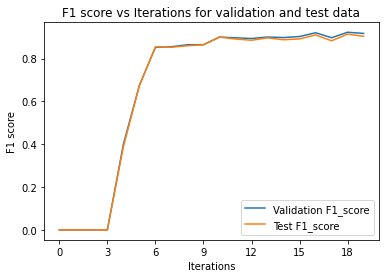

In [23]:
x=range(0,20)
 
ax = plt.figure().gca()
#...
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(valid_f1scores,label="Validation F1_score")
ax.plot(test_f1scores,label="Test F1_score")
ax.set_xlabel('Iterations')
ax.set_ylabel('F1 score')
ax.legend()
ax.set_title('F1 score vs Iterations for validation and test data')

In [24]:
def load_model(model_path):
    ''' Loads a pre-trained model for prediction on new test sentences
   
    model_path : directory of model saved by spacy.to_disk
    '''
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

In [25]:
ner = load_model("\spacy_example")



test_sentences = [x[0] for x in TEST_DATA[0:4000]] # extract the sentences from [sentence, entity]
for x in test_sentences:
    doc = ner(x)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc,jupyter=True, style = "ent")

Torsade 0 7 B_Disease
de 8 10 I_Disease
pointes 11 18 I_Disease
ventricular 19 30 I_Disease
tachycardia 31 42 I_Disease
dilated 111 118 B_Disease
cardiomyopathy 119 133 I_Disease
congestive 138 148 B_Disease
heart 149 154 I_Disease
failure 155 162 I_Disease


heart 79 84 B_Disease
failure 85 92 I_Disease
dilated 106 113 B_Disease
cardiomyopathy 114 128 I_Disease
ventricular 156 167 B_Disease
arrhythmias 168 179 I_Disease
pointes 225 232 B_Disease
ventricular 233 244 I_Disease
tachycardia 245 256 I_Disease


torsade 15 22 B_Disease
de 23 25 I_Disease
pointes 26 33 B_Disease
ventricular 34 45 I_Disease
tachycardia 46 57 I_Disease
arrhythmias 138 149 B_Disease
disturbances 234 246 B_Disease


dyspnea 109 116 B_Disease
loss 119 123 B_Disease
consciousness 127 140 B_Disease
papular 163 170 B_Disease
rash 171 175 I_Disease
pain 268 272 B_Disease


allergy 94 101 B_Disease


hyperammonemic 18 32 B_Disease
encephalopathy 33 47 I_Disease
cancer 51 57 B_Disease
dehydration 145 156 B_Disease
infection 161 170 B_Disease


cancer 23 29 B_Disease
hyperammonemic 72 86 B_Disease
encephalopathy 87 101 I_Disease


decompensated 25 38 B_Disease
liver 39 44 I_Disease
disease 45 52 I_Disease


hyperammonemic 9 23 B_Disease
encephalopathy 24 38 I_Disease


azotemia 59 67 B_Disease
infections 108 118 I_Disease
infection 143 152 B_Disease
dehydration 180 191 B_Disease


hyperammonemia 54 68 B_Disease


hyperammonemic 16 30 B_Disease
encephalopathy 31 45 I_Disease


Azotemia 0 8 B_Disease
fluid 16 21 B_Disease
insufficiency 22 35 I_Disease
infections 50 60 I_Disease


hypoactivity 138 150 B_Disease
hyperactivity 228 241 B_Disease


hypoactivity 137 149 B_Disease
hyperactivity 177 190 B_Disease


memory 56 62 B_Disease
impairment 63 73 I_Disease


allodynia 122 131 B_Disease
hyperalgesia 136 148 B_Disease


impairment 109 119 B_Disease


liver 20 25 B_Disease
toxicity 26 34 I_Disease


rheumatoid 44 54 B_Disease
arthritis 55 64 I_Disease
cytolytic 85 94 B_Disease
hepatitis 95 104 I_Disease


cytolytic 10 19 B_Disease
hepatitis 20 29 I_Disease
antinuclear 121 132 B_Disease
hypersensitivity 157 173 B_Disease


liver 37 42 B_Disease
toxicity 43 51 I_Disease
hepatic 102 109 B_Disease
damage 110 116 I_Disease


bone 84 88 B_Disease
marrow 89 95 I_Disease
aplastic 160 168 B_Disease
anemia 169 175 I_Disease


aplastic 182 190 B_Disease
anemia 191 197 I_Disease


necrosis 3 11 B_Disease
necrosis 155 163 B_Disease


aplastic 51 59 B_Disease
anemia 60 66 I_Disease
aplastic 242 250 B_Disease
anemia 251 257 I_Disease


catalepsy 31 40 B_Disease


catalepsy 84 93 B_Disease


catalepsy 112 121 B_Disease


catalepsy 84 93 B_Disease


catalepsy 99 108 B_Disease


Catalepsy 0 9 B_Disease


catalepsy 110 119 B_Disease


ventricular 15 26 B_Disease
dysfunction 27 38 I_Disease
artery 72 78 I_Disease
disease 79 86 I_Disease
myocardial 130 140 B_Disease
ischaemia 141 150 I_Disease


ventricular 95 106 B_Disease
dysfunction 107 118 I_Disease
coronary 136 144 B_Disease
artery 145 151 I_Disease
disease 152 159 I_Disease


diastolic 71 80 B_Disease
left 81 85 I_Disease
ventricular 86 97 I_Disease
ischaemia 145 154 B_Disease


angina 35 41 B_Disease
coronary 68 76 B_Disease
artery 77 83 I_Disease
disease 84 91 I_Disease
ventricular 110 121 B_Disease


ST 72 74 B_Disease
depression 75 85 I_Disease


coronary 31 39 B_Disease
artery 40 46 I_Disease
disease 47 54 I_Disease
ischaemia 76 85 B_Disease
ventricular 123 134 B_Disease
dysfunction 135 146 I_Disease
myocardial 164 174 B_Disease


ischaemia 19 28 B_Disease
coronary 126 134 B_Disease
artery 135 141 I_Disease
disease 142 149 I_Disease


pulmonary 16 25 B_Disease
hypertension 26 38 I_Disease
pulmonary 110 119 B_Disease
hypertension 120 132 I_Disease


appetite 24 32 B_Disease
primary 100 107 B_Disease
pulmonary 108 117 I_Disease
hypertension 118 130 I_Disease


pulmonary 97 106 B_Disease
hypertension 107 119 I_Disease


pulmonary 108 117 B_Disease
hypertension 118 130 I_Disease


pulmonary 39 48 B_Disease
hypertension 49 61 I_Disease


pulmonary 88 97 B_Disease
hypertension 98 110 I_Disease
pulmonary 141 150 B_Disease
hypertension 151 163 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


anorexigen 23 33 B_Disease
pulmonary 116 125 B_Disease
hypertension 126 138 I_Disease


thrombocytopenia 38 54 B_Disease
thrombosis 59 69 B_Disease


thrombosis 99 109 B_Disease


thrombotic 121 131 B_Disease


Bleeding 0 8 B_Disease


bleeding 6 14 B_Disease


thrombocytopenia 93 109 B_Disease
osteoporosis 133 145 B_Disease
eosinophilia 148 160 B_Disease
allergic 180 188 B_Disease
thrombocytopenia 210 226 B_Disease
alopecia 229 237 B_Disease
transaminasemia 240 255 B_Disease
hyperkalemia 258 270 B_Disease
hypoaldosteronism 273 290 B_Disease
priapism 297 305 B_Disease


HITT 152 156 B_Disease
osteoporosis 161 173 B_Disease


optic 20 25 B_Disease
neuropathy 26 36 I_Disease


optic 40 45 B_Disease
neuropathy 46 56 I_Disease


deterioration 35 48 B_Disease
vision 52 58 B_Disease
ischemic 108 116 B_Disease
optic 117 122 I_Disease
neuropathies 123 135 I_Disease


Deterioration 0 13 B_Disease
vision 17 23 B_Disease


optic 82 87 B_Disease
nerve 88 93 I_Disease
toxicity 94 102 I_Disease


Hypercalcemia 0 13 B_Disease
arrhythmia 16 26 B_Disease


bipolar 21 28 B_Disease
hypercalcemia 89 102 B_Disease
bradyarrhythmia 114 129 B_Disease
bipolar 187 194 B_Disease
hypercalcemia 230 243 B_Disease


hypercalcemia 27 40 B_Disease


hypercalcemias 27 41 B_Disease
hypercalcemias 152 166 B_Disease
hypercalcemia 274 287 B_Disease


bipolar 114 121 B_Disease
normocalcemic 122 135 I_Disease
bipolar 177 184 B_Disease
normocalcemic 185 198 I_Disease


hypercalcemia 14 27 B_Disease
diseases 51 59 B_Disease
bipolar 64 71 B_Disease
hypercalcemia 107 120 B_Disease
defects 172 179 I_Disease


nephrotoxicity 15 29 B_Disease


toxicity 111 119 B_Disease


toxicity 16 24 B_Disease


tubular 51 58 B_Disease
necrosis 59 67 I_Disease


nephrotoxicity 128 142 B_Disease


nephrotoxicity 31 45 B_Disease


nephrotoxicity 19 33 B_Disease
toxoplasmosis 78 91 B_Disease
HIV 95 98 B_Disease


oliguria 49 57 B_Disease
abdominal 60 69 B_Disease
pain 70 74 I_Disease
renal 77 82 B_Disease
failure 83 90 I_Disease
renal 123 128 B_Disease
calculi 129 136 I_Disease


lithiasis 72 81 B_Disease


nystagmus 9 18 B_Disease


dizziness 59 68 B_Disease
downbeating 74 85 B_Disease
nystagmus 86 95 I_Disease


myocardial 94 104 B_Disease
infarction 105 115 I_Disease


myocardial 278 288 B_Disease
infarction 289 299 I_Disease


tachycardia 77 88 B_Disease
tachycardia 155 166 B_Disease


arrhythmias 111 122 B_Disease
ventricular 155 166 B_Disease


ovarian 97 104 B_Disease
fallopian 109 118 I_Disease
tube 119 123 I_Disease
cancers 124 131 I_Disease
primary 136 143 B_Disease
carcinoma 144 153 I_Disease


ovarian 140 147 B_Disease
cancer 148 154 I_Disease
toxicity 176 184 B_Disease
syndrome 294 302 I_Disease
stomatitis 311 321 B_Disease


ovarian 38 45 B_Disease
fallopian 49 58 B_Disease
tube 59 63 I_Disease
cancers 64 71 I_Disease
carcinoma 94 103 B_Disease
disease 144 151 B_Disease
disease 176 183 I_Disease


syndrome 68 76 B_Disease
stomatitis 81 91 B_Disease


diarrhea 30 38 B_Disease
hospitalization 49 64 B_Disease


toxicity 73 81 B_Disease
stomatitis 84 94 B_Disease
syndrome 109 117 B_Disease


ovarian 137 144 B_Disease
cancer 145 151 I_Disease


bipolar 32 39 B_Disease
mania 40 45 I_Disease


bipolar 101 108 B_Disease
mania 109 114 I_Disease


bipolar 53 60 B_Disease
disorder 61 69 I_Disease
manic 72 77 B_Disease


Mania 45 50 B_Disease


Symptom 58 65 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


somnolence 251 261 B_Disease


bipolar 93 100 B_Disease
mania 101 106 I_Disease


vision 49 55 B_Disease


vision 52 58 B_Disease


visual 53 59 B_Disease


deterioration 69 82 B_Disease


vision 59 65 B_Disease


embryopathy 23 34 B_Disease
bilateral 40 49 B_Disease
anotia 50 56 I_Disease
Bing 71 75 B_Disease
malformation 76 88 I_Disease


congenital 41 51 B_Disease
anomalies 52 61 I_Disease
anotia 64 70 B_Disease
Bing 85 89 B_Disease
malformation 90 102 I_Disease


stress 73 79 B_Disease
incontinence 80 92 I_Disease


urinary 122 129 B_Disease
stress 130 136 I_Disease
incontinence 137 149 I_Disease


stress 127 133 B_Disease
incontinence 134 146 I_Disease


diastolic 58 67 B_Disease
blood 68 73 I_Disease
systolic 116 124 B_Disease
blood 125 130 I_Disease


headache 47 55 B_Disease
extremities 67 78 B_Disease


stress 164 170 B_Disease
incontinence 171 183 I_Disease
cardiovascular 230 244 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hyperglycemia 121 134 B_Disease
glucosuria 194 204 B_Disease


chronic 88 95 B_Disease
heart 96 101 I_Disease
failure 102 109 I_Disease


mortality 87 96 B_Disease
morbidity 101 110 B_Disease
chronic 128 135 B_Disease
heart 136 141 I_Disease
failure 142 149 I_Disease
CHF 152 155 B_Disease


CHF 104 107 B_Disease


CHF 58 61 B_Disease
ventricular 71 82 B_Disease


hypotension 132 143 B_Disease
renal 148 153 B_Disease
dysfunction 154 165 I_Disease


hypotension 201 212 B_Disease
renal 239 244 B_Disease
dysfunction 245 256 I_Disease
hyperkalemia 260 272 B_Disease


intolerance 58 69 B_Disease
blood 72 77 B_Disease
diabetes 213 221 B_Disease


CHF 90 93 B_Disease


cardiotoxity 37 49 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cardiac 15 22 B_Disease
toxicity 23 31 I_Disease


cardiotoxicity 74 88 B_Disease


cardiovascular 59 73 B_Disease
collapse 74 82 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Ventricular 0 11 B_Disease
arrhythmias 12 23 I_Disease
ventricular 109 120 B_Disease
tachycardia 121 132 I_Disease


cardiac 42 49 B_Disease
toxicity 50 58 I_Disease


myocardial 70 80 B_Disease
depression 81 91 I_Disease


Parkinsonism 13 25 B_Disease


Parkinson 41 50 B_Disease
' 51 52 I_Disease
s 53 54 I_Disease
disease 55 62 I_Disease


irregular 13 22 B_Disease
heartbeat 23 32 I_Disease


irregular 84 93 B_Disease
heart 94 99 I_Disease
bradycardia 116 127 B_Disease
HIV 145 148 B_Disease


Bradycardia 0 11 B_Disease
HIV 105 108 B_Disease


Graves 99 105 B_Disease
' 106 107 I_Disease
disease 108 115 I_Disease


vasculitis 90 100 B_Disease
' 143 144 I_Disease
disease 145 152 I_Disease


MPO 97 100 B_Disease
vasculitis 112 122 B_Disease
Graves 191 197 B_Disease
' 198 199 I_Disease
disease 200 207 I_Disease


Graves 67 73 B_Disease
' 74 75 I_Disease
disease 76 83 I_Disease


hyperthyroidism 55 70 B_Disease
Graves 78 84 B_Disease
' 85 86 I_Disease
disease 87 94 I_Disease
vasculitis 152 162 B_Disease


Graves 72 78 B_Disease
' 79 80 I_Disease
disease 81 88 I_Disease


vasculitic 145 155 B_Disease
disorders 156 165 I_Disease


fever 95 100 B_Disease
ulcers 108 114 B_Disease
polyarthralgia 119 133 B_Disease


MPO 62 65 B_Disease
vasculitis 131 141 B_Disease


heart 14 19 B_Disease
disease 20 27 I_Disease


heart 31 36 B_Disease
disease 37 44 I_Disease


coronary 25 33 B_Disease
artery 34 40 I_Disease
disease 41 48 I_Disease


abnormal 36 44 B_Disease
left 45 49 I_Disease
ventricular 50 61 I_Disease


myocardial 36 46 B_Disease
disease 47 54 I_Disease


myocardial 126 136 B_Disease
infarction 137 147 I_Disease


myocardial 126 136 B_Disease
infarction 137 147 I_Disease


ventricular 62 73 B_Disease
tachycardia 74 85 I_Disease
QT 105 107 B_Disease
syndrome 108 116 I_Disease
ventricular 184 195 B_Disease
wall 196 200 I_Disease


pointes 133 140 B_Disease
TdP 143 146 B_Disease
QT 154 156 B_Disease


TdP 124 127 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


TdP 126 129 B_Disease


ventricular 153 164 B_Disease
wall 165 169 I_Disease
TdP 217 220 B_Disease
QT 227 229 B_Disease


chest 136 141 B_Disease
pain 142 146 I_Disease


Chest 18 23 B_Disease
pain 24 28 I_Disease


cardiac 99 106 B_Disease
ischemia 107 115 I_Disease


chest 220 225 B_Disease
pain 226 230 I_Disease


chest 95 100 B_Disease
pain 101 105 I_Disease


toxicity 48 56 B_Disease


hypokinesis 88 99 B_Disease
atrial 157 163 B_Disease
conduction 164 174 I_Disease
deficit 175 182 I_Disease


tachydysrhythmias 170 187 B_Disease
sinus 200 205 B_Disease
tachycardia 206 217 I_Disease


chest 129 134 B_Disease
pain 135 139 I_Disease


cranial 30 37 B_Disease
sonographic 38 49 I_Disease


subependymal 57 69 B_Disease
hemorrhage 70 80 I_Disease
cysts 102 107 B_Disease


subependymal 79 91 B_Disease
cysts 92 97 I_Disease


cranial 62 69 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


subependymal 17 29 B_Disease
cysts 30 35 I_Disease


subependymal 17 29 B_Disease
cysts 30 35 I_Disease


subependymal 49 61 B_Disease
cyst 62 66 I_Disease


neuropathy 12 22 B_Disease
prostate 58 66 B_Disease
cancer 67 73 I_Disease


neuropathy 49 59 B_Disease


prostate 57 65 B_Disease
cancer 66 72 I_Disease
neurologic 128 138 B_Disease
nerve 156 161 B_Disease


neuropathy 23 33 B_Disease


Neuropathy 0 10 B_Disease


peripheral 38 48 B_Disease
neuropathy 49 59 I_Disease


hearing 89 96 B_Disease
loss 97 101 I_Disease


ototoxicity 73 84 B_Disease
ototoxicity 244 255 B_Disease


ototoxicity 129 140 B_Disease


ototoxicity 154 165 B_Disease


liver 6 11 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


liver 196 201 B_Disease
depression 206 216 B_Disease


depression 129 139 B_Disease


Depressed 0 9 B_Disease
hepatic 10 17 I_Disease
hepatic 89 96 B_Disease
fatty 212 217 B_Disease
liver 218 223 I_Disease


anxiety 19 26 B_Disease
glial 31 36 B_Disease
cerebral 37 45 I_Disease


PDN 43 46 B_Disease
anxiety 58 65 B_Disease
cerebral 75 83 B_Disease
glial 84 89 I_Disease


Anxiety 0 7 B_Disease


Anxiety 10 17 B_Disease
PDN 51 54 B_Disease


PDN 34 37 B_Disease
anxiety 46 53 B_Disease


squamous 83 91 B_Disease
cell 92 96 I_Disease
carcinoma 97 106 I_Disease


cervical 144 152 B_Disease
carcinoma 153 162 I_Disease


squamous 237 245 B_Disease
cell 246 250 I_Disease
cervical 251 259 I_Disease
carcinoma 260 269 I_Disease
toxicity 306 314 B_Disease


toxicity 100 108 B_Disease


myelosuppression 26 42 B_Disease
neutropenia 64 75 B_Disease
anemia 93 99 B_Disease
thrombocytopenia 117 133 B_Disease
neutropenic 155 166 B_Disease
fever 167 172 I_Disease


toxicity 30 38 B_Disease
nausea 48 54 B_Disease
emesis 72 78 B_Disease
fatigue 96 103 B_Disease
mucositis 120 129 B_Disease
stomatitis 139 149 B_Disease
constipation 166 178 B_Disease
weight 195 201 B_Disease
loss 202 206 I_Disease
syndrome 235 243 I_Disease


cervical 118 126 B_Disease
carcinoma 127 136 I_Disease


mania 24 29 B_Disease
antibiomania 32 44 B_Disease


manic 60 65 B_Disease
mania 153 158 B_Disease


mania 48 53 B_Disease


manic 78 83 B_Disease


mania 127 132 B_Disease


mania 46 51 B_Disease


mania 91 96 B_Disease
manic 166 171 B_Disease
affective 282 291 B_Disease
disorders 292 301 I_Disease


syndrome 33 41 B_Disease
antibiomania 44 56 B_Disease


ocular 19 25 B_Disease
dyskinesias 26 37 I_Disease
Parkinson 41 50 B_Disease
' 51 52 I_Disease
s 53 54 I_Disease
disease 55 62 I_Disease


ocular 19 25 B_Disease
dyskinesias 26 37 I_Disease


choreatic 56 65 B_Disease
dyskinesias 66 77 I_Disease


ocular 238 244 B_Disease
dyskinesias 245 256 I_Disease


dysmenorrhea 81 93 B_Disease


dysmenorrhea 8 20 B_Disease
syndrome 26 34 B_Disease
contractility 68 81 I_Disease
hypersecretion 94 108 B_Disease
endometrial 112 123 B_Disease


dysmenorrhea 135 147 B_Disease
DCF 180 183 B_Disease


dysmenorrhea 60 72 B_Disease
menstrual 109 118 B_Disease


pain 18 22 B_Disease


DCF 10 13 B_Disease
pelvic 52 58 B_Disease
pain 59 63 I_Disease


pain 9 13 B_Disease


Headache 0 8 B_Disease
DCF 55 58 B_Disease


headache 41 49 B_Disease


DCF 92 95 B_Disease
dysmenorrhea 124 136 B_Disease


glomerular 96 106 B_Disease
injury 107 113 I_Disease
nephrosis 151 160 B_Disease


proteinuria 186 197 B_Disease
glomerular 210 220 B_Disease
hypertrophy 221 232 I_Disease
glomerulosclerosis 247 265 B_Disease
nephrotic 321 330 B_Disease


Nephrosis 0 9 B_Disease


proteinuria 29 40 B_Disease


glomerulosclerosis 4 22 B_Disease


renal 54 59 B_Disease
renal 86 91 B_Disease
neprotic 108 116 I_Disease


Pulmonary 0 9 B_Disease
hypertension 10 22 I_Disease


hypoxaemia 32 42 B_Disease
ductus 147 153 B_Disease
arteriosus 154 164 I_Disease
premature 183 192 B_Disease


Hypoxaemia 0 10 B_Disease


pulmonary 80 89 B_Disease
pressure 90 98 I_Disease
hypoxaemia 102 112 B_Disease


Hyponatremia 0 12 B_Disease
syndrome 17 25 B_Disease


hyponatremia 127 139 B_Disease
syndrome 149 157 B_Disease


hyponatremia 113 125 B_Disease


hyponatremia 33 45 B_Disease
SIADH 55 60 B_Disease


leukemia 64 72 B_Disease
lymphoma 76 84 B_Disease


hyponatremia 78 90 B_Disease
SIADH 100 105 B_Disease


SIADH 38 43 B_Disease


toxicity 8 16 B_Disease


CY 6 8 B_Disease
toxicity 9 17 I_Disease
haemorrhagic 35 47 B_Disease
cystitis 48 56 I_Disease


chronic 67 74 B_Disease
cystitis 75 83 I_Disease


cystitis 8 16 B_Disease
transepithelial 55 70 B_Disease


cystitis 8 16 B_Disease


toxicity 36 44 B_Disease
bladder 83 90 B_Disease
pathology 91 100 I_Disease


interstitial 25 37 B_Disease
cystitis 38 46 I_Disease


gastric 120 127 B_Disease
cancer 128 134 I_Disease


gastric 169 176 B_Disease
cancer 177 183 I_Disease
toxicity 229 237 B_Disease


toxicity 102 110 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


toxicities 10 20 B_Disease
leukopenia 67 77 B_Disease
thrombocytopenia 104 120 B_Disease
vomitus 146 153 B_Disease
diarrhea 175 183 B_Disease
stomatitis 209 219 B_Disease
syndrome 253 261 I_Disease


hemolytic 23 32 B_Disease
- 33 34 I_Disease
uremic 35 41 I_Disease
syndrome 42 50 I_Disease
HUS 53 56 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


HUS 116 119 B_Disease


leukocyturia 19 31 B_Disease
impaired 51 59 B_Disease
renal 60 65 I_Disease
immunodeficiency 84 100 I_Disease
virus 101 106 I_Disease


nephrotoxicity 60 74 B_Disease
immunodeficiency 99 115 B_Disease
virus 116 121 I_Disease


leukocyturia 57 69 B_Disease


leukocyturia 19 31 B_Disease
hematuria 138 147 B_Disease


leukocyturia 33 45 B_Disease
leukocyturia 158 170 B_Disease


leukocyturia 58 70 B_Disease


leukocyturia 44 56 B_Disease


nephrotoxicity 54 68 B_Disease


leukocyturia 120 132 B_Disease


leukocyturia 101 113 B_Disease


leukocyturia 33 45 B_Disease


impairment 4 14 B_Disease
nephrolithiasis 103 118 B_Disease


nephrotoxicity 23 37 B_Disease
leukocyturia 134 146 B_Disease


chest 60 65 B_Disease
pain 66 70 I_Disease


abnormalities 27 40 B_Disease
myocardial 83 93 B_Disease
necrosis 94 102 I_Disease
myocardial 130 140 B_Disease
infarction 141 151 I_Disease
chest 207 212 B_Disease
pain 213 217 I_Disease


chest 85 90 B_Disease
pain 91 95 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cardiac 122 129 B_Disease
death 130 135 I_Disease
coronary 154 162 B_Disease
disease 163 170 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


disease 47 54 B_Disease


cardiac 91 98 B_Disease
death 99 104 I_Disease
disease 120 127 B_Disease


disease 139 146 B_Disease


necrosis 96 104 B_Disease
chest 143 148 B_Disease
pain 149 153 I_Disease


interstitial 6 18 B_Disease
nephritis 19 28 I_Disease


interstitial 26 38 B_Disease
nephritis 39 48 I_Disease


fever 55 60 B_Disease
acute 65 70 B_Disease
renal 71 76 I_Disease
failure 77 84 I_Disease


retinal 77 84 B_Disease
vein 85 89 I_Disease
occlusion 90 99 I_Disease


fever 41 46 B_Disease
skin 51 55 B_Disease
rash 56 60 I_Disease


arthralgia 43 53 B_Disease
fever 58 63 B_Disease
eosinophilia 100 112 B_Disease
renal 117 122 B_Disease
failure 123 130 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


malignant 12 21 B_Disease
syndrome 22 30 I_Disease
intestinal 54 64 B_Disease
bleeding 65 73 I_Disease
chronic 92 99 B_Disease
renal 100 105 I_Disease
failure 106 113 I_Disease


chronic 15 22 B_Disease
renal 23 28 I_Disease
failure 29 36 I_Disease
CRF 39 42 B_Disease
neuroleptic 55 66 B_Disease
malignant 67 76 I_Disease
syndrome 77 85 I_Disease


intestinal 53 63 B_Disease
bleeding 64 72 I_Disease


CRF 48 51 B_Disease
intestinal 74 84 B_Disease
bleeding 85 93 I_Disease


hypertension 21 33 B_Disease


seizure 33 40 B_Disease
breakdown 51 60 B_Disease


mitochondrial 50 63 B_Disease
cardiomyopathy 64 78 I_Disease


cardiomyopathy 109 123 B_Disease


mitochondrial 52 65 B_Disease
dysfunction 66 77 I_Disease


hepatic 204 211 B_Disease
mitochondrial 212 225 I_Disease
bioenergetic 226 238 I_Disease
dysfunction 239 250 I_Disease
toxicity 290 298 B_Disease


cardiac 94 101 B_Disease
tissue 102 108 I_Disease
damage 109 115 I_Disease
mitochondrial 192 205 B_Disease
dysfunction 206 217 I_Disease
cardiomyopathy 222 236 B_Disease
cancer 289 295 B_Disease


hyperactivity 18 31 B_Disease
hyperactivity 109 122 B_Disease


hyperactivity 100 113 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hyperactivity 76 89 B_Disease
hyperactivity 166 179 B_Disease


hyperactivity 172 185 B_Disease
hyperactivity 293 306 B_Disease


bradyarrhythmia 27 42 B_Disease
atrial 98 104 B_Disease
fibrillation 105 117 I_Disease
myocardial 128 138 B_Disease
infarction 139 149 I_Disease


atrial 99 105 B_Disease
fibrillation 106 118 I_Disease
bradyarrhythmia 148 163 B_Disease


bradyarrhythmia 31 46 B_Disease
ventricular 176 187 B_Disease
arrhythmias 188 199 I_Disease


myocardial 163 173 B_Disease
infarction 174 184 I_Disease


bradyarrhythmia 52 67 B_Disease


bradyarrhythmia 129 144 B_Disease


cystitis 48 56 B_Disease


histopathologic 39 54 B_Disease
interstitial 75 87 B_Disease
cystitis 88 96 I_Disease
bladder 113 120 B_Disease
epithelium 121 131 I_Disease
mucosal 136 143 I_Disease
mastocytosis 144 156 I_Disease


cystitis 70 78 B_Disease


prostate 83 91 B_Disease
cancer 92 98 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


prostate 128 136 B_Disease
cancer 137 143 I_Disease


constipation 25 37 B_Disease
drowsiness 48 58 B_Disease
dizziness 61 70 B_Disease
rash 75 79 B_Disease


peripheral 12 22 B_Disease
sensory 23 30 I_Disease
neuropathy 31 41 I_Disease


peripheral 83 93 B_Disease
neuropathy 94 104 I_Disease


peripheral 170 180 B_Disease
neuropathy 181 191 I_Disease


nervous 8 15 I_Disease
toxicity 23 31 B_Disease


cardiac 55 62 B_Disease
toxicity 63 71 I_Disease


mal 29 32 B_Disease
seizures 33 41 I_Disease


mal 133 136 B_Disease
seizures 137 145 I_Disease


seizures 4 12 B_Disease


cardiovascular 35 49 B_Disease
toxicity 50 58 I_Disease


cardiac 56 63 B_Disease
toxicity 64 72 I_Disease
convulsions 189 200 B_Disease


nervous 54 61 B_Disease
toxicity 69 77 B_Disease
cardiac 112 119 B_Disease
toxicity 120 128 I_Disease


torsade 21 28 B_Disease
de 29 31 I_Disease
pointes 32 39 I_Disease
bladder 47 54 B_Disease


torsade 69 76 B_Disease
de 77 79 I_Disease
pointes 80 87 I_Disease
TdP 90 93 B_Disease


TdP 43 46 B_Disease
hypokalemia 114 125 B_Disease


bladder 40 47 B_Disease
TdP 83 86 B_Disease


bradycardia 22 33 B_Disease
TdP 55 58 B_Disease


bladder 59 66 B_Disease
proarrhythmia 169 182 B_Disease


TdP 82 85 B_Disease
hypokalemia 94 105 B_Disease
hypomagnesemia 110 124 B_Disease


myotonia 42 50 B_Disease
congenita 51 60 I_Disease
disorders 109 118 B_Disease


Myotonia 0 8 B_Disease
congenita 9 18 I_Disease
depolarisation 134 148 B_Disease


muscle 90 96 B_Disease
spasm 97 102 I_Disease


muscle 4 10 B_Disease
spasms 11 17 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


disorders 40 49 B_Disease
malignant 60 69 B_Disease
hyperthermia 70 82 I_Disease


Respiratory 0 11 B_Disease
epilepsy 38 46 B_Disease


Apnea 10 15 B_Disease
seizures 41 49 B_Disease
ictal 78 83 B_Disease
respiratory 84 95 I_Disease


epilepsy 114 122 B_Disease


epileptic 40 49 B_Disease
hyperventilation 136 152 B_Disease
hypoventilation 156 171 B_Disease


hyperventilation 14 30 B_Disease


epileptic 59 68 B_Disease
TE 148 150 B_Disease


epileptic 7 16 B_Disease
TE 101 103 B_Disease


epilepsy 84 92 B_Disease


myeloencephalopathy 6 25 B_Disease


leukaemia 65 74 B_Disease
motor 99 104 B_Disease
dysfunction 105 116 I_Disease
encephalopathy 129 143 B_Disease
death 148 153 B_Disease


heart 110 115 B_Disease
arrhythmic 143 153 B_Disease


arrhythmia 57 67 B_Disease


arrhythmia 28 38 B_Disease


acute 45 50 B_Disease
liver 51 56 I_Disease
failure 57 64 I_Disease
overdose 84 92 B_Disease


acute 162 167 B_Disease
liver 168 173 I_Disease
failure 174 181 I_Disease


acute 81 86 B_Disease
liver 87 92 I_Disease
failure 93 100 I_Disease


acute 94 99 B_Disease
liver 100 105 I_Disease
failure 106 113 I_Disease


tumor 16 21 B_Disease
necrosis 22 30 I_Disease


acute 66 71 B_Disease
liver 72 77 I_Disease
failure 78 85 I_Disease


acute 51 56 B_Disease
liver 57 62 I_Disease
failure 63 70 I_Disease
overdose 90 98 B_Disease
hepatitis 199 208 B_Disease


acute 76 81 B_Disease
liver 82 87 I_Disease
failure 88 95 I_Disease
tumor 193 198 B_Disease
necrosis 199 207 I_Disease
liver 253 258 B_Disease
cell 259 263 I_Disease
loss 264 268 I_Disease


Parkinson 46 55 B_Disease
' 56 57 I_Disease
s 58 59 I_Disease
disease 60 67 I_Disease


Parkinson 120 129 B_Disease
' 130 131 I_Disease
s 132 133 I_Disease
disease 134 141 I_Disease


Parkinson 55 64 B_Disease
' 65 66 I_Disease
s 67 68 I_Disease
disease 69 76 I_Disease
rigidity 154 162 B_Disease
dyskinesias 188 199 B_Disease


Preoperative 0 12 B_Disease
Parkinson 172 181 B_Disease
' 182 183 I_Disease
s 184 185 I_Disease
Disease 186 193 I_Disease


Parkinson 156 165 B_Disease
' 166 167 I_Disease
s 168 169 I_Disease
Disease 170 177 I_Disease


rigidity 33 41 B_Disease
tremor 44 50 B_Disease
gait 55 59 B_Disease


Parkinson 94 103 B_Disease
' 104 105 I_Disease
s 106 107 I_Disease
disease 108 115 I_Disease


dyskinesias 75 86 B_Disease


renal 6 11 B_Disease
failure 12 19 I_Disease
haemodialysis 90 103 B_Disease


thalassemia 39 50 B_Disease


renal 142 147 B_Disease
insufficiency 148 161 I_Disease


deterioration 22 35 B_Disease
nephrotoxicity 228 242 B_Disease


haemodialysis 28 41 B_Disease
acute 118 123 B_Disease
renal 124 129 I_Disease
failure 130 137 I_Disease


Ocular 0 6 B_Disease
motility 7 15 I_Disease
retinoblastoma 68 82 B_Disease


toxicity 91 99 B_Disease
intraocular 144 155 B_Disease
retinoblastoma 156 170 I_Disease


abnormal 51 59 B_Disease
ocular 60 66 I_Disease
motility 67 75 I_Disease


abnormal 19 27 B_Disease
ocular 28 34 I_Disease
motility 35 43 I_Disease
retinoblastoma 76 90 B_Disease


ocular 7 13 B_Disease
ocular 115 121 B_Disease
motility 122 130 I_Disease
tumor 137 142 B_Disease
ocular 156 162 B_Disease
motility 163 171 I_Disease


ocular 24 30 B_Disease
motility 31 39 I_Disease
retinoblastoma 107 121 I_Disease
multimodality 180 193 B_Disease


nerve 100 105 B_Disease
necrosis 202 210 B_Disease


rupture 68 75 B_Disease


fibrosis 79 87 B_Disease


toxicity 36 44 B_Disease


optic 15 20 B_Disease
neuropathy 21 31 I_Disease


optic 64 69 B_Disease
neuropathy 70 80 I_Disease


optic 41 46 B_Disease
neuropathy 47 57 I_Disease
tuberculosis 98 110 B_Disease
lung 118 122 B_Disease


optic 27 32 B_Disease
neuropathy 33 43 I_Disease


visual 32 38 B_Disease
impairment 39 49 I_Disease
diabetes 67 75 B_Disease
mellitus 76 84 I_Disease
glaucoma 87 95 B_Disease


optic 34 39 B_Disease
neuropathy 40 50 I_Disease


diabetes 98 106 B_Disease
mellitus 107 115 I_Disease
glaucoma 118 126 B_Disease


gustatory 26 35 B_Disease
hyperhidrosis 36 49 I_Disease


Gustatory 0 9 B_Disease
hyperhidrosis 10 23 I_Disease
facial 27 33 B_Disease
sweating 34 42 I_Disease


gustatory 17 26 B_Disease
hyperhidrosis 27 40 I_Disease
hyperhidrosis 187 200 B_Disease


sweating 81 89 B_Disease
sweating 173 181 B_Disease


mouth 38 43 B_Disease
sore 50 54 B_Disease
throat 55 61 I_Disease
headache 109 117 B_Disease


gustatory 173 182 B_Disease
hyperhidrosis 183 196 I_Disease


hyperprolactinemia 25 43 B_Disease


hyperprolactinemia 40 58 B_Disease
amenorrhea 63 73 B_Disease


hyperprolactinemia 41 59 B_Disease
menstruation 73 85 B_Disease


psychiatric 41 52 B_Disease
symptoms 53 61 I_Disease


hyperprolactinemia 111 129 B_Disease
amenorrhea 134 144 B_Disease


convulsions 26 37 B_Disease


convulsive 60 70 B_Disease


convulsions 29 40 B_Disease


convulsions 113 124 B_Disease


myocardial 10 20 B_Disease
infarction 21 31 I_Disease


Myocardial 0 10 B_Disease
infarction 11 21 I_Disease


Spasm 0 5 B_Disease
coronary 8 16 B_Disease
dissection 17 27 I_Disease
atheromatous 33 45 B_Disease
etiology 46 54 I_Disease


myocardial 70 80 B_Disease
infarction 81 91 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neurotoxicity 57 70 B_Disease


hypotensive 24 35 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypotensive 21 32 B_Disease


hypotensive 39 50 B_Disease


hypotensive 120 131 B_Disease


hypotensive 137 148 B_Disease


hypotensive 40 51 B_Disease


hypotensive 4 15 B_Disease


Syndrome 0 8 B_Disease


myeloma 49 56 B_Disease


lethargy 52 60 B_Disease
weakness 65 73 B_Disease
hyponatremia 90 102 B_Disease


syndrome 24 32 B_Disease
antidiuretic 63 75 B_Disease


Heart 0 5 B_Disease
failure 6 13 I_Disease


atrial 17 23 B_Disease
fibrillation 24 36 I_Disease
ventricular 63 74 B_Disease


sinus 16 21 B_Disease
rhythm 22 28 I_Disease
heart 33 38 B_Disease
failure 39 46 I_Disease


myocardial 84 94 B_Disease
causing 109 116 B_Disease
arrhythmias 117 128 I_Disease


mortality 135 144 B_Disease
myocardial 151 161 B_Disease
infarction 162 172 I_Disease


hypertension 25 37 B_Disease


hypertension 43 55 B_Disease


headache 29 37 B_Disease
dizziness 40 49 B_Disease
palpitation 52 63 B_Disease
flushing 68 76 B_Disease


postural 84 92 B_Disease
hypotension 93 104 I_Disease


respiratory 81 92 B_Disease
cardiovascular 97 111 I_Disease
pain 126 130 B_Disease


thrombophlebitis 29 45 B_Disease


Pain 0 4 B_Disease
thrombophlebitis 52 68 B_Disease


thrombophlebitis 166 182 B_Disease


toxic 24 29 B_Disease
dermatitis 30 40 I_Disease
lymphadenopathy 45 60 B_Disease


rash 76 80 B_Disease
lymphadenopathy 83 98 B_Disease


Skin 0 4 B_Disease
rash 5 9 I_Disease
malignant 89 98 B_Disease
lymphadenopathy 99 114 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


rash 108 112 B_Disease
lymphadenopathy 115 130 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cancer 78 84 B_Disease


cardiotoxic 74 85 B_Disease


cardiac 138 145 B_Disease
cardiac 229 236 B_Disease
diseases 237 245 I_Disease


hypoxic 16 23 B_Disease
cortical 24 32 I_Disease
laminar 33 40 I_Disease
necrosis 41 49 I_Disease
hemolytic 66 75 B_Disease
anemia 76 82 I_Disease
crisis 83 89 I_Disease


hemolytic 101 110 B_Disease
anemia 111 117 I_Disease
crisis 118 124 I_Disease
cerebral 183 191 B_Disease
anoxia 192 198 I_Disease
damage 220 226 B_Disease


necrosis 53 61 B_Disease
cerebral 95 103 B_Disease
hemispheres 104 115 I_Disease
ischemic 118 126 B_Disease
cerebral 171 179 B_Disease


necrosis 26 34 B_Disease


visual 45 51 B_Disease
defects 58 65 I_Disease


visual 46 52 B_Disease
defects 59 66 I_Disease
seizure 191 198 B_Disease


defect 229 235 B_Disease


deterioration 32 45 B_Disease
visual 49 55 B_Disease


defects 38 45 B_Disease


visual 91 97 B_Disease
defects 104 111 I_Disease
toxicity 187 195 B_Disease


rosaceiform 13 24 B_Disease
dermatitis 25 35 I_Disease


rosacea 215 222 B_Disease
perioral 227 235 B_Disease
dermatitis 236 246 I_Disease


rosaceiform 13 24 B_Disease
dermatitis 25 35 I_Disease


facial 52 58 B_Disease


sudden 154 160 B_Disease
worsening 161 170 I_Disease
pustular 176 184 B_Disease
rosaceiform 185 196 I_Disease
lesions 197 204 I_Disease


eyelid 18 24 B_Disease
eczema 25 31 I_Disease
rosaceiform 34 45 B_Disease
periocular 46 56 I_Disease
dermatitis 57 67 I_Disease


atopic 18 24 B_Disease
dermatitis 25 35 I_Disease
telangiectatic 38 52 B_Disease
papular 57 64 B_Disease
rosacea 65 72 I_Disease


rosaceiform 60 71 B_Disease
dermatitis 72 82 I_Disease


Intravascular 0 13 B_Disease
hemolysis 14 23 I_Disease
acute 28 33 B_Disease
renal 34 39 I_Disease
failure 40 47 I_Disease


Renal 0 5 B_Disease
failure 6 13 I_Disease


Intravascular 0 13 B_Disease
hemolysis 14 23 I_Disease
renal 41 46 B_Disease
failure 47 54 I_Disease


leprosy 18 25 B_Disease
hemolysis 40 49 B_Disease
acute 54 59 B_Disease
renal 60 65 I_Disease
failure 66 73 I_Disease


deficits 62 70 B_Disease


deficits 69 77 B_Disease
cerebral 123 131 B_Disease
metabolic 132 141 I_Disease
abnormalities 142 155 I_Disease


chronic 166 173 B_Disease
MA 174 176 I_Disease
abuse 177 182 I_Disease
deficits 219 227 B_Disease
cognitive 231 240 B_Disease
impairment 241 251 I_Disease


abnormalities 95 108 B_Disease


hypertrophy 173 184 B_Disease


abuse 54 59 B_Disease
cerebral 90 98 B_Disease
deterioration 99 112 I_Disease
impaired 133 141 B_Disease
memory 142 148 I_Disease


hypertrophy 25 36 B_Disease
neuronal 133 141 B_Disease
damage 142 148 I_Disease


MA 60 62 B_Disease
abuse 63 68 I_Disease
brain 120 125 B_Disease
injury 126 132 I_Disease


hepatotoxicity 94 108 B_Disease


hepatomegaly 19 31 B_Disease


hepatomegaly 51 63 B_Disease


weight 136 142 B_Disease
loss 143 147 I_Disease


hepatoma 118 126 B_Disease


hepatotoxicity 174 188 B_Disease


hypercholesterolemia 102 122 B_Disease
dyslipidemia 133 145 B_Disease


dyslipidemia 33 45 B_Disease


dyslipidemia 149 161 B_Disease


myopathy 130 138 B_Disease


Flushing 0 8 B_Disease


myopathy 143 151 B_Disease


myocardial 61 71 B_Disease
injury 72 78 I_Disease


myocardial 160 170 B_Disease
damage 171 177 I_Disease


myocardial 61 71 B_Disease
necrosis 72 80 I_Disease


postoperative 10 23 B_Disease
anxiety 24 31 I_Disease


disturbance 52 63 B_Disease


diabetes 56 64 B_Disease
insipidus 65 74 I_Disease


neurogenic 51 61 B_Disease
diabetes 62 70 I_Disease
insipidus 71 80 I_Disease
traumatic 103 112 B_Disease
brain 113 118 I_Disease
injury 119 125 I_Disease


polydipsia 106 116 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neurogenic 248 258 B_Disease
DI 259 261 I_Disease
brain 275 280 B_Disease
trauma 281 287 I_Disease


neurogenic 56 66 B_Disease
DI 67 69 I_Disease


anemia 44 50 B_Disease


chronic 70 77 B_Disease
hepatitis 78 87 I_Disease
C 88 89 I_Disease
hemolytic 99 108 B_Disease
anemia 109 115 I_Disease


anemia 85 91 B_Disease


chronic 39 46 B_Disease
hepatitis 47 56 I_Disease


anemia 77 83 B_Disease


anemia 30 36 B_Disease


anemia 66 72 B_Disease


anemia 129 135 B_Disease


hepatitis 21 30 B_Disease


acute 10 15 B_Disease
hepatitis 16 25 I_Disease
AIDS 82 86 B_Disease


hepatitis 26 35 B_Disease


AIDS 36 40 B_Disease


damage 10 16 B_Disease
precedes 17 25 I_Disease
nitrative 26 35 I_Disease
damage 36 42 I_Disease
cardiac 67 74 B_Disease
mitochondrial 75 88 I_Disease
injury 89 95 I_Disease


cardiotoxicity 168 182 B_Disease
damage 240 246 B_Disease


mitochondrial 98 111 B_Disease
injury 112 118 I_Disease


damage 79 85 B_Disease
precedes 86 94 I_Disease
nitrative 95 104 I_Disease
damage 105 111 I_Disease


mitochondrial 26 39 B_Disease
injury 40 46 I_Disease
injury 147 153 B_Disease


coronary 18 26 B_Disease
spasm 27 32 I_Disease
dilated 51 58 B_Disease
cardiomyopathy 59 73 I_Disease
ventricular 100 111 B_Disease
tachycardia 112 123 I_Disease


ventricular 39 50 B_Disease
dysfunction 51 62 I_Disease
dilated 70 77 B_Disease
cardiomyopathy 78 92 I_Disease
ventricular 158 169 B_Disease
tachycardia 170 181 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Coronary 0 8 B_Disease
vasospasm 9 18 I_Disease


catalepsy 121 130 B_Disease
penile 282 288 B_Disease
erections 289 298 I_Disease


catalepsy 47 56 B_Disease


catalepsy 65 74 B_Disease
catalepsy 192 201 B_Disease


stereotypy 92 102 B_Disease
catalepsy 133 142 B_Disease
penile 205 211 B_Disease
erections 212 221 I_Disease


catalepsy 52 61 B_Disease


catalepsy 254 263 B_Disease


Swallowing 0 10 B_Disease
abnormalities 11 24 I_Disease
dyskinesia 29 39 B_Disease
Parkinson 43 52 B_Disease
' 53 54 I_Disease
s 55 56 I_Disease
disease 57 64 I_Disease


Gastrointestinal 0 16 B_Disease
abnormalities 17 30 I_Disease
Parkinson 34 43 B_Disease
' 44 45 I_Disease
s 46 47 I_Disease
disease 48 55 I_Disease
PD 58 60 B_Disease


PD 72 74 B_Disease
dyskinesia 120 130 B_Disease


nondyskinetic 24 37 B_Disease


dysphagia 26 35 B_Disease
Parkinson 67 76 B_Disease
' 77 78 I_Disease
s 79 80 I_Disease
Disease 81 88 I_Disease


Nondyskinetic 0 13 B_Disease
oropharyngeal 67 80 B_Disease
swallowing 81 91 I_Disease


nondyskinetic 55 68 B_Disease


dysphagia 22 31 B_Disease
PD 47 49 B_Disease


swallowing 63 73 B_Disease


dysphagia 90 99 B_Disease
PD 154 156 B_Disease


tubulointerstitial 60 78 B_Disease
nephritis 79 88 I_Disease


interstitial 72 84 B_Disease
fibrosis 85 93 I_Disease


fibrosis 44 52 B_Disease
renal 97 102 B_Disease


tubulointerstitial 83 101 B_Disease
nephritis 102 111 I_Disease


schizophrenia 36 49 B_Disease


diabetes 48 56 B_Disease
mellitus 57 65 I_Disease
schizophrenia 101 114 B_Disease
diabetes 297 305 B_Disease


schizophrenia 70 83 B_Disease


schizophrenia 36 49 B_Disease
schizoaffective 53 68 B_Disease
disorder 69 77 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


impairment 117 127 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Thoracic 0 8 B_Disease
hematomyelia 9 21 I_Disease
coumadin 35 43 B_Disease


thoracic 10 18 B_Disease
hematomyelia 19 31 I_Disease


Mania 0 5 B_Disease


depression 119 129 B_Disease


mania 85 90 B_Disease


mania 79 84 B_Disease


mania 45 50 B_Disease
hypomania 54 63 B_Disease
deficit 153 160 B_Disease
hyperactivity 161 174 I_Disease
disorder 175 183 I_Disease
affective 188 197 B_Disease
instability 198 209 I_Disease
depression 218 228 B_Disease
psychotic 234 243 B_Disease
affective 275 284 B_Disease
disorder 285 293 I_Disease
bipolar 307 314 B_Disease
disorder 315 323 I_Disease
bipolar 345 352 B_Disease
disorder 353 361 I_Disease


mania 146 151 B_Disease


renal 6 11 I_Disease
insufficiency 12 25 I_Disease
amyloidosis 88 99 B_Disease


amyloidosis 44 55 B_Disease
prognosis 75 84 B_Disease


acute 42 47 B_Disease
renal 48 53 I_Disease
insufficiency 54 67 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


renal 6 11 B_Disease
insufficiency 12 25 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypoalbuminemia 37 52 B_Disease
proteinuria 61 72 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


renal 27 32 B_Disease
injury 33 39 I_Disease


tubular 8 15 B_Disease
injury 16 22 I_Disease
renal 49 54 B_Disease
injury 55 61 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


AL 84 86 B_Disease


cerebral 6 14 B_Disease
ischemia 15 23 I_Disease
hypertension 68 80 B_Disease


cerebral 34 42 B_Disease
artery 43 49 I_Disease
occlusion 50 59 I_Disease
hypertensive 77 89 B_Disease
hypertension 135 147 B_Disease
ischemic 151 159 B_Disease
brain 160 165 I_Disease
injury 166 172 I_Disease


hypertension 139 151 B_Disease
HTN 159 162 B_Disease
hypertension 261 273 B_Disease
hypertension 347 359 B_Disease


brain 38 43 B_Disease
injury 44 50 I_Disease
edema 136 141 B_Disease


Brain 0 5 B_Disease
injury 6 12 I_Disease
ischemic 33 41 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypertension 79 91 B_Disease
brain 102 107 B_Disease
injury 108 114 I_Disease
edema 119 124 B_Disease
hypertension 146 158 B_Disease
vasogenic 181 190 B_Disease
edema 191 196 I_Disease


atrial 23 29 B_Disease
fibrillation 30 42 I_Disease
hemorrhage 75 85 B_Disease
stroke 90 96 B_Disease


hemorrhage 49 59 B_Disease
stroke 64 70 B_Disease
atrial 104 110 B_Disease
fibrillation 111 123 I_Disease


atrial 157 163 B_Disease
fibrillation 164 176 I_Disease


bleeding 43 51 B_Disease


hemorrhages 20 31 B_Disease
bleeds 139 145 B_Disease


stroke 11 17 B_Disease


hemorrhage 31 41 B_Disease
stroke 152 158 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypersensitivity 20 36 B_Disease


cutaneous 106 115 B_Disease


hypersensitivity 37 53 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


erythema 81 89 B_Disease
urticaria 100 109 B_Disease
- 110 111 I_Disease
angioedema 112 122 I_Disease


angioedema 38 48 B_Disease


hypersensitivity 22 38 B_Disease


renal 99 104 B_Disease
disease 105 112 I_Disease


renal 169 174 B_Disease
disease 175 182 I_Disease
ESRD 185 189 B_Disease


ESRD 85 89 B_Disease


ESRD 85 89 B_Disease


disease 49 56 B_Disease
ESRD 92 96 B_Disease


ESRD 12 16 B_Disease
vascular 160 168 B_Disease
nephropathy 169 180 I_Disease
disease 195 202 B_Disease


ESRD 137 141 B_Disease


ESRD 62 66 B_Disease


overdose 25 33 B_Disease
QT 58 60 B_Disease
syndrome 61 69 I_Disease


poisoning 31 40 B_Disease


hypocalcaemia 36 49 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


chronic 76 83 B_Disease
epileptic 84 93 I_Disease


epilepsy 115 123 B_Disease


dentate 190 197 B_Disease
gyrus 198 203 I_Disease
epilepticus 238 249 I_Disease


anxiety 153 160 B_Disease


anxiety 71 78 B_Disease


anxiety 83 90 B_Disease


anxiety 101 108 B_Disease


anxiety 97 104 B_Disease


HT 31 33 B_Disease


cardiovascular 59 73 B_Disease
disease 74 81 I_Disease
osteoporosis 84 96 B_Disease
dementia 101 109 B_Disease


HT 49 51 B_Disease
mortality 55 64 B_Disease
heart 67 72 B_Disease
disease 73 80 I_Disease
venous 83 89 B_Disease
thromboembolism 90 105 I_Disease
stroke 108 114 B_Disease
ischaemic 127 136 B_Disease
breast 147 153 B_Disease
cancer 154 160 I_Disease
colorectal 163 173 B_Disease
cancer 174 180 I_Disease
ovarian 183 190 B_Disease
cancer 191 197 I_Disease
endometrial 200 211 B_Disease
cancer 212 218 I_Disease
gallbladder 221 232 B_Disease
disease 233 240 I_Disease
cognitive 243 252 B_Disease
function 253 261 I_Disease
dementia 264 272 B_Disease
fractures 275 284 B_Disease


HT 50 52 B_Disease
venous 89 95 B_Disease
thromboembolism 96 111 I_Disease
stroke 159 165 B_Disease
breast 186 192 B_Disease
cancer 193 199 I_Disease
gallbladder 222 233 B_Disease
disease 234 241 I_Disease


HT 29 31 B_Disease
stroke 73 79 B_Disease
gallbladder 84 95 B_Disease
disease 96 103 I_Disease


HT 57 59 B_Disease
fractures 90 99 B_Disease
colon 104 109 B_Disease
cancer 110 116 I_Disease


HT 72 74 B_Disease
dementia 144 152 B_Disease


cardiovascular 17 31 B_Disease
disease 32 39 I_Disease
HT 81 83 B_Disease
venous 120 126 B_Disease
thromboembolism 127 142 I_Disease


venous 55 61 B_Disease
thromboembolism 62 77 I_Disease
HT 114 116 B_Disease


HT 24 26 B_Disease
chronic 74 81 B_Disease
disease 82 89 I_Disease


liver 15 20 B_Disease
injury 21 27 I_Disease


liver 94 99 B_Disease
injury 100 106 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


liver 4 9 B_Disease
damage 10 16 I_Disease
hepatocellular 48 62 B_Disease
cholestatic 65 76 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


liver 26 31 B_Disease
death 52 57 B_Disease
jaundice 101 109 B_Disease


fulminant 43 52 B_Disease
hepatic 53 60 I_Disease
failure 61 68 I_Disease
hepatocellular 136 150 B_Disease
damage 151 157 I_Disease


hepatocellular 43 57 B_Disease
jaundice 58 66 I_Disease
death 106 111 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cardiotoxicity 76 90 B_Disease


myocardiopathy 52 66 B_Disease


cardiac 71 78 B_Disease
toxicity 79 87 I_Disease


ADR 66 69 B_Disease
cardiotoxicity 70 84 I_Disease


nephrotoxicity 98 112 B_Disease


kidney 255 261 B_Disease
renal 304 309 B_Disease
impairment 310 320 I_Disease


renal 59 64 B_Disease
malondialdehyde 65 80 I_Disease
MDA 83 86 B_Disease
renal 161 166 B_Disease
tubular 167 174 I_Disease
injury 175 181 I_Disease


nephrotoxicity 69 83 B_Disease


vacuolization 82 95 B_Disease
atrophy 98 105 B_Disease
necrosis 127 135 B_Disease


tubular 31 38 B_Disease
damage 39 45 I_Disease
nephrotoxicity 91 105 B_Disease
kidney 187 193 B_Disease
damage 194 200 I_Disease


hyperlipoproteinemias 45 66 B_Disease


hyperlipidemia 220 234 B_Disease
atherosclerotic 254 269 B_Disease
vascular 270 278 I_Disease
disease 279 286 I_Disease


Myositis 0 8 B_Disease
rhabdomyolysis 212 226 B_Disease
myoglobinuria 230 243 B_Disease


restless 53 61 B_Disease
legs 62 66 I_Disease
syndrome 67 75 I_Disease


restless 79 87 B_Disease
legs 88 92 I_Disease
syndrome 93 101 I_Disease
RLS 104 107 B_Disease


RLS 30 33 B_Disease
RLS 172 175 B_Disease
symptoms 176 184 I_Disease


RLS 167 170 B_Disease


RLS 116 119 B_Disease


comorbid 44 52 B_Disease
postprandial 58 70 B_Disease
dyspepsia 71 80 I_Disease


RLS 40 43 B_Disease
RLS 102 105 B_Disease
symptoms 106 114 I_Disease


RLS 80 83 B_Disease
RLS 179 182 B_Disease


RLS 96 99 B_Disease


coronary 33 41 B_Disease
arterial 42 50 I_Disease
disease 51 58 I_Disease


prostate 87 95 B_Disease
cancer 96 102 I_Disease


TG 125 127 B_Disease
prostate 272 280 B_Disease
cancer 281 287 I_Disease


coronary 113 121 B_Disease
heart 122 127 I_Disease
disease 128 135 I_Disease


coronary 24 32 B_Disease
arteriosclerosis 33 49 I_Disease


cardiotoxicity 17 31 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cardiotoxicity 73 87 B_Disease


colon 35 40 B_Disease
cancer 41 47 I_Disease
metastases 48 58 I_Disease
lung 76 80 B_Disease


precordial 116 126 B_Disease
pain 127 131 I_Disease


precordial 9 19 B_Disease
pain 20 24 I_Disease


precordial 7 17 B_Disease
pain 18 22 I_Disease
cardiotoxicity 91 105 B_Disease


cardiac 16 23 B_Disease
symptoms 24 32 I_Disease


cardiotoxicity 123 137 B_Disease


cardiotoxicity 67 81 B_Disease


Hepatocellular 0 14 B_Disease
carcinoma 15 24 I_Disease
Fanconi 28 35 B_Disease
' 36 37 I_Disease
s 38 39 I_Disease
anemia 40 46 I_Disease


Fanconi 69 76 B_Disease
' 77 78 I_Disease
s 79 80 I_Disease
anemia 81 87 I_Disease


death 21 26 B_Disease
aplastic 56 64 B_Disease
crisis 65 71 I_Disease
septicemia 77 87 B_Disease
abnormalities 99 112 B_Disease
liver 116 121 B_Disease
hemorrhagic 143 154 B_Disease
bronchopneumonia 155 171 I_Disease


autopsy 3 10 B_Disease
peliosis 11 19 I_Disease
hepatic 33 40 B_Disease
tumors 41 47 I_Disease
hepatocellular 115 129 B_Disease
carcinoma 130 139 I_Disease


metastasizing 62 75 B_Disease
hepatic 76 83 I_Disease
neoplasms 84 93 I_Disease
peliosis 98 106 B_Disease
Fanconi 176 183 B_Disease
' 184 185 I_Disease
s 186 187 I_Disease
anemia 188 194 I_Disease


cardiotoxicity 130 144 B_Disease


cardiotoxicity 35 49 B_Disease


cardiac 14 21 B_Disease
damage 22 28 I_Disease


cardiotoxicity 111 125 B_Disease


damage 86 92 B_Disease
Cancer 136 142 B_Disease


cardiac 82 89 B_Disease
damage 90 96 I_Disease


atrial 74 80 B_Disease
fibrillation 81 93 I_Disease
flutter 98 105 B_Disease


atrial 93 99 B_Disease
fibrillation 100 112 I_Disease
atrial 124 130 B_Disease
flutter 131 138 I_Disease


pointes 57 64 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


bradycardia 72 83 B_Disease
dizziness 125 134 B_Disease
general 139 146 B_Disease
fatigue 147 154 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypokalemia 41 52 B_Disease
sudden 57 63 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cardiac 33 40 B_Disease
hypertrophy 41 52 I_Disease


LV 0 2 B_Disease
hypertrophy 3 14 I_Disease
TGR 68 71 B_Disease
SD 80 82 B_Disease


LV 12 14 B_Disease
hypertrophy 15 26 I_Disease
TGR 30 33 B_Disease


cardiac 82 89 B_Disease
hypertrophy 113 124 B_Disease


QT 20 22 B_Disease
syndrome 23 31 I_Disease


QT 33 35 B_Disease
syndrome 36 44 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


torsades 58 66 B_Disease
de 67 69 I_Disease
pointes 70 77 I_Disease


hypokalemia 154 165 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


liver 87 92 B_Disease
QT 116 118 B_Disease
prolongation 119 131 I_Disease


QT 5 7 B_Disease
syndrome 8 16 I_Disease


hypertension 14 26 B_Disease


Loss 0 4 B_Disease
hypertension 58 70 B_Disease
hallmark 76 84 B_Disease
arterial 88 96 B_Disease
dysfunction 97 108 I_Disease


hypertension 13 25 B_Disease


muscle 45 51 B_Disease
hypertension 126 138 B_Disease


circulatory 5 16 B_Disease
venomotor 58 67 B_Disease
LNNA 95 99 B_Disease
hypertension 100 112 I_Disease


LNNA 90 94 B_Disease
hypertensive 95 107 I_Disease


veins 148 153 B_Disease
hypertension 205 217 B_Disease


extrapyramidal 63 77 B_Disease
syndrome 78 86 I_Disease
schizophrenic 98 111 I_Disease


syndrome 21 29 B_Disease


schizophrenia 155 168 B_Disease


schizophrenic 83 96 B_Disease


Simpson 244 251 B_Disease


schizophrenia 234 247 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


seizures 79 87 B_Disease


epilepsy 100 108 B_Disease


seizures 129 137 B_Disease


seizures 13 21 B_Disease


status 27 33 B_Disease
epilepticus 34 45 I_Disease
seizures 129 137 B_Disease


seizures 164 172 B_Disease
status 225 231 B_Disease
epilepticus 232 243 I_Disease


impairs 31 38 B_Disease
associative 39 50 I_Disease


stroke 92 98 B_Disease


impaired 35 43 B_Disease


associative 86 97 B_Disease
stroke 131 137 B_Disease


vasculitis 22 32 B_Disease
polyarteritis 60 73 B_Disease
nodosa 74 80 I_Disease


pustulosis 71 81 B_Disease
fever 92 97 B_Disease
myalgias 100 108 B_Disease
polyneuropathy 111 125 B_Disease
testicular 132 142 B_Disease
pain 143 147 I_Disease


polyarteritis 102 115 B_Disease
nodosa 116 122 I_Disease


vasculitis 68 78 B_Disease


disease 42 49 B_Disease
polyarteritis 97 110 B_Disease
nodosa 111 117 I_Disease


hepatitis 14 23 B_Disease
B 24 25 I_Disease
hepatitis 84 93 B_Disease
B 94 95 I_Disease


hepatitis 22 31 B_Disease
B 32 33 I_Disease
immune 34 40 I_Disease
HBIg 52 56 B_Disease
hepatitis 110 119 B_Disease
B 120 121 I_Disease


hepatitis 94 103 B_Disease
B 104 105 I_Disease
virus 106 111 I_Disease


cirrhotic 171 180 B_Disease
diseases 181 189 I_Disease


seizures 68 76 B_Disease


seizures 118 126 B_Disease
seizure 204 211 B_Disease


seizures 82 90 B_Disease
seizure 127 134 B_Disease


seizures 88 96 B_Disease


seizures 49 57 B_Disease
seizures 132 140 B_Disease
seizure 178 185 B_Disease


renal 6 11 B_Disease
failure 12 19 I_Disease


Nephropathy 0 11 B_Disease


renal 54 59 B_Disease
failure 60 67 I_Disease
Rhizoma 196 203 B_Disease
Rhei 204 208 I_Disease
rhubarb 211 218 B_Disease


renal 4 9 B_Disease
injury 10 16 I_Disease


Renal 0 5 B_Disease
pathology 6 15 I_Disease
hypocellular 28 40 B_Disease
interstitial 41 53 I_Disease
fibrosis 54 62 I_Disease


renal 12 17 I_Disease
interstitial 84 96 B_Disease
fibrosis 97 105 I_Disease
tubular 110 117 B_Disease
atrophy 118 125 I_Disease


renal 97 102 B_Disease
injury 103 109 I_Disease
interstitial 159 171 B_Disease
nephropathy 172 183 I_Disease
unexplained 234 245 B_Disease
renal 246 251 I_Disease
failure 252 259 I_Disease


nephropathy 93 104 B_Disease


renal 117 122 B_Disease
damage 123 129 I_Disease
tumor 147 152 I_Disease


Toxicity 0 8 B_Disease


loss 55 59 B_Disease
necrosis 108 116 B_Disease


necrosis 108 116 B_Disease


toxicity 90 98 B_Disease


urinary 12 19 B_Disease
acidification 20 33 I_Disease
nephropathy 68 79 B_Disease


ectopic 62 69 B_Disease
hilar 70 75 I_Disease
granule 76 83 I_Disease
status 118 124 B_Disease
epilepticus 125 136 I_Disease


status 10 16 B_Disease
epilepticus 17 28 I_Disease
cell 58 62 I_Disease
neurogenesis 63 75 I_Disease
hilar 163 168 B_Disease


ectopic 31 38 B_Disease
hilar 39 44 I_Disease
granule 45 52 I_Disease
seizures 95 103 B_Disease
epilepticus 141 152 B_Disease


ectopic 50 57 B_Disease
hilar 58 63 I_Disease
granule 64 71 I_Disease
status 165 171 B_Disease
epilepticus 172 183 I_Disease


hilar 42 47 B_Disease
ectopic 48 55 I_Disease
granule 56 63 I_Disease
status 86 92 B_Disease
epilepticus 93 104 I_Disease


behavioral 90 100 B_Disease
seizures 101 109 I_Disease
ectopic 138 145 B_Disease
granule 146 153 I_Disease
behavioral 192 202 B_Disease
seizures 203 211 I_Disease


ectopic 59 66 B_Disease
hilar 67 72 I_Disease
granule 73 80 I_Disease
lobe 124 128 B_Disease
epilepsy 129 137 I_Disease


autistic 53 61 B_Disease
disorder 62 70 I_Disease


abnormalities 48 61 B_Disease
autism 91 97 B_Disease


autism 193 199 B_Disease


autism 51 57 B_Disease


irritability 68 80 B_Disease
emotional 153 162 B_Disease
lability 163 171 I_Disease
inattention 176 187 B_Disease
Conners 195 202 B_Disease
' 203 204 I_Disease


headaches 92 101 B_Disease


autism 157 163 B_Disease
aggression 179 189 B_Disease
behavioral 192 202 B_Disease
dyscontrol 203 213 I_Disease
inattention 220 231 B_Disease


schizophrenia 92 105 B_Disease


schizophrenia 129 142 B_Disease
spectrum 143 151 I_Disease
disorders 152 161 I_Disease


schizophrenia 113 126 B_Disease
schizophreniform 138 154 B_Disease
disorder 155 163 I_Disease
schizoaffective 178 193 B_Disease
disorder 194 202 I_Disease


parkinsonism 42 54 B_Disease
akathisia 59 68 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


visual 18 24 I_Disease
field 25 30 I_Disease
loss 31 35 I_Disease


visual 40 46 B_Disease
abnormalities 53 66 B_Disease


visual 51 57 B_Disease
acuity 58 64 I_Disease
vision 75 81 I_Disease
defects 177 184 B_Disease


Peri 0 4 B_Disease
atrioventricular 17 33 B_Disease
block 34 39 I_Disease


carcinoma 127 136 B_Disease


cardiac 73 80 B_Disease
symptoms 81 89 I_Disease


atrioventricular 29 45 B_Disease
block 46 51 I_Disease
ventricular 115 126 B_Disease


cardiotoxicity 131 145 B_Disease


acute 25 30 B_Disease
myocardial 31 41 I_Disease
infarction 42 52 I_Disease
gastrointestinal 102 118 B_Disease


hospitalization 33 48 B_Disease
AMI 53 56 B_Disease
GI 61 63 B_Disease
bleeding 64 72 I_Disease


hospitalization 90 105 B_Disease


bleeding 99 107 B_Disease


toxicity 13 21 B_Disease


arrhythmia 18 28 B_Disease
malaria 54 61 B_Disease


malaria 48 55 B_Disease
jaundice 69 77 B_Disease
arrhythmia 97 107 B_Disease
premature 110 119 B_Disease
ventricular 120 131 I_Disease
contraction 132 143 I_Disease


fever 58 63 B_Disease
vomiting 74 82 B_Disease
jaundice 85 93 B_Disease


malaria 249 256 B_Disease
jaundice 262 270 B_Disease


vomitus 34 41 B_Disease
diarrhea 44 52 B_Disease
tinnitus 55 63 B_Disease
loss 66 70 B_Disease
hearing 74 81 B_Disease


palpitation 52 63 B_Disease
premature 113 122 B_Disease
ventricular 123 134 I_Disease
contraction 135 146 I_Disease
sinoatrial 202 212 B_Disease
block 213 218 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


arrhythmic 66 76 B_Disease
arrhythmic 111 121 B_Disease
arrhythmias 145 156 B_Disease
arrhythmia 176 186 B_Disease


arrhythmic 107 117 B_Disease
heart 165 170 B_Disease
diseases 171 179 I_Disease
disorder 209 217 B_Disease
hypokalemia 220 231 B_Disease
vomiting 265 273 B_Disease
diarrhea 281 289 B_Disease
malaria 293 300 B_Disease


lichenoid 24 33 B_Disease
dermatitis 34 44 I_Disease
Wilson 78 84 B_Disease
disease 85 92 I_Disease
hepatic 106 113 B_Disease
anxiety 129 136 B_Disease
SPECT 141 146 B_Disease
abnormalities 147 160 I_Disease


Wilson 0 6 B_Disease
' 7 8 I_Disease
s 9 10 I_Disease
disease 11 18 I_Disease
autosomal 25 34 B_Disease
recessive 35 44 I_Disease
disorder 45 53 I_Disease
hepatic 57 64 B_Disease
copper 65 71 I_Disease
toxicity 123 131 B_Disease
hepatic 163 170 B_Disease
neurologic 173 183 B_Disease
psychiatric 188 199 B_Disease
disorders 200 209 I_Disease


Wilson 20 26 B_Disease
' 27 28 I_Disease
s 29 30 I_Disease
disease 31 38 I_Disease
chronic 44 51 B_Disease
liver 52 57 I_Disease
disease 58 65 I_Disease
anxiety 138 145 B_Disease
depression 154 164 B_Disease
hypoperfusion 203 216 B_Disease
lobe 268 272 I_Disease


lichenoid 96 105 B_Disease
dermatitis 106 116 I_Disease


Wilson 83 89 B_Disease
' 90 91 I_Disease
s 92 93 I_Disease
disease 94 101 I_Disease


Wilson 195 201 B_Disease
' 202 203 I_Disease
s 204 205 I_Disease
disease 206 213 I_Disease


Wilson 14 20 B_Disease
' 21 22 I_Disease
s 23 24 I_Disease
disease 25 32 I_Disease


Wilson 57 63 B_Disease
' 64 65 I_Disease
s 66 67 I_Disease
disease 68 75 I_Disease
Wilson 154 160 B_Disease
' 161 162 I_Disease
s 163 164 I_Disease
disease 165 172 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cardiac 41 48 B_Disease
chest 49 54 I_Disease
pain 55 59 I_Disease
chest 71 76 B_Disease
pain 77 81 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


syncopal 63 71 B_Disease


Chronic 0 7 B_Disease
lesion 8 14 I_Disease
hypertensive 65 77 B_Disease


neuronal 44 52 B_Disease
lesion 53 59 I_Disease
neurogenic 138 148 B_Disease
hypertensive 196 208 B_Disease


hypotension 27 38 B_Disease
bradycardia 72 83 B_Disease
tachycardia 142 153 B_Disease


hypertension 99 111 B_Disease
hypertensive 139 151 B_Disease


hypertension 86 98 B_Disease


encephalopathy 6 20 B_Disease
cerebral 25 33 B_Disease
vasospasm 34 43 I_Disease
lymphoblastic 157 170 B_Disease
leukemia 171 179 I_Disease


acute 96 101 B_Disease
lymphoblastic 102 115 I_Disease
leukemia 116 124 I_Disease


acute 22 27 B_Disease
encephalopathy 28 42 I_Disease
aphasia 77 84 B_Disease
incontinence 87 99 B_Disease
visual 102 108 B_Disease
hallucinations 109 123 I_Disease
weakness 144 152 B_Disease
cerebral 166 174 B_Disease
vasospasm 175 184 I_Disease


hypertensive 207 219 B_Disease


hypertension 47 59 B_Disease


hypertension 29 41 B_Disease
hypertensive 152 164 B_Disease


hypertension 191 203 B_Disease


hypertension 24 36 B_Disease


hypokalemia 17 28 B_Disease


hypokalemia 223 234 B_Disease


cognitive 118 127 B_Disease
impairment 128 138 I_Disease


poisoning 208 217 B_Disease


impairments 39 50 B_Disease
dysfunction 148 159 B_Disease


pervasive 91 100 B_Disease
cognitive 101 110 I_Disease
affective 115 124 B_Disease
dysfunction 125 136 I_Disease


cognitive 122 131 B_Disease
deficits 132 140 I_Disease


panic 27 32 B_Disease
disorder 33 41 I_Disease
depression 46 56 B_Disease
panic 62 67 B_Disease


panic 40 45 B_Disease
disorder 46 54 I_Disease
PD 57 59 B_Disease
depression 86 96 B_Disease
panic 102 107 B_Disease
MDP 118 121 B_Disease
Mental 163 169 B_Disease
Disorders 170 179 I_Disease
panic 253 258 B_Disease


PD 38 40 B_Disease
MDP 51 54 B_Disease
depression 71 81 B_Disease
panic 90 95 B_Disease


anxiety 180 187 B_Disease


PD 48 50 B_Disease
MDP 90 93 B_Disease
panic 185 190 B_Disease


PD 18 20 B_Disease
MDP 25 28 B_Disease


panic 3 8 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


panic 54 59 B_Disease
PD 99 101 B_Disease
MDP 105 108 B_Disease
hyperreactivity 115 130 B_Disease


ventricular 25 36 B_Disease
ventricle 77 86 I_Disease


dilated 103 110 B_Disease
cardiomyopathy 111 125 I_Disease
mitral 141 147 I_Disease
regurgitation 148 161 I_Disease
ventricular 250 261 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


acute 66 71 B_Disease
heart 72 77 I_Disease
failure 78 85 I_Disease


heart 6 11 B_Disease
failure 12 19 I_Disease


heart 58 63 B_Disease
failure 64 71 I_Disease


acute 113 118 B_Disease
heart 119 124 I_Disease
failure 125 132 I_Disease


chronic 61 68 B_Disease
heart 69 74 I_Disease
failure 75 82 I_Disease


seizure 36 43 B_Disease


neurotoxicity 47 60 B_Disease


renal 51 56 B_Disease
disease 57 64 I_Disease
slurred 142 149 B_Disease
speech 150 156 I_Disease
tremor 159 165 B_Disease
mental 199 205 B_Disease
confusion 206 215 I_Disease
clonic 256 262 B_Disease
seizure 263 270 I_Disease
bronchiectasis 355 369 B_Disease
secondary 375 384 B_Disease
infection 385 394 I_Disease


leukocytosis 78 90 B_Disease


Neurologic 0 10 B_Disease
dysarthria 31 41 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


infarction 59 69 B_Disease
organic 74 81 B_Disease
brain 82 87 I_Disease
lesions 88 95 I_Disease


encephalopathy 23 37 B_Disease
uremic 66 72 B_Disease
unexplained 87 98 B_Disease
neurological 99 111 I_Disease
manifestations 112 126 I_Disease


encephalopathy 117 131 B_Disease


ipsilateral 23 34 B_Disease
vocal 35 40 I_Disease
cord 41 45 I_Disease
paralysis 46 55 I_Disease


ipsilateral 10 21 B_Disease
vocal 22 27 I_Disease
nerve 28 33 I_Disease
palsies 34 41 I_Disease


contralateral 84 97 B_Disease
paralysis 98 107 I_Disease


ipsilateral 59 70 B_Disease
vocal 71 76 I_Disease
cord 77 81 I_Disease
paralysis 82 91 I_Disease


cord 141 145 B_Disease
paralysis 146 155 I_Disease


ipsilateral 47 58 B_Disease
vocal 59 64 I_Disease
cord 65 69 I_Disease
paralysis 70 79 I_Disease


paralysis 23 32 B_Disease
paralysis 227 236 B_Disease


cord 50 54 B_Disease
paralysis 55 64 I_Disease


Impaired 0 8 B_Disease
fear 9 13 I_Disease


impaired 197 205 B_Disease
fear 206 210 I_Disease


deficit 14 21 B_Disease
fear 25 29 B_Disease
impaired 233 241 B_Disease


impaired 68 76 B_Disease
fear 77 81 I_Disease
amygdala 96 104 B_Disease
dysfunction 105 116 I_Disease


Damage 0 6 B_Disease
substantia 10 20 B_Disease
nigra 21 26 I_Disease
pars 27 31 I_Disease
status 72 78 B_Disease
epilepticus 79 90 I_Disease


substantia 4 14 B_Disease
nigra 15 20 I_Disease
epileptic 69 78 B_Disease
seizure 79 86 I_Disease


status 38 44 B_Disease
epilepticus 45 56 I_Disease
substantia 80 90 B_Disease
nigra 91 96 I_Disease
metabolic 166 175 B_Disease
derangement 176 187 I_Disease
hyperexcitation 192 207 B_Disease


epilepticus 23 34 B_Disease


status 98 104 B_Disease
epilepticus 105 116 I_Disease


neuronal 121 129 B_Disease
damage 130 136 I_Disease


disturbances 133 145 B_Disease
vasogenic 150 159 B_Disease
edema 160 165 I_Disease


loss 39 43 B_Disease
seizures 100 108 B_Disease


neuronal 74 82 B_Disease
damage 83 89 I_Disease
distortion 138 148 I_Disease


edema 19 24 B_Disease


glial 114 119 B_Disease
damage 120 126 I_Disease


metabolic 45 54 B_Disease
disturbance 55 66 I_Disease
dysfunction 88 99 B_Disease
status 124 130 B_Disease
epilepticus 131 142 I_Disease


cerebellar 56 66 B_Disease
cortical 109 117 B_Disease
dysplasia 118 127 I_Disease


Cortical 0 8 B_Disease
dysplasia 9 18 I_Disease
malformation 24 36 B_Disease
defects 54 61 B_Disease


cerebellar 246 256 B_Disease
cortical 272 280 B_Disease
dysplasia 281 290 I_Disease


cortical 186 194 B_Disease
dysplasia 195 204 I_Disease


cardiotoxicity 8 22 B_Disease
hydroxypropyl 69 82 B_Disease


toxicity 51 59 B_Disease
cardiotoxicity 73 87 B_Disease
hydroxypropyl 181 194 B_Disease


deaths 36 42 B_Disease
cardiotoxicity 54 68 B_Disease
cardiotoxicity 299 313 B_Disease


ulcers 8 14 B_Disease


ulcers 39 45 B_Disease


ulcers 26 32 B_Disease


ulcers 41 47 B_Disease


ulcers 37 43 B_Disease


ulcers 12 18 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


defects 69 76 B_Disease


ulcers 94 100 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


herpetic 46 54 B_Disease
neuralgia 55 64 I_Disease


herpetic 142 150 B_Disease
neuralgia 151 160 I_Disease


pain 40 44 B_Disease


burning 179 186 B_Disease
sensations 187 197 I_Disease
mastitis 207 215 B_Disease


trigeminal 90 100 B_Disease
sensory 130 137 B_Disease
disturbance 138 149 I_Disease
pain 153 157 B_Disease


degeneration 257 269 B_Disease


seizures 147 155 B_Disease


interstitial 61 73 B_Disease
nephritis 74 83 I_Disease


interstitial 15 27 B_Disease
nephritis 28 37 I_Disease
renal 78 83 B_Disease
failure 84 91 I_Disease
interstitial 175 187 B_Disease
injury 188 194 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


renal 55 60 B_Disease
failure 61 68 I_Disease
aortic 83 89 B_Disease
valve 90 95 I_Disease


fever 63 68 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


proteinuria 40 51 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


necrotizing 34 45 B_Disease
glomerulonephritis 46 64 I_Disease
staphylococcal 68 82 B_Disease
endocarditis 83 95 I_Disease


necrotising 10 21 B_Disease
glomerulonephritis 22 40 I_Disease
tuberculosis 133 145 B_Disease


infective 44 53 B_Disease
endocarditis 54 66 I_Disease
Staphylococcal 126 140 B_Disease
infections 141 151 I_Disease


Staphylococcal 37 51 B_Disease
renal 75 80 B_Disease
failure 81 88 I_Disease
necrotising 114 125 B_Disease
glomerulonephritis 126 144 I_Disease


YMDD 8 12 B_Disease
chronic 75 82 B_Disease
hepatitis 83 92 I_Disease
B 93 94 I_Disease
virus 95 100 I_Disease
infection 101 110 I_Disease


chronic 53 60 B_Disease
hepatitis 61 70 I_Disease


hepatitis 60 69 B_Disease
B 70 71 I_Disease
virus 72 77 I_Disease
chronic 142 149 B_Disease
hepatitis 150 159 I_Disease


YMDD 48 52 B_Disease
chronic 93 100 B_Disease
hepatitis 101 110 I_Disease


chronic 37 44 B_Disease
hepatitis 45 54 I_Disease


YMDD 48 52 B_Disease
chronic 107 114 B_Disease
hepatitis 115 124 I_Disease
chronic 213 220 B_Disease
hepatitis 221 230 I_Disease


retinal 7 14 B_Disease
vein 15 19 I_Disease
occlusion 20 29 I_Disease


retinal 17 24 B_Disease
vein 25 29 I_Disease
occlusion 30 39 I_Disease
hypertension 87 99 B_Disease


hypertension 164 176 B_Disease


pain 119 123 B_Disease
pain 138 142 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


postoperative 182 195 B_Disease
pain 196 200 I_Disease


pain 72 76 B_Disease


pain 70 74 B_Disease


injury 101 107 B_Disease
pain 162 166 B_Disease


urinary 25 32 B_Disease
bladder 33 40 I_Disease
sensory 41 48 I_Disease
cystitis 105 113 B_Disease


micturition 102 113 B_Disease
reflexes 114 122 I_Disease
urinary 128 135 B_Disease
bladder 136 143 I_Disease
inflammation 144 156 I_Disease


bladder 139 146 B_Disease
inflammation 147 159 I_Disease


cystitis 14 22 B_Disease


lumbosacral 65 76 B_Disease
cystitis 159 167 B_Disease


cystitis 184 192 B_Disease


bladder 3 10 B_Disease
cystitis 96 104 B_Disease


micturition 57 68 B_Disease
reflexes 69 77 I_Disease
bladder 120 127 B_Disease
inflammation 128 140 I_Disease


anemia 41 47 B_Disease
marrow 84 90 I_Disease
suppression 91 102 I_Disease


anemia 16 22 B_Disease
suicidal 53 61 B_Disease
erythrocyte 62 73 I_Disease
death 74 79 I_Disease


suicidal 36 44 B_Disease
erythrocyte 45 56 I_Disease
death 57 62 I_Disease
anemia 125 131 B_Disease


Levetiracetam 0 13 B_Disease
idiopathic 78 88 B_Disease
epilepsy 89 97 I_Disease


idiopathic 186 196 B_Disease
epilepsy 197 205 I_Disease


idiopathic 36 46 B_Disease
epilepsy 47 55 I_Disease


Seizure 0 7 B_Disease


seizure 7 14 B_Disease
seizures 71 79 B_Disease
seizure 124 131 B_Disease
seizures 195 203 B_Disease
seizure 313 320 B_Disease


lethargy 23 31 B_Disease


idiopathic 172 182 B_Disease
epilepsy 183 191 I_Disease


paranoia 32 40 B_Disease


paranoid 53 61 B_Disease
reactions 62 71 I_Disease


paranoid 14 22 B_Disease
exacerbation 23 35 I_Disease


paranoid 53 61 B_Disease
symptomatology 62 76 I_Disease
depressive 111 121 B_Disease
psychotic 126 135 B_Disease
symptoms 136 144 I_Disease


depressive 12 22 B_Disease
disorders 23 32 I_Disease
symptomatology 71 85 B_Disease
chronicity 88 98 B_Disease
psychosis 101 110 B_Disease
bipolarity 113 123 B_Disease
psychosis 173 182 B_Disease
paranoid 225 233 B_Disease
exacerbations 234 247 I_Disease


paranoia 46 54 B_Disease


paranoid 39 47 B_Disease
paranoia 165 173 B_Disease


block 115 120 B_Disease
hypotension 121 132 I_Disease


hypotension 116 127 B_Disease


hypotension 147 158 B_Disease


HIV 66 69 B_Disease


HIV 168 171 B_Disease
HIV 248 251 I_Disease
HIV 381 384 B_Disease


rash 68 72 B_Disease
peripheral 117 127 B_Disease
neuropathy 128 138 I_Disease


anemia 23 29 B_Disease
hepatitis 125 134 B_Disease
jaundice 146 154 B_Disease


acidosis 58 66 B_Disease
reconstitution 131 145 I_Disease
syndrome 146 154 I_Disease


rash 105 109 B_Disease
peripheral 142 152 B_Disease
neuropathy 153 163 I_Disease


Anemia 0 6 B_Disease
hepatitis 11 20 B_Disease


toxicities 40 50 B_Disease


neurotoxicity 24 37 B_Disease


axonal 66 72 B_Disease
neuropathy 73 83 I_Disease


nerve 55 60 B_Disease
sensory 61 68 I_Disease
cutaneous 132 141 B_Disease
lupus 142 147 I_Disease
erythematosus 148 161 I_Disease
neurotoxic 234 244 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


paresthesias 28 40 B_Disease
leg 45 48 B_Disease
cramps 49 55 I_Disease


neurotoxic 14 24 B_Disease


neurotoxic 75 85 B_Disease
symptoms 170 178 I_Disease


encephalitis 14 26 B_Disease
loiasis 47 54 B_Disease


encephalitis 14 26 B_Disease
filariasis 128 138 B_Disease


encephalitis 43 55 B_Disease
microfilaremia 76 90 B_Disease


pulmonary 21 30 B_Disease
membranous 47 57 B_Disease
glomerulonephritis 58 76 I_Disease
valvular 95 103 B_Disease
heart 104 109 I_Disease
disease 110 117 I_Disease


arrhythmic 24 34 B_Disease
tachycardia 63 74 B_Disease


valvular 38 46 B_Disease
heart 47 52 I_Disease
disease 53 60 I_Disease
lung 92 96 B_Disease
proteinuria 131 142 B_Disease


lung 4 8 B_Disease
lung 41 45 B_Disease
cancer 46 52 I_Disease
lymphoplasmacytic 140 157 B_Disease
infiltrates 158 169 I_Disease
myelinoid 269 278 B_Disease
lesion 335 341 B_Disease


lung 18 22 B_Disease
hemosiderin 55 66 B_Disease
hemosiderotic 153 166 B_Disease
lung 167 171 I_Disease


Autoimmune 0 10 B_Disease
diseases 11 19 I_Disease
viral 22 27 B_Disease
hepatitis 28 37 I_Disease
malignant 40 49 B_Disease
neoplasms 50 59 I_Disease
glomerulonephritis 118 136 B_Disease


pulmonary 104 113 B_Disease
lesion 114 120 I_Disease
neoplasm 127 135 B_Disease
membranous 193 203 B_Disease
glomerulonephritis 204 222 I_Disease


coronary 8 16 B_Disease
artery 17 23 I_Disease
disease 24 31 I_Disease
diabetes 104 112 B_Disease


coronary 58 66 B_Disease
artery 67 73 I_Disease
disease 74 81 I_Disease
CAD 84 87 B_Disease
diabetes 134 142 B_Disease


diabetic 20 28 B_Disease


diabetes 42 50 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


diabetes 45 53 B_Disease
CAD 123 126 B_Disease


nephropathy 34 45 B_Disease
hypertensive 63 75 B_Disease


renal 173 178 B_Disease
disease 179 186 I_Disease
hypertensive 216 228 B_Disease
nephropathy 266 277 B_Disease


glomerulosclerosis 130 148 B_Disease
proteinuria 172 183 B_Disease


glomerulosclerosis 62 80 B_Disease
tubular 120 127 B_Disease
atrophy 128 135 I_Disease
interstitial 140 152 B_Disease
fibrosis 153 161 I_Disease
proteinuria 186 197 B_Disease
chronic 202 209 B_Disease
renal 210 215 I_Disease
failure 216 223 I_Disease


uraemia 17 24 B_Disease
ADR 66 69 B_Disease
nephropathy 70 81 I_Disease


tubular 60 67 B_Disease
atrophy 68 75 I_Disease
interstitial 78 90 B_Disease
infiltration 91 103 I_Disease
fibrosis 108 116 B_Disease
ADR 120 123 B_Disease
nephropathy 124 135 I_Disease


glomerulosclerosis 87 105 B_Disease
renal 121 126 B_Disease
disease 127 134 I_Disease


seizures 54 62 B_Disease


atrial 11 17 B_Disease
fibrillation 18 30 I_Disease
renal 72 77 B_Disease
failure 78 85 I_Disease


coronary 32 40 B_Disease
artery 41 47 I_Disease
myocardial 96 106 B_Disease
infarctions 107 118 I_Disease
renal 123 128 B_Disease
dysfunction 129 140 I_Disease


Delirium 0 8 B_Disease


gastrointestinal 67 83 B_Disease
symptoms 84 92 I_Disease
headache 122 130 B_Disease


delirium 4 12 B_Disease


delirium 77 85 B_Disease


cardiac 85 92 B_Disease
arrhythmias 93 104 I_Disease


cardiac 76 83 B_Disease
arrhythmias 84 95 I_Disease


arrhythmias 12 23 B_Disease


ventricular 59 70 B_Disease
tachycardia 71 82 I_Disease


glioblastoma 59 71 B_Disease


glioblastoma 10 22 B_Disease
multiforme 23 33 I_Disease


glioma 76 82 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hematological 23 36 B_Disease
toxicities 37 47 I_Disease
hematological 72 85 B_Disease
toxicities 86 96 I_Disease
lymphopenia 135 146 B_Disease
neutropenia 151 162 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hyperparathyroidism 39 58 B_Disease


hypercalcemia 70 83 B_Disease


hyperparathyroidism 21 40 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


bleeding 115 123 B_Disease
sinus 196 201 B_Disease
laryngeal 245 254 B_Disease
hypotension 336 347 B_Disease


hypotension 122 133 B_Disease


Hemorrhage 0 10 B_Disease


hypotension 21 32 B_Disease


hypotension 100 111 B_Disease
blood 202 207 B_Disease
loss 208 212 I_Disease
hypotension 248 259 B_Disease


Nonalcoholic 0 12 B_Disease
fatty 13 18 I_Disease
liver 19 24 I_Disease
disease 25 32 I_Disease


epilepsy 70 78 B_Disease


nonalcoholic 20 32 B_Disease
fatty 33 38 I_Disease
liver 39 44 I_Disease
disease 45 52 I_Disease
obesity 96 103 B_Disease


hyperinsulinemia 25 41 B_Disease


weight 71 77 B_Disease
loss 78 82 I_Disease


obesity 31 38 B_Disease
hyperinsulinemia 41 57 B_Disease


vasculitis 34 44 B_Disease


hyperthyroidism 114 129 B_Disease


vasculitis 60 70 B_Disease


Graves 25 31 B_Disease
' 32 33 I_Disease
disease 34 41 I_Disease
vasculitis 90 100 B_Disease


rash 51 55 B_Disease
joint 78 83 B_Disease
arthritis 84 93 I_Disease
pyrexia 96 103 B_Disease
parotiditis 108 119 B_Disease
pulmonary 136 145 B_Disease


neurological 26 38 B_Disease
myositis 140 148 B_Disease


vasculitis 81 91 B_Disease


Coronary 13 21 B_Disease
heart 22 27 I_Disease
disease 28 35 I_Disease
cerebrovascular 40 55 B_Disease
disease 56 63 I_Disease
death 86 91 B_Disease


coronary 137 145 B_Disease
heart 146 151 I_Disease
disease 152 159 I_Disease


myocardial 94 104 B_Disease
infarctions 105 116 I_Disease
death 133 138 B_Disease


cardiovascular 201 215 B_Disease
disease 216 223 I_Disease
CVD 226 229 B_Disease
coronary 304 312 B_Disease
heart 313 318 I_Disease
death 338 343 B_Disease
coronary 349 357 B_Disease
heart 358 363 I_Disease
stroke 374 380 B_Disease
mortality 398 407 B_Disease
CVD 432 435 B_Disease


gastrointestinal 22 38 B_Disease
bleeding 39 47 I_Disease
hemorrhagic 51 62 B_Disease
strokes 63 70 I_Disease


CVD 186 189 B_Disease
CVD 223 226 B_Disease


myocardial 39 49 B_Disease
infarctions 50 61 I_Disease
ischemic 90 98 B_Disease
strokes 99 106 I_Disease


CVD 32 35 B_Disease
mortality 36 45 I_Disease


bleeding 71 79 B_Disease
gastrointestinal 99 115 B_Disease
bleeding 116 124 I_Disease


hemorrhagic 31 42 B_Disease
strokes 43 50 I_Disease


hemorrhagic 56 67 B_Disease
strokes 68 75 I_Disease


CVD 68 71 B_Disease


myocardial 42 52 B_Disease
infarction 53 63 I_Disease


bleeding 43 51 B_Disease


thrombocytopenia 116 132 B_Disease


thrombosis 105 115 B_Disease
thrombocytopenia 137 153 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hepatic 98 105 B_Disease
impairment 106 116 I_Disease


hepatic 113 120 B_Disease
hypoperfusion 121 134 I_Disease
heart 145 150 B_Disease
failure 151 158 I_Disease
renal 185 190 B_Disease
dysfunction 191 202 I_Disease
obesity 243 250 B_Disease


hepatically 50 61 B_Disease
impaired 62 70 I_Disease
obesity 155 162 B_Disease


bleeding 6 14 B_Disease


thromboses 201 211 B_Disease


Rhabdomyolysis 0 14 B_Disease
brain 19 24 B_Disease
ischemic 25 33 I_Disease
stroke 34 40 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


rhabdomyolysis 47 61 B_Disease
cerebral 66 74 B_Disease
ischemic 75 83 I_Disease
stroke 84 90 I_Disease


unconsciousness 13 28 B_Disease


rhabdomyolysis 22 36 B_Disease
acute 39 44 B_Disease
renal 45 50 I_Disease
failure 51 58 I_Disease
acute 63 68 B_Disease
respiratory 69 80 I_Disease
failure 81 88 I_Disease


aphasia 46 53 B_Disease
weakness 58 66 B_Disease
limbs 79 84 I_Disease


cerebral 21 29 B_Disease
ischemic 30 38 I_Disease
infarction 39 49 I_Disease


rhabdomyolysis 82 96 B_Disease
ischemic 101 109 B_Disease
stroke 110 116 I_Disease


rhabdomyolysis 31 45 B_Disease
stroke 50 56 B_Disease


lesion 47 53 B_Disease
dyskinesias 81 92 B_Disease


dyskinesias 75 86 B_Disease


motor 90 95 B_Disease
impairment 96 106 I_Disease
DA 111 113 B_Disease
lesion 114 120 I_Disease
dyskinesias 154 165 B_Disease


dyskinesias 148 159 B_Disease


intestinal 40 50 B_Disease
ischemia 51 59 I_Disease
injury 74 80 B_Disease


ischemic 15 23 B_Disease
acute 45 50 B_Disease
liver 51 56 I_Disease
dysfunction 57 68 I_Disease
hepatocellular 86 100 B_Disease
bile 143 147 B_Disease


hepatic 42 49 B_Disease
injury 50 56 I_Disease


hepatic 80 87 B_Disease
injury 88 94 I_Disease


ischemia 49 57 B_Disease
injury 72 78 B_Disease


hepatic 23 30 B_Disease
intestinal 66 76 B_Disease
ischemia 77 85 I_Disease
injury 100 106 B_Disease


mania 16 21 B_Disease


human 159 164 B_Disease
bipolar 165 172 I_Disease
mania 173 178 I_Disease


bipolar 33 40 B_Disease
disorder 41 49 I_Disease
mitochondrial 68 81 B_Disease
dysfunction 82 93 I_Disease


hyperlocomotion 78 93 B_Disease


mania 34 39 B_Disease
bipolar 155 162 B_Disease
disorder 163 171 I_Disease


fulminant 52 61 B_Disease
liver 62 67 I_Disease
failure 68 75 I_Disease


kidney 59 65 B_Disease
injury 66 72 I_Disease


fulminant 71 80 B_Disease
liver 81 86 I_Disease
failure 87 94 I_Disease


toxicity 137 145 B_Disease


fulminant 74 83 B_Disease
liver 84 89 I_Disease
failure 90 97 I_Disease


toxicity 70 78 B_Disease


liver 69 74 B_Disease
fulminant 94 103 B_Disease
liver 104 109 I_Disease
failure 110 117 I_Disease


Delirium 0 8 B_Disease


delirium 55 63 B_Disease


confusion 102 111 B_Disease
paranoia 116 124 B_Disease


atrial 46 52 B_Disease
fibrillation 53 65 I_Disease


delirium 4 12 B_Disease


delirium 106 114 B_Disease


delirium 233 241 B_Disease


s 96 97 I_Disease
delirium 98 106 I_Disease


delirium 74 82 B_Disease


toxicity 8 16 B_Disease


NSCLC 60 65 B_Disease


lung 84 88 B_Disease
cancer 89 95 I_Disease
NSCLC 98 103 B_Disease


NSCLC 105 110 B_Disease


NSCLC 27 32 B_Disease
toxicity 288 296 B_Disease


tumor 82 87 B_Disease


fatigue 34 41 B_Disease
dyspnea 44 51 B_Disease
stomatitis 54 64 B_Disease
anemia 67 73 B_Disease
thrombocytopenia 80 96 B_Disease


Pneumonitis 0 11 B_Disease


NSCLC 101 106 B_Disease


NSCLC 58 63 B_Disease


anemia 15 21 B_Disease


anemia 15 21 B_Disease


anemia 83 89 B_Disease


anemia 120 126 B_Disease


anemia 22 28 B_Disease


chest 114 119 B_Disease
pain 120 124 I_Disease


chest 97 102 B_Disease
pain 103 107 I_Disease
coronary 174 182 B_Disease
syndrome 183 191 I_Disease


chest 91 96 B_Disease
pain 97 101 I_Disease
coronary 107 115 B_Disease
vasospasm 116 125 I_Disease
ischemia 154 162 B_Disease


chest 81 86 B_Disease
pain 87 91 I_Disease


chest 135 140 B_Disease
pain 141 145 I_Disease


stenosis 46 54 B_Disease


cardiovascular 30 44 B_Disease
death 45 50 I_Disease
myocardial 54 64 B_Disease
infarction 65 75 I_Disease


chest 59 64 B_Disease
pain 65 69 I_Disease


coronary 17 25 B_Disease
stenosis 26 34 I_Disease


myocardial 152 162 B_Disease
infarction 163 173 I_Disease


myocardial 44 54 B_Disease
ischemia 55 63 I_Disease
chest 141 146 B_Disease
pain 147 151 I_Disease
ischemic 162 170 B_Disease
ECG 171 174 I_Disease
TIMI 183 187 B_Disease


haemorrhagic 10 22 B_Disease
infarction 23 33 I_Disease
intoxication 83 95 I_Disease


ischemic 34 42 B_Disease
haemorrhagic 47 59 B_Disease
stroke 60 66 I_Disease


ischemia 60 68 B_Disease


globus 15 21 B_Disease
pallidus 22 30 I_Disease
infarctions 31 42 I_Disease


ganglia 16 23 B_Disease
infarcts 24 32 I_Disease


cardiac 27 34 B_Disease
arrhythmia 35 45 I_Disease
respiratory 49 60 B_Disease
dysfunction 61 72 I_Disease
cerebral 144 152 B_Disease
hypoperfusion 153 166 I_Disease


fulminant 5 14 B_Disease
posterior 15 24 I_Disease
encephalopathy 36 50 B_Disease
syndrome 51 59 I_Disease
liver 66 71 B_Disease


leukoencephalopathy 23 42 B_Disease
neurotoxicity 84 97 B_Disease
kidney 238 244 B_Disease


alcoholic 116 125 B_Disease
cirrhosis 126 135 I_Disease
fulminant 157 166 B_Disease
posterior 177 186 B_Disease
leukoencephalopathy 187 206 I_Disease
encephalopathy 231 245 B_Disease
syndrome 246 254 I_Disease


encephalopathy 35 49 B_Disease
syndrome 50 58 I_Disease
liver 65 70 B_Disease


hypothermia 10 21 B_Disease
cerebral 50 58 B_Disease
edema 59 64 I_Disease
intracranial 69 81 B_Disease
hypertension 82 94 I_Disease
fulminant 111 120 B_Disease
hepatic 121 128 I_Disease
failure 129 136 I_Disease


cerebral 75 83 B_Disease
edema 84 89 I_Disease
fulminant 103 112 B_Disease
hepatic 113 120 I_Disease
failure 121 128 I_Disease
hypothermia 179 190 B_Disease


cerebral 177 185 B_Disease
edema 186 191 I_Disease


toxicity 92 100 B_Disease


cerebral 56 64 B_Disease
edema 65 70 I_Disease


hyperventilation 52 68 B_Disease
paralysis 95 104 B_Disease


hypothermia 30 41 B_Disease


cerebral 48 56 B_Disease
edema 57 62 I_Disease
intracranial 67 79 B_Disease
hypertension 80 92 I_Disease


cerebral 38 46 B_Disease
edema 47 52 I_Disease
overdose 72 80 B_Disease
hypothermia 105 116 B_Disease
hepatic 184 191 B_Disease
and 192 195 I_Disease
neurological 196 208 I_Disease


hypothermia 20 31 B_Disease


visual 8 14 B_Disease
defects 21 28 B_Disease


visual 28 34 B_Disease
defects 35 42 I_Disease


epilepsy 29 37 B_Disease


seizure 55 62 B_Disease


visual 10 16 B_Disease
abnormalities 23 36 B_Disease
epilepsy 63 71 B_Disease


retinal 116 123 B_Disease
toxicity 124 132 I_Disease


HIV 46 49 B_Disease
infection 50 59 I_Disease


HIV 104 107 B_Disease
infection 108 117 I_Disease


HIV 127 130 B_Disease
infection 131 140 I_Disease


HIV 33 36 B_Disease
seroconversion 37 51 I_Disease


HIV 24 27 B_Disease
infection 28 37 I_Disease


HIV 70 73 B_Disease
seroconversion 74 88 I_Disease


HIV 89 92 B_Disease
seroconversion 93 107 I_Disease


memory 24 30 B_Disease
deficits 31 39 I_Disease


Cancer 0 6 B_Disease
cognition 120 129 B_Disease


hepatomegaly 119 131 B_Disease


Nephropathy 93 104 B_Disease


nephropathy 128 139 B_Disease


nephropathy 21 32 B_Disease


renal 6 11 B_Disease
failure 12 19 I_Disease


Burkitt 68 75 B_Disease
lymphoma 76 84 I_Disease
hepatic 101 108 B_Disease
and 109 112 I_Disease
renal 113 118 I_Disease
toxicity 119 127 I_Disease


acute 20 25 B_Disease
renal 26 31 I_Disease
failure 32 39 I_Disease
congenital 192 202 B_Disease
biliary 203 210 I_Disease
atresia 211 218 I_Disease


lymphoproliferative 91 110 B_Disease
disorder 111 119 I_Disease
Burkitt 122 129 B_Disease
type 132 136 I_Disease
malignant 137 146 B_Disease
lymphoma 147 155 I_Disease


acute 35 40 B_Disease
renal 41 46 I_Disease
failure 47 54 I_Disease


intravascular 17 30 B_Disease
hypovolemia 31 42 I_Disease
ileostoma 80 89 B_Disease
prerenal 103 111 B_Disease
failure 112 119 I_Disease


HIV 45 48 B_Disease
disease 49 56 I_Disease
HIV 108 111 B_Disease


depression 56 66 B_Disease
HIV 90 93 B_Disease
disease 94 101 I_Disease
HIV 131 134 B_Disease


depression 144 154 B_Disease
symptoms 155 163 I_Disease
Depression 227 237 B_Disease


depression 48 58 B_Disease


Depression 0 10 B_Disease


depression 76 86 B_Disease


depression 11 21 B_Disease
HIV 41 44 B_Disease
disease 45 52 I_Disease


status 102 108 B_Disease
epilepticus 109 120 I_Disease


Neuroinflammation 13 30 B_Disease
seizures 44 52 B_Disease
epileptogenesis 74 89 B_Disease


brain 147 152 B_Disease
pathologies 153 164 I_Disease


epilepticus 69 80 B_Disease
SE 83 85 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


SE 63 65 B_Disease


Seizures 0 8 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypertrophied 83 96 B_Disease
dentate 132 139 B_Disease
gyrus 140 145 I_Disease


SE 88 90 B_Disease


SE 112 114 B_Disease


Seizures 0 8 B_Disease


neuroplasticity 47 62 B_Disease
seizures 114 122 B_Disease


cognitive 107 116 B_Disease
dysfunction 117 128 I_Disease


deterioration 64 77 B_Disease


tumor 43 48 B_Disease
necrosis 49 57 I_Disease


toxicity 62 70 B_Disease
cognition 232 241 B_Disease


fulminant 28 37 B_Disease
eosinophilic 38 50 I_Disease
hypersensitivity 53 69 B_Disease
myocarditis 72 83 B_Disease
hypersensitivity 176 192 B_Disease


necrotizing 81 92 B_Disease
eosinophilic 93 105 I_Disease
hypersensitivity 108 124 B_Disease
myocarditis 127 138 B_Disease


hypersensitivity 20 36 B_Disease
myocarditis 37 48 I_Disease


hypersensitivity 6 22 B_Disease
myocarditis 23 34 I_Disease


death 13 18 B_Disease
cardiogenic 30 41 B_Disease
shock 42 47 I_Disease


myocarditis 80 91 B_Disease


Neuropsychiatric 0 16 B_Disease
behaviors 17 26 I_Disease
Parkinson 57 66 B_Disease
' 67 68 I_Disease
s 69 70 I_Disease
disease 71 78 I_Disease


Neuropsychiatric 13 29 B_Disease
symptoms 30 38 I_Disease
Parkinson 109 118 B_Disease
' 119 120 I_Disease
s 121 122 I_Disease
disease 123 130 I_Disease
PD 133 135 B_Disease


neuropsychiatric 71 87 B_Disease
symptoms 88 96 I_Disease
PD 100 102 B_Disease


neuropsychiatric 77 93 B_Disease


parkinsonism 161 173 B_Disease


parkinsonian 27 39 B_Disease
disability 40 50 I_Disease
dyskinesia 53 63 B_Disease
neuropsychiatric 105 121 B_Disease


neuropsychiatric 14 30 B_Disease


dyskinesia 101 111 B_Disease


neuropsychiatric 33 49 B_Disease


neuropsychiatric 36 52 B_Disease
disorders 53 62 I_Disease
PD 66 68 B_Disease
disease 125 132 B_Disease
sensitisation 161 174 B_Disease


nephrotoxicity 16 30 B_Disease
renal 37 42 B_Disease
artery 43 49 I_Disease


Renal 13 18 B_Disease
dysfunction 19 30 I_Disease
PTRA 190 194 B_Disease


nephrotoxic 43 54 B_Disease
PTRA 91 95 B_Disease


PTRA 61 65 B_Disease
renal 99 104 B_Disease
damage 105 111 I_Disease


PTRA 21 25 B_Disease
renal 29 34 B_Disease
CM 77 79 B_Disease
toxicity 80 88 I_Disease


hypotension 62 73 B_Disease


acute 87 92 B_Disease
liver 93 98 I_Disease
failure 99 106 I_Disease


hepatotoxicity 37 51 B_Disease
acute 80 85 B_Disease
liver 86 91 I_Disease
failure 92 99 I_Disease
ALF 102 105 B_Disease


illness 61 68 B_Disease
psychiatric 71 82 B_Disease
co 83 85 I_Disease
- 86 87 I_Disease
morbidity 88 97 I_Disease
ALF 256 259 B_Disease
ALF 366 369 B_Disease
chronic 401 408 B_Disease
liver 409 414 I_Disease
disease 415 422 I_Disease


ALF 34 37 B_Disease
illness 96 103 B_Disease


ALF 40 43 B_Disease
psychiatric 66 77 B_Disease
diagnosis 78 87 I_Disease
ALF 130 133 B_Disease


graft 115 120 B_Disease
failure 121 128 I_Disease
ALF 186 189 B_Disease
ALF 249 252 B_Disease


ALF 28 31 B_Disease


psychiatric 43 54 B_Disease
disturbance 55 66 I_Disease
ALF 143 146 B_Disease
ALF 219 222 B_Disease


cerebral 26 34 B_Disease
intracerebral 53 66 B_Disease
hemorrhage 67 77 I_Disease


Cerebral 25 33 B_Disease
intracerebral 84 97 B_Disease
hemorrhage 98 108 I_Disease
ICH 111 114 B_Disease


ICH 106 109 B_Disease
ischemic 114 122 B_Disease
stroke 123 129 I_Disease
ischemic 149 157 B_Disease
TIA 167 170 B_Disease


stroke 95 101 B_Disease
TIA 105 108 B_Disease
ICH 203 206 B_Disease
TIA 258 261 B_Disease
ICH 274 277 B_Disease
vs 278 280 I_Disease
ischemic 281 289 I_Disease


ICH 85 88 B_Disease


ICH 39 42 B_Disease
TIA 57 60 B_Disease
ICH 88 91 B_Disease
TIA 100 103 B_Disease


ICH 66 69 B_Disease


ICH 72 75 B_Disease


ICH 150 153 B_Disease


ICH 54 57 B_Disease
ICH 143 146 B_Disease


neuropathic 117 128 B_Disease
pain 129 133 I_Disease


neuropathic 208 219 B_Disease
pain 220 224 I_Disease


antihyperalgesic 156 172 B_Disease
pain 230 234 B_Disease
inflammation 270 282 B_Disease
diabetic 320 328 B_Disease
neuropathy 329 339 I_Disease


hyperalgesia 47 59 B_Disease
neuropathy 205 215 B_Disease


neuropathy 200 210 B_Disease


hyperalgesia 164 176 B_Disease
neuropathic 201 212 B_Disease


thrombocytopenia 18 34 B_Disease


thrombocytopenia 18 34 B_Disease


Thrombosis 0 10 B_Disease
thrombocytopenia 15 31 B_Disease
vascular 136 144 B_Disease
complications 145 158 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


thrombosis 58 68 B_Disease
thrombosis 92 102 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Abductor 0 8 B_Disease
paralysis 9 18 I_Disease
adductor 45 53 B_Disease
spasmodic 54 63 I_Disease
dysphonia 64 73 I_Disease


adductor 132 140 B_Disease
spasmodic 141 150 I_Disease
dysphonia 151 160 I_Disease


breathiness 45 56 B_Disease
throat 59 65 B_Disease
pain 66 70 I_Disease
swallowing 93 103 B_Disease


abductor 43 51 B_Disease
paralysis 52 61 I_Disease


spasmodic 54 63 B_Disease
dysphonia 64 73 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


abductor 28 36 B_Disease
paralysis 37 46 I_Disease
paralytic 61 70 B_Disease
paralysis 124 133 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


abductor 58 66 B_Disease
paralysis 67 76 I_Disease


abductor 47 55 B_Disease
paralysis 56 65 I_Disease
paralysis 96 105 B_Disease


abductor 17 25 B_Disease
paralysis 26 35 I_Disease


abductor 24 32 B_Disease
paralysis 33 42 I_Disease


paralysis 24 33 B_Disease


paralysis 4 13 B_Disease


Mitochondrial 0 13 B_Disease
impairment 14 24 I_Disease
cardiac 58 65 B_Disease
dysfunction 66 77 I_Disease


cardiac 125 132 B_Disease
dysfunction 133 144 I_Disease


ventricular 106 117 B_Disease
dysfunction 118 129 I_Disease


mitochondrial 134 147 B_Disease
abnormalities 148 161 I_Disease


mitochondrial 87 100 B_Disease
abnormalities 101 114 I_Disease
cardiac 126 133 B_Disease
dysfunction 134 145 I_Disease
diastolic 170 179 B_Disease
dysfunction 180 191 I_Disease


cardiac 94 101 B_Disease
dysfunction 102 113 I_Disease
defect 144 150 I_Disease


immune 23 29 B_Disease
hemolytic 30 39 I_Disease
anemia 40 46 I_Disease
hemolytic 102 111 B_Disease


acute 28 33 B_Disease
leukemia 34 42 I_Disease
anemia 78 84 B_Disease


hemoglobinuria 43 57 B_Disease


immune 15 21 B_Disease
hemolytic 22 31 I_Disease
anemia 32 38 I_Disease


anemia 16 22 B_Disease
anemia 85 91 B_Disease


hemolysis 14 23 B_Disease


hyperprolactinemia 30 48 B_Disease
loss 51 55 B_Disease


hyperprolactinemia 101 119 B_Disease


Macroprolactinemia 0 18 B_Disease


macroprolactinemia 112 130 B_Disease


hyperprolactinemia 95 113 B_Disease


macroprolactinoma 101 118 B_Disease
microprolactinoma 143 160 B_Disease
macroprolactinemia 187 205 B_Disease
pseudoprolactinoma 244 262 B_Disease
hyperprolactinemia 317 335 B_Disease


unresponsiveness 33 49 B_Disease
pseudoprolactinoma 266 284 B_Disease
hyperprolactinemia 310 328 B_Disease


hyperprolactinemia 98 116 B_Disease


unresponsiveness 20 36 B_Disease
hyperprolactinemia 157 175 B_Disease


diabetic 127 135 B_Disease
nephropathy 136 147 I_Disease


diabetes 130 138 B_Disease
normoalbuminuria 143 159 B_Disease
nephropathy 194 205 B_Disease
diabetic 288 296 B_Disease
nephropathy 297 308 I_Disease
diabetic 311 319 B_Disease
nephropathy 320 331 I_Disease


renal 127 132 B_Disease
interstitial 133 145 I_Disease
fibrosis 146 154 I_Disease
microalbuminuria 172 188 B_Disease
diabetes 235 243 B_Disease


diabetic 93 101 B_Disease
nephropathy 102 113 I_Disease


diabetic 134 142 B_Disease
nephropathy 143 154 I_Disease


diabetic 135 143 B_Disease
nephropathy 144 155 I_Disease


renal 98 103 B_Disease
fibrosis 104 112 I_Disease
nephropathy 143 154 B_Disease


diabetic 72 80 B_Disease
nephropathy 81 92 I_Disease


diabetic 83 91 B_Disease
nephropathy 92 103 I_Disease
diabetes 114 122 B_Disease
complications 123 136 I_Disease


mantle 71 77 B_Disease
cell 78 82 I_Disease
lymphoma 83 91 I_Disease


Mantle 0 6 B_Disease
cell 7 11 I_Disease
lymphoma 12 20 I_Disease
MCL 23 26 B_Disease
Hodgkin 77 84 B_Disease
' 85 86 I_Disease
s 87 88 I_Disease
lymphoma 89 97 I_Disease


MCL 73 76 B_Disease
MCL 182 185 B_Disease
tumor 194 199 B_Disease


tumor 66 71 B_Disease
arrest 110 116 B_Disease
tumor 176 181 B_Disease


tumor 95 100 B_Disease
microvessel 101 112 I_Disease


necrotic 84 92 B_Disease


tumor 28 33 B_Disease
tumor 139 144 B_Disease
MCL 219 222 B_Disease


renal 6 11 B_Disease
failure 12 19 I_Disease


pulmonary 61 70 B_Disease
tuberculosis 71 83 I_Disease


nausea 122 128 B_Disease
vomiting 131 139 B_Disease
fever 144 149 B_Disease
chills 155 161 B_Disease


Syncope 0 7 B_Disease
hyperkalemia 18 30 B_Disease


coronary 40 48 B_Disease
artery 49 55 I_Disease
myocardial 82 92 B_Disease
infarction 93 103 I_Disease
loss 147 151 B_Disease
consciousness 155 168 B_Disease
bradycardia 183 194 B_Disease
hyperkalemia 205 217 B_Disease


hyperkalemia 13 25 B_Disease


hyperkalemia 49 61 B_Disease
renal 174 179 B_Disease
disturbance 180 191 I_Disease


pain 17 21 B_Disease


Osteoporosis 13 25 B_Disease


osteoporosis 86 98 B_Disease


Musculoskeletal 0 15 B_Disease
pain 16 20 I_Disease


pain 82 86 B_Disease


osteoporosis 44 56 B_Disease
pain 68 72 B_Disease
pain 104 108 B_Disease
osteoporosis 170 182 B_Disease


Staphylococcus 71 85 B_Disease
meningitis 93 103 B_Disease


bacteremia 87 97 B_Disease
meningitis 118 128 B_Disease
CSF 222 225 B_Disease


weakness 93 101 B_Disease
pneumonia 142 151 B_Disease
chest 161 166 B_Disease


renal 39 44 B_Disease
failure 45 52 I_Disease


Coma 24 28 B_Disease
cardiac 143 150 B_Disease
arrest 151 157 I_Disease


relapsing 24 33 B_Disease
MSSA 34 38 I_Disease
bacteremia 39 49 I_Disease
infection 123 132 B_Disease


meningitis 86 96 B_Disease
s 135 136 I_Disease
death 137 142 I_Disease


interstitial 101 113 B_Disease
nephritis 114 123 I_Disease
relapsing 128 137 B_Disease
bacteremia 138 148 I_Disease


bacteremia 75 85 B_Disease


meningitis 55 65 B_Disease


convulsions 28 39 B_Disease


convulsions 10 21 B_Disease
blockage 40 48 B_Disease


epileptogenesis 74 89 B_Disease
epilepsy 221 229 B_Disease


epilepsy 127 135 B_Disease


convulsion 127 137 B_Disease
convulsion 197 207 B_Disease


convulsion 95 105 B_Disease
convulsion 159 169 B_Disease
convulsive 197 207 B_Disease


seizures 107 115 B_Disease


polyneuropathy 7 21 B_Disease
motor 26 31 B_Disease
loss 32 36 I_Disease


neurologic 28 38 B_Disease
toxicity 39 47 I_Disease


axonal 21 27 B_Disease
neuropathy 28 38 I_Disease


Neurologic 0 10 B_Disease
toxicities 11 21 I_Disease


axonal 29 35 B_Disease
neuropathy 36 46 I_Disease


neurotoxicity 125 138 B_Disease


hypotension 53 64 B_Disease
tachycardia 206 217 B_Disease


neutropenia 25 36 B_Disease
renal 41 46 B_Disease
failure 47 54 I_Disease
hypothyroidism 79 93 B_Disease


renal 50 55 B_Disease
failure 56 63 I_Disease
neutropenia 75 86 B_Disease


neutropenia 4 15 B_Disease
myeloid 52 59 B_Disease


hypothyroid 24 35 B_Disease


hypothyroid 61 72 B_Disease
hypothyroidism 92 106 B_Disease


hypercalcemia 12 25 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypercalcemia 69 82 B_Disease
renal 306 311 B_Disease
disease 312 319 I_Disease


hypercalcemic 28 41 B_Disease


scleroderma 13 24 B_Disease
renal 25 30 I_Disease
crisis 31 37 I_Disease


Scleroderma 0 11 B_Disease
renal 12 17 I_Disease
crisis 18 24 I_Disease
sclerosis 68 77 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


thrombotic 41 51 B_Disease
microangiopathy 52 67 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hemolytic 21 30 B_Disease
anemia 31 37 I_Disease
syncope 76 83 B_Disease


autoimmune 21 31 B_Disease
hemolytic 32 41 I_Disease
anemia 42 48 I_Disease


hemolytic 41 50 B_Disease
anemia 51 57 I_Disease
syncope 137 144 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


autoimmune 18 28 B_Disease
hemolytic 48 57 B_Disease
anemias 58 65 I_Disease


psychosis 51 60 B_Disease


psychosis 116 125 B_Disease


morbidity 41 50 B_Disease
psychosis 81 90 B_Disease


Neuropsychiatric 111 127 B_Disease
psychosis 188 197 B_Disease
psychiatric 215 226 B_Disease
disorders 227 236 I_Disease


psychotic 75 84 B_Disease
symptoms 85 93 I_Disease
psychotic 143 152 B_Disease
symptoms 153 161 I_Disease


depressive 18 28 B_Disease
disorder 29 37 I_Disease
bipolar 85 92 B_Disease
disorder 93 101 I_Disease
antisocial 151 161 B_Disease
personality 162 173 I_Disease
disorder 174 182 I_Disease
psychosis 331 340 B_Disease


depressive 6 16 B_Disease
disorder 17 25 I_Disease
antisocial 72 82 B_Disease
personality 83 94 I_Disease
disorder 95 103 I_Disease
psychosis 195 204 B_Disease


psychosis 38 47 B_Disease


morbid 28 34 B_Disease
affective 35 44 I_Disease
disorder 45 53 I_Disease
antisocial 56 66 B_Disease
personality 67 78 I_Disease


psychotic 86 95 B_Disease
symptoms 96 104 I_Disease


Cerebellar 0 10 B_Disease
sensory 11 18 I_Disease
cortical 55 63 I_Disease
plasticity 64 74 I_Disease
Parkinson 78 87 B_Disease
' 88 89 I_Disease
s 90 91 I_Disease
disease 92 99 I_Disease


Parkinson 63 72 B_Disease
' 73 74 I_Disease
s 75 76 I_Disease
disease 77 84 I_Disease
PD 87 89 B_Disease
dyskinesias 115 126 B_Disease
LIDs 129 133 B_Disease
impaired 148 156 B_Disease


LIDs 90 94 B_Disease
cerebellar 154 164 B_Disease


cerebellar 26 36 B_Disease
LIDs 52 56 B_Disease


sensorimotor 64 76 B_Disease
plasticity 77 87 I_Disease
LIDs 151 155 B_Disease
cerebellar 241 251 B_Disease


cerebellar 42 52 B_Disease
sensory 53 60 I_Disease
abnormal 106 114 B_Disease
basal 115 120 I_Disease
sensorimotor 211 223 I_Disease
plasticity 224 234 I_Disease
abnormal 262 270 B_Disease
involuntary 271 282 I_Disease
movements 283 292 I_Disease


hereditary 48 58 B_Disease
angioedema 59 69 I_Disease


hereditary 130 140 B_Disease
angioedema 141 151 I_Disease


Menstrual 0 9 B_Disease
abnormalities 10 23 I_Disease
muscle 58 64 B_Disease
cramps 65 71 I_Disease
myalgias 74 82 B_Disease


cystitis 89 97 B_Disease


cystitis 138 146 B_Disease


Spontaneous 0 11 B_Disease
pain 12 16 I_Disease


pain 63 67 B_Disease


' 67 68 B_Disease
bladder 69 76 I_Disease
edema 86 91 B_Disease


cystitis 31 39 B_Disease


burns 91 96 B_Disease


infection 48 57 B_Disease
mortality 62 71 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


burns 52 57 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


pain 84 88 B_Disease


pain 53 57 B_Disease


hepatitis 6 15 B_Disease


hepatotoxicity 15 29 B_Disease
acute 51 56 B_Disease
hepatitis 57 66 I_Disease


acute 44 49 B_Disease
hepatitis 50 59 I_Disease


hepatotoxicity 23 37 B_Disease


hepatic 96 103 B_Disease
injury 104 110 I_Disease


myeloma 96 103 B_Disease


myeloma 113 120 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


peripheral 36 46 B_Disease
neuropathy 47 57 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


anxiety 43 50 B_Disease


anxiety 74 81 B_Disease


anxiety 55 62 B_Disease


anxiety 57 64 B_Disease


anxiety 105 112 B_Disease


cardiotoxicity 66 80 B_Disease


Cardiovascular 0 14 B_Disease
diseases 15 23 I_Disease


cardiotoxicity 131 145 B_Disease


myeloma 131 138 B_Disease
Myeloma 223 230 B_Disease


myeloma 95 102 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


myelosuppression 55 71 B_Disease
hospitalization 118 133 B_Disease


Peripheral 0 10 B_Disease
neuropathy 11 21 I_Disease
vein 72 76 B_Disease
thrombosis 77 87 I_Disease


disease 224 231 B_Disease


urotoxic 35 43 B_Disease
hemorrhagic 64 75 B_Disease
cystitis 76 84 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


dyskinesia 50 60 B_Disease
Parkinson 95 104 B_Disease
' 105 106 I_Disease
s 107 108 I_Disease
disease 109 116 I_Disease


Parkinson 39 48 B_Disease
' 49 50 I_Disease
s 51 52 I_Disease
disease 53 60 I_Disease
PD 63 65 B_Disease
dyskinesia 119 129 B_Disease


dyskinesia 63 73 B_Disease
PD 116 118 B_Disease


PD 71 73 B_Disease


dyskinesia 18 28 B_Disease


Dyskinesia 0 10 B_Disease


dyskinesia 38 48 B_Disease


dyskinesia 14 24 B_Disease
disease 124 131 B_Disease
dyskinesia 278 288 B_Disease


dyskinesia 36 46 B_Disease


dyskinesia 51 61 B_Disease


neurotoxicity 17 30 B_Disease


neurotoxic 24 34 B_Disease
neurotoxicity 73 86 B_Disease


malignant 177 186 B_Disease
tumors 193 199 B_Disease
brain 202 207 B_Disease
tumors 208 214 I_Disease


seizures 90 98 B_Disease


neurotoxicity 101 114 B_Disease


neurological 133 145 B_Disease
symptoms 146 154 I_Disease


nervous 149 156 B_Disease
system 157 163 I_Disease
disease 164 171 I_Disease


neurotoxicity 31 44 B_Disease


neurotoxicity 135 148 B_Disease
neurotoxicity 160 173 B_Disease


proteinuria 61 72 B_Disease
AL 99 101 B_Disease
amyloidosis 102 113 I_Disease


Proteinuria 0 11 B_Disease


chronic 152 159 B_Disease
interstitial 172 184 B_Disease
fibrosis 185 193 I_Disease
tubular 198 205 B_Disease
atrophy 206 213 I_Disease
glomerulopathy 240 254 B_Disease


amyloidosis 51 62 B_Disease
proteinuria 182 193 B_Disease


cognitive 46 55 B_Disease
deficits 56 64 I_Disease


dementia 50 58 B_Disease
Alzheimer 71 80 B_Disease
' 81 82 I_Disease
s 83 84 I_Disease
disease 85 92 I_Disease
dysfunction 125 136 B_Disease


memory 60 66 B_Disease
deterioration 67 80 I_Disease
cognitive 185 194 B_Disease


cognitive 103 112 B_Disease
deficits 113 121 I_Disease


cognitive 159 168 B_Disease
deficits 169 177 I_Disease


cognitive 137 146 B_Disease
deficits 147 155 I_Disease


kidney 35 41 B_Disease
injury 42 48 I_Disease
HIV 52 55 B_Disease


kidney 63 69 B_Disease
injury 70 76 I_Disease
kidney 79 85 B_Disease
tubular 86 93 I_Disease
dysfunction 94 105 I_Disease
Fanconi 110 117 B_Disease
syndrome 118 126 I_Disease


kidney 83 89 B_Disease
disease 90 97 I_Disease
kidney 137 143 B_Disease
tubular 144 151 I_Disease
dysfunction 152 163 I_Disease
glomerular 209 219 B_Disease
dysfunction 220 231 I_Disease
Fanconi 252 259 B_Disease
syndrome 260 268 I_Disease


hospitalisation 17 32 B_Disease
TDF 37 40 B_Disease
kidney 41 47 I_Disease
Fanconi 122 129 B_Disease
syndrome 130 138 I_Disease


postoperative 13 26 B_Disease
delirium 27 35 I_Disease


Postoperative 10 23 B_Disease
delirium 24 32 I_Disease


postoperative 59 72 B_Disease
delirium 73 81 I_Disease


delirium 64 72 B_Disease
neurological 106 118 B_Disease
dysfunctions 119 131 I_Disease


confusion 39 48 B_Disease


postoperative 6 19 B_Disease
delirium 20 28 I_Disease


confusion 27 36 B_Disease
postoperative 118 131 B_Disease
delirium 132 140 I_Disease


delirium 91 99 B_Disease


postoperative 33 46 B_Disease
delirium 47 55 I_Disease


neurotoxic 9 19 B_Disease
depressive 69 79 B_Disease


depressive 135 145 B_Disease
symptoms 146 154 I_Disease


depressive 97 107 B_Disease
monoaminergic 133 146 B_Disease
deficits 147 155 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


depression 47 57 B_Disease
astroglial 62 72 I_Disease
dysfunction 73 84 I_Disease


depressive 101 111 B_Disease
homoeostasis 225 237 B_Disease


optic 20 25 B_Disease
neuropathy 26 36 I_Disease


loss 34 38 B_Disease
vision 42 48 B_Disease


tuberculosis 173 185 B_Disease
loss 241 245 B_Disease
vision 249 255 B_Disease


vision 6 12 I_Disease
edema 70 75 B_Disease


toxic 21 26 B_Disease
optic 27 32 I_Disease
neuropathy 33 43 I_Disease


Deterioration 0 13 B_Disease
vision 17 23 B_Disease


cardiac 78 85 B_Disease
toxicity 86 94 I_Disease


toxicity 157 165 B_Disease


cardiovascular 57 71 B_Disease
collapse 72 80 I_Disease


ventricular 99 110 B_Disease
tachycardia 111 122 I_Disease
fibrillation 125 137 B_Disease
QRS 143 146 B_Disease
prolongation 147 159 I_Disease


thrombocytopenia 31 47 B_Disease
liver 104 109 B_Disease


Thrombocytopenia 13 29 B_Disease
liver 59 64 B_Disease
disease 65 72 I_Disease
disorder 85 93 B_Disease
hypertension 118 130 B_Disease
endotoxemia 167 178 B_Disease


thrombocytopenia 50 66 B_Disease
thrombocytopenia 105 121 B_Disease
liver 128 133 B_Disease


thrombocytopenia 68 84 B_Disease
liver 91 96 B_Disease


malignant 201 210 B_Disease
liver 211 216 I_Disease
disease 217 224 I_Disease


Preoperative 0 12 B_Disease
platelet 13 21 I_Disease


thrombocytopenia 58 74 B_Disease
Liver 149 154 B_Disease
Disease 155 162 I_Disease
liver 173 178 B_Disease
cirrhosis 179 188 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hepatic 64 71 B_Disease
failure 72 79 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Takotsubo 0 9 B_Disease
syndrome 10 18 I_Disease
ballooning 31 41 B_Disease
syndrome 42 50 I_Disease


Takotsubo 0 9 B_Disease
syndrome 10 18 I_Disease
heart 49 54 B_Disease
syndrome 55 63 I_Disease
ventricle 91 100 B_Disease
apical 101 107 I_Disease
coronary 208 216 I_Disease
syndrome 217 225 I_Disease


mitral 66 72 B_Disease
valve 73 78 I_Disease
prolapse 79 87 I_Disease
migraines 92 101 B_Disease
substernal 141 151 B_Disease
chest 152 157 I_Disease
pain 158 162 I_Disease


ventricular 91 102 B_Disease
ejection 103 111 I_Disease
wall 126 130 B_Disease
motion 131 137 I_Disease
abnormalities 138 151 I_Disease


migraines 114 123 B_Disease


migraine 111 119 B_Disease
headache 120 128 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


coronary 55 63 B_Disease
artery 64 70 I_Disease
vasospasm 71 80 I_Disease


Depression 0 10 B_Disease
impulsiveness 13 26 B_Disease


Beck 54 58 B_Disease
Depression 59 69 I_Disease
Barratt 82 89 B_Disease
Impulsiveness 90 103 I_Disease
Wechsler 149 157 B_Disease
Memory 158 164 I_Disease


impaired 35 43 B_Disease
memory 44 50 I_Disease
depression 88 98 B_Disease
impulsiveness 101 114 B_Disease
sleep 121 126 B_Disease
disturbance 127 138 I_Disease


Parkinson 87 96 B_Disease
' 97 98 I_Disease
s 99 100 I_Disease
disease 101 108 I_Disease


Parkinson 55 64 B_Disease
' 65 66 I_Disease
s 67 68 I_Disease
disease 69 76 I_Disease
dyskinesia 169 179 B_Disease
visual 184 190 B_Disease
hallucinations 191 205 I_Disease


idiopathic 29 39 B_Disease
Parkinson 40 49 I_Disease
' 50 51 I_Disease
s 52 53 I_Disease
disease 54 61 I_Disease


dyskinesia 65 75 B_Disease
visual 184 190 B_Disease
hallucinations 191 205 I_Disease


hyperlipemia 67 79 B_Disease
LDLr 104 108 B_Disease


hyperlipemia 89 101 B_Disease
LDLr 152 156 B_Disease


Hodgkin 60 67 B_Disease
lymphoma 68 76 I_Disease


Hodgkin 0 7 B_Disease
lymphoma 8 16 I_Disease
malignancy 55 65 I_Disease


toxicity 101 109 B_Disease


toxicity 66 74 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


toxicity 38 46 B_Disease


toxicities 28 38 B_Disease
neutropenia 61 72 B_Disease
thrombocytopenia 82 98 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


psychobiological 93 109 B_Disease
dysfunction 110 121 I_Disease


anxiety 69 76 B_Disease
depression 81 91 B_Disease


anxiety 31 38 B_Disease
depression 43 53 B_Disease


encephalopathy 19 33 B_Disease


cancers 90 97 B_Disease
sarcomas 108 116 B_Disease
lymphoma 119 127 B_Disease
testicular 146 156 B_Disease
cancers 157 164 I_Disease


Encephalopathy 0 14 B_Disease


encephalopathy 126 140 B_Disease


MD 120 122 B_Disease
Anderson 123 131 I_Disease
Cancer 132 138 I_Disease
acute 209 214 B_Disease
encephalopathy 215 229 I_Disease


encephalopathy 52 66 B_Disease


convulsions 35 46 B_Disease
convulsive 92 102 B_Disease
status 103 109 I_Disease
epilepticus 110 121 I_Disease


encephalopathy 45 59 B_Disease


encephalopathy 93 107 B_Disease


nephropathy 32 43 B_Disease
hospitalised 47 59 B_Disease
cancer 74 80 B_Disease


nephropathy 94 105 B_Disease
hospitalised 117 129 B_Disease
cancer 144 150 B_Disease


acute 31 36 B_Disease
renal 37 42 I_Disease
failure 43 50 I_Disease


hypertension 110 122 B_Disease


cancer 61 67 B_Disease


Hypertension 0 12 B_Disease


nephropathy 19 30 B_Disease


Hypertension 2 14 B_Disease


Syndrome 0 8 B_Disease


syndrome 32 40 B_Disease


hyponatraemia 43 56 B_Disease


nausea 64 70 B_Disease
anxiety 73 80 B_Disease
confusion 85 94 B_Disease


SIADH 183 188 B_Disease


SIADH 13 18 B_Disease


hyponatremia 81 93 B_Disease


hyponatremia 87 99 B_Disease


cardiotoxicity 20 34 B_Disease


cardiotoxicity 47 61 B_Disease


cardiac 49 56 B_Disease
disarrangement 57 71 I_Disease
necrosis 74 82 B_Disease
damage 93 99 B_Disease


necrosis 110 118 B_Disease


damage 8 14 B_Disease
necrosis 87 95 B_Disease


damage 35 41 B_Disease
cardiotoxicity 67 81 B_Disease


toxicity 53 61 B_Disease
chronic 69 76 B_Disease
toxicity 77 85 I_Disease


seizure 21 28 B_Disease


seizures 45 53 B_Disease
prognosis 131 140 B_Disease


seizures 27 35 B_Disease
seizures 54 62 B_Disease


Seizures 0 8 B_Disease


clonic 34 40 B_Disease
seizures 41 49 I_Disease


seizures 65 73 B_Disease
liver 133 138 B_Disease
disease 139 146 I_Disease


seizures 108 116 B_Disease


seizures 29 37 B_Disease
seizure 85 92 B_Disease
epileptic 115 124 B_Disease


seizures 69 77 B_Disease


seizures 132 140 B_Disease


amnesia 43 50 B_Disease


memory 132 138 B_Disease
loss 139 143 I_Disease


hypotension 53 64 B_Disease


amnesia 85 92 B_Disease


LTP 94 97 B_Disease
memory 191 197 B_Disease
impairment 198 208 I_Disease


neurotoxicity 37 50 B_Disease
memory 102 108 B_Disease
impairment 109 119 I_Disease


toxicity 68 76 B_Disease
memory 115 121 B_Disease
impaired 122 130 I_Disease


Memory 25 31 B_Disease
deficit 32 39 I_Disease


neuroinflammation 92 109 B_Disease


excitotoxicity 181 195 B_Disease


neurotoxicity 217 230 B_Disease


cell 143 147 B_Disease
death 148 153 I_Disease
neurotoxicity 172 185 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neurotoxicity 71 84 B_Disease
memory 120 126 B_Disease
impairment 127 137 I_Disease
neuronal 142 150 B_Disease
cell 151 155 I_Disease
death 156 161 I_Disease


nephropathy 101 112 B_Disease


nephropathy 48 59 B_Disease
morbidity 96 105 B_Disease


renal 81 86 B_Disease
failure 87 94 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neuroradiologic 19 34 B_Disease
central 35 42 I_Disease
nervous 43 50 I_Disease
lymphoblastic 183 196 B_Disease
leukemia 197 205 I_Disease


neurotoxicity 48 61 B_Disease
acute 210 215 B_Disease
lymphoblastic 216 229 I_Disease
leukemia 230 238 I_Disease


neurocognitive 16 30 B_Disease
leukoencephalopathy 72 91 B_Disease


lymphoblastic 100 113 B_Disease
leukemia 114 122 I_Disease
CNS 183 186 B_Disease
leukemia 187 195 I_Disease


leukoencephalopathy 44 63 B_Disease


neurocognitive 110 124 B_Disease


overdosage 16 26 B_Disease
seizure 49 56 B_Disease
renal 60 65 B_Disease
failure 66 73 I_Disease


chronic 38 45 B_Disease
kidney 46 52 I_Disease
disease 53 60 I_Disease
tubulointerstial 84 100 I_Disease
disease 101 108 I_Disease


anemia 42 48 B_Disease
menorrhagia 56 67 B_Disease
deterioration 72 85 B_Disease
renal 89 94 B_Disease


bleeding 74 82 B_Disease


tonic 74 79 B_Disease
clonic 80 86 I_Disease
convulsions 87 98 I_Disease


nervous 76 83 B_Disease
system 84 90 I_Disease
abnormalities 91 104 I_Disease
convulsions 134 145 B_Disease


convulsion 31 41 B_Disease


convulsions 34 45 B_Disease
overdose 68 76 B_Disease
TNA 80 83 B_Disease


cardiovascular 41 55 B_Disease
depression 56 66 I_Disease


cardiotoxicity 177 191 B_Disease


cardiotoxicity 127 141 B_Disease


dysrhythmia 26 37 B_Disease
asystole 161 169 B_Disease


asystole 50 58 B_Disease


dysrhythmia 28 39 B_Disease
asystole 106 114 B_Disease


cardiotoxic 168 179 B_Disease


Acute 15 20 B_Disease
Liver 21 26 I_Disease
Injury 27 33 I_Disease


liver 87 92 B_Disease
injury 93 99 I_Disease


liver 44 49 B_Disease
damage 50 56 I_Disease


nausea 48 54 B_Disease
anorexia 57 65 B_Disease
abdominal 78 87 B_Disease
pain 88 92 I_Disease


hepatic 58 65 B_Disease
damage 66 72 I_Disease


agranulocytosis 23 38 B_Disease
thrombocytopenia 43 59 B_Disease


agranulocytosis 59 74 B_Disease
thrombocytopenia 80 96 B_Disease


blood 41 46 B_Disease
dyscrasias 47 57 I_Disease


Naranjo 26 33 B_Disease
' 34 35 I_Disease
s 82 83 I_Disease
agranulocytosis 84 99 I_Disease
thrombocytopenia 104 120 B_Disease


bone 43 47 B_Disease
marrow 48 54 I_Disease


cardiotoxicity 139 153 B_Disease


myocardial 45 55 B_Disease
cardiac 133 140 B_Disease
dysfunction 141 152 I_Disease


Hodgkin 45 52 B_Disease
lymphoma 53 61 I_Disease


heart 90 95 B_Disease
failure 96 103 I_Disease


cardiotoxicity 52 66 B_Disease


cardiotoxicity 309 323 B_Disease


cardiotoxicity 63 77 B_Disease


cardiac 97 104 B_Disease
dysfunction 105 116 I_Disease


myoclonus 34 43 B_Disease


myoclonus 194 203 B_Disease


Myoclonic 0 9 B_Disease
movements 10 19 I_Disease


pain 16 20 B_Disease


myoclonus 36 45 B_Disease


myoclonus 147 156 B_Disease


neurotoxic 86 96 B_Disease


seizures 194 202 B_Disease


tonic 21 26 B_Disease
convulsions 27 38 I_Disease


Cholestatic 0 11 B_Disease
poisoning 46 55 B_Disease


fireworks 64 73 B_Disease
hepatotoxicity 99 113 B_Disease


Poisoning 0 9 B_Disease
acute 60 65 B_Disease
hepatitis 66 75 I_Disease
acute 87 92 B_Disease
liver 93 98 I_Disease
failure 99 106 I_Disease


poisoning 39 48 B_Disease
florid 83 89 B_Disease
cholestasis 111 122 B_Disease
cholestasis 150 161 B_Disease
hepatotoxicity 218 232 B_Disease


Vasovagal 0 9 B_Disease
syncope 10 17 I_Disease
bradycardia 29 40 B_Disease


syncope 10 17 B_Disease
bradycardia 22 33 B_Disease


abnormality 12 23 B_Disease
bradycardia 45 56 B_Disease


bradycardia 4 15 B_Disease
abnormality 81 92 B_Disease


agitation 19 28 B_Disease
schizo 76 82 B_Disease
- 83 84 I_Disease
affective 85 94 I_Disease
disorder 95 103 I_Disease


schizo 63 69 B_Disease
- 70 71 I_Disease
affective 72 81 I_Disease
disorder 82 90 I_Disease


personality 31 42 B_Disease
disorder 43 51 I_Disease
antisocial 70 80 B_Disease
disorder 81 89 I_Disease
abuse 109 114 B_Disease
disorder 115 123 I_Disease


agitation 119 128 B_Disease
aggressiveness 213 227 B_Disease
personality 231 242 B_Disease
disorder 243 251 I_Disease


manic 17 22 B_Disease
akathisia 33 42 B_Disease


agitation 104 113 B_Disease
agitation 144 153 B_Disease


hypertension 69 81 B_Disease


hypertension 34 46 B_Disease


hypertension 99 111 B_Disease


hypertension 87 99 B_Disease


weight 18 24 B_Disease
loss 25 29 I_Disease


hypertension 138 150 B_Disease


convulsive 44 54 B_Disease
seizures 55 63 I_Disease


seizures 49 57 B_Disease
cardiac 64 71 B_Disease


convulsive 2 12 B_Disease
seizure 13 20 I_Disease
disturbed 59 68 B_Disease
brain 69 74 I_Disease
abnormal 101 109 B_Disease
involuntary 110 121 I_Disease
motor 122 127 I_Disease
movements 128 137 I_Disease


postoperative 85 98 B_Disease
seizures 99 107 I_Disease


postoperative 46 59 B_Disease
convulsive 60 70 B_Disease
seizures 71 79 I_Disease


seizures 22 30 B_Disease


seizure 57 64 B_Disease


postoperative 26 39 B_Disease
seizures 40 48 I_Disease
calcification 100 113 B_Disease
congestive 135 145 B_Disease
heart 146 151 I_Disease
failure 152 159 I_Disease
circulatory 179 190 I_Disease
arrest 191 197 I_Disease


seizures 106 114 B_Disease


convulsive 14 24 B_Disease
seizures 25 33 I_Disease
convulsive 156 166 B_Disease
seizures 167 175 I_Disease


convulsive 118 128 B_Disease
seizures 129 137 I_Disease
seizures 203 211 B_Disease


Convulsive 0 10 B_Disease
seizures 11 19 I_Disease


postoperative 163 176 B_Disease
seizures 177 185 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neurocognitive 72 86 B_Disease
impairments 107 118 B_Disease


impaired 27 35 B_Disease
associative 114 125 B_Disease


dysfunction 37 48 B_Disease
memory 117 123 B_Disease
impairments 124 135 I_Disease


Normoammonemic 0 14 B_Disease
encephalopathy 15 29 I_Disease


confusion 66 75 B_Disease
aggression 78 88 B_Disease
auditory 91 99 B_Disease
hallucinations 100 114 I_Disease
delusions 119 128 B_Disease


hemiparesis 91 102 B_Disease
facial 108 114 B_Disease
droop 115 120 I_Disease
hemiplegic 170 180 B_Disease
migraine 181 189 I_Disease


encephalopathy 68 82 B_Disease


encephalopathy 48 62 B_Disease
encephalitis 94 106 B_Disease


Cerebellar 0 10 B_Disease
oculomotor 15 25 B_Disease
dysfunction 26 37 I_Disease


pain 67 71 B_Disease


pain 16 20 B_Disease


nausea 28 34 B_Disease
vomiting 37 45 B_Disease
hypotension 50 61 B_Disease


impaired 17 25 B_Disease
renal 26 31 I_Disease
liver 36 41 I_Disease
pain 84 88 B_Disease
neurotoxic 181 191 B_Disease
irritability 233 245 B_Disease
seizure 250 257 B_Disease


cerebellar 77 87 B_Disease
dysmetria 110 119 B_Disease
dysarthria 122 132 B_Disease
saccadic 177 185 B_Disease


Baboon 0 6 B_Disease
syndrome 7 15 I_Disease


eruption 62 70 B_Disease


baboon 46 52 B_Disease
syndrome 53 61 I_Disease


Baboon 0 6 B_Disease
syndrome 7 15 I_Disease
maculopapular 58 71 B_Disease
eruption 72 80 I_Disease


baboon 89 95 B_Disease
syndrome 96 104 I_Disease


Sudden 10 16 B_Disease
Cardiac 17 24 I_Disease
Death 25 30 I_Disease
Torsades 61 69 B_Disease
de 70 72 I_Disease
Pointes 73 80 I_Disease


paroxysmal 128 138 B_Disease
atrial 139 145 I_Disease
fibrillation 146 158 I_Disease
sinus 164 169 B_Disease
rhythm 170 176 I_Disease
sudden 201 207 B_Disease
cardiac 208 215 I_Disease
death 216 221 I_Disease


Holter 4 10 B_Disease
pointes 78 85 B_Disease


s 23 24 I_Disease
renal 25 30 I_Disease
impaired 55 63 B_Disease
pointes 195 202 B_Disease


atrial 104 110 B_Disease
fibrillation 111 123 I_Disease


inflammatory 36 48 B_Disease
myositis 49 57 I_Disease
promyelocytic 82 95 B_Disease
leukemia 96 104 I_Disease


ATRA 28 32 B_Disease
promyelocytic 79 92 B_Disease
leukemia 93 101 I_Disease
APL 104 107 B_Disease
treatable 155 164 B_Disease
muscle 240 246 B_Disease


ATRA 27 31 B_Disease
myositis 42 50 B_Disease


APL 53 56 B_Disease


lymphoma 76 84 B_Disease


toxicity 35 43 B_Disease
lymphoma 135 143 B_Disease


Neutropenia 0 11 B_Disease
neutropenia 82 93 B_Disease


neutropenia 42 53 B_Disease
neutropenia 166 177 B_Disease


hematologic 26 37 B_Disease
hepatotoxicity 60 74 B_Disease


renal 31 36 B_Disease
toxicity 37 45 I_Disease
hemorrhagic 49 60 B_Disease
cystitis 61 69 I_Disease


tumor 166 171 B_Disease


neurotoxicity 11 24 B_Disease


neurotoxicity 18 31 B_Disease


lymphoblastic 61 74 B_Disease
lymphoma 75 83 I_Disease
disease 110 117 B_Disease


disease 23 30 B_Disease
leukemic 52 60 B_Disease


tumor 94 99 B_Disease
lysis 100 105 I_Disease
syndrome 106 114 I_Disease


autonomic 46 55 B_Disease
peripheral 58 68 B_Disease
neuropathy 69 79 I_Disease
extremities 194 205 B_Disease


neuropathy 4 14 B_Disease


neurotoxicity 69 82 B_Disease


hyperammonemic 20 34 B_Disease
encephalopathy 35 49 I_Disease


Neurological 0 12 B_Disease
complications 13 26 I_Disease
morbidity 88 97 B_Disease
mortality 102 111 B_Disease


hyperammonemic 20 34 B_Disease
encephalopathy 35 49 I_Disease


epilepsy 109 117 B_Disease
impaired 131 139 B_Disease
consciousness 140 153 I_Disease
hyperammonemia 159 173 B_Disease


Necrotising 0 11 B_Disease
fasciitis 12 21 I_Disease
macroglobulinaemia 115 133 B_Disease


infections 130 140 B_Disease
malignancies 167 179 I_Disease


macroglobulinaemia 59 77 B_Disease
suffered 82 90 B_Disease
necrotising 91 102 B_Disease
fasciitis 103 112 I_Disease
neutropenia 121 132 B_Disease


infections 63 73 B_Disease


cardiotoxicity 110 124 B_Disease


cancer 17 23 B_Disease
cardiac 53 60 B_Disease
morbidity 61 70 I_Disease
damage 119 125 B_Disease


cardiomyopathy 90 104 B_Disease
toxicity 340 348 B_Disease


degeneration 59 71 B_Disease


degeneration 62 74 B_Disease
hypertrophy 77 88 B_Disease
cytomegaly 91 101 B_Disease


fibrosis 22 30 B_Disease


cardiac 31 38 B_Disease
MRI 39 42 I_Disease
ventricular 60 71 B_Disease
ejection 72 80 I_Disease
LV 243 245 B_Disease
dysfunction 246 257 I_Disease


diastolic 128 137 B_Disease
dysfunction 138 149 I_Disease


degeneration 39 51 B_Disease


LV 44 46 B_Disease
dysfunction 47 58 I_Disease


hyperalgesia 101 113 B_Disease
allodynia 118 127 B_Disease


pain 94 98 B_Disease
hyperalgesia 114 126 B_Disease
allodynia 131 140 B_Disease
pain 176 180 B_Disease
disorders 181 190 I_Disease


pinprick 24 32 B_Disease
hyperalgesia 33 45 I_Disease
allodynia 65 74 B_Disease


hyperalgesia 19 31 B_Disease
allodynia 36 45 B_Disease


pinprick 10 18 B_Disease
hyperalgesia 19 31 I_Disease


pinprick 26 34 B_Disease
hyperalgesia 35 47 I_Disease


hyperalgesia 51 63 B_Disease
allodynia 85 94 B_Disease
ICC 97 100 B_Disease


hyperalgesia 127 139 B_Disease
allodynia 144 153 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Ocular 0 6 B_Disease
ER 18 20 B_Disease
stress 21 27 I_Disease
reduction 28 37 I_Disease
glaucoma 46 54 B_Disease
glaucoma 90 98 B_Disease


ocular 42 48 B_Disease
hypertension 49 61 I_Disease


glaucoma 54 62 B_Disease
glaucoma 99 107 B_Disease


glaucoma 53 61 B_Disease


glaucoma 63 71 B_Disease
glaucoma 86 94 B_Disease


loss 140 144 B_Disease
retinal 148 155 B_Disease
ganglion 156 164 I_Disease
axonal 177 183 B_Disease
degeneration 184 196 I_Disease
glaucoma 235 243 B_Disease


ocular 38 44 B_Disease
hypertension 45 57 I_Disease


CHOP 49 53 B_Disease
chronic 69 76 B_Disease
ER 77 79 I_Disease
stress 80 86 I_Disease
ER 149 151 B_Disease
stress 152 158 I_Disease
ocular 214 220 B_Disease
hypertension 221 233 I_Disease


ER 27 29 B_Disease
stress 30 36 I_Disease
ocular 112 118 B_Disease
hypertension 119 131 I_Disease


ER 23 25 B_Disease
stress 26 32 I_Disease
ocular 73 79 B_Disease
hypertension 80 92 I_Disease
glaucoma 207 215 B_Disease


hyperalgesia 44 56 B_Disease


hyperalgesia 17 29 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


writhing 100 108 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


writhing 82 90 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypotension 60 71 B_Disease
bradycardia 114 125 B_Disease


hypotension 85 96 B_Disease
bradycardia 100 111 B_Disease


hypotension 21 32 B_Disease
bradycardia 37 48 B_Disease


hypotension 54 65 B_Disease
bradycardia 69 80 B_Disease


mitochondrial 48 61 B_Disease
dysfunction 62 73 I_Disease
cardiotoxicity 99 113 B_Disease
breast 127 133 B_Disease
cancer 134 140 I_Disease


cancer 60 66 B_Disease
cardiovascular 79 93 B_Disease
disease 94 101 I_Disease


cardiotoxicity 31 45 B_Disease
mitochondrial 104 117 B_Disease
dysfunction 118 129 I_Disease


chronic 57 64 B_Disease
cardiac 65 72 I_Disease
toxicity 73 81 I_Disease
breast 150 156 B_Disease
cancer 157 163 I_Disease


breast 26 32 B_Disease
tumors 33 39 I_Disease
hydroxytyrosol 202 216 B_Disease


Cardiac 0 7 B_Disease
disturbances 8 20 I_Disease


cardiac 28 35 B_Disease
disturbances 36 48 I_Disease
damage 152 158 B_Disease


heart 56 61 B_Disease
damage 62 68 I_Disease
damage 114 120 B_Disease


myxoedema 21 30 B_Disease
coma 31 35 I_Disease


bradycardia 40 51 B_Disease
hypothermia 54 65 B_Disease
respiratory 70 81 B_Disease
failure 82 89 I_Disease
atrial 141 147 B_Disease
fibrillation 148 160 I_Disease


myxoedema 43 52 B_Disease
coma 53 57 B_Disease
death 91 96 B_Disease


myxoedema 83 92 B_Disease
coma 93 97 B_Disease
thyroid 141 148 B_Disease
disease 149 156 I_Disease


thrombocytopenia 116 132 B_Disease
thrombosis 138 148 B_Disease


thrombocytopenia 74 90 B_Disease
thrombosis 96 106 B_Disease
HITT 109 113 B_Disease


renal 47 52 B_Disease
amyloidosis 53 64 I_Disease
peripheral 76 86 B_Disease
blood 87 92 I_Disease
extremity 191 200 B_Disease
deep 201 205 I_Disease
venous 206 212 I_Disease
thrombosis 213 223 I_Disease
pulmonary 236 245 B_Disease
embolism 246 254 I_Disease
thrombocytopenia 286 302 B_Disease


vena 126 130 B_Disease
cava 131 135 I_Disease
SVC 138 141 B_Disease
syndrome 144 152 B_Disease


epistaxis 116 125 B_Disease


epistaxis 4 13 B_Disease


vision 58 64 B_Disease
hearing 69 76 B_Disease
loss 77 81 I_Disease
renal 107 112 B_Disease
disease 113 120 I_Disease


renal 40 45 B_Disease
amyloidosis 46 57 I_Disease
SVC 62 65 B_Disease
syndrome 66 74 I_Disease
HITT 88 92 B_Disease


schizophrenia 59 72 B_Disease


schizophrenia 90 103 B_Disease


hyper 37 42 B_Disease
locomotion 43 53 I_Disease
catalepsy 172 181 B_Disease
schizophrenia 218 231 B_Disease


hyper 69 74 B_Disease
locomotion 75 85 I_Disease
catalepsy 125 134 B_Disease


catalepsy 79 88 B_Disease


catalepsy 76 85 B_Disease


schizophrenia 103 116 B_Disease


QT 113 115 B_Disease
prolongation 116 128 I_Disease


QT 115 117 B_Disease
prolongation 118 130 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Torsade 86 93 B_Disease
de 94 96 I_Disease
Pointes 97 104 I_Disease
TdP 107 110 B_Disease


TdP 73 76 B_Disease


toxicity 21 29 B_Disease


ventricular 123 134 B_Disease
septal 135 141 I_Disease
defects 142 149 I_Disease
wavy 154 158 B_Disease
ribs 159 163 I_Disease
retardation 179 190 B_Disease
toxicity 234 242 B_Disease


toxicity 90 98 B_Disease


toxicity 97 105 B_Disease


Toxicity 0 8 B_Disease
retardation 64 75 B_Disease


death 98 103 B_Disease
ventricular 108 119 B_Disease
septal 120 126 I_Disease
defect 127 133 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Renal 9 14 B_Disease
Toxicity 15 23 I_Disease
Cancer 27 33 B_Disease


nephrotoxicity 67 81 B_Disease


toxicity 42 50 B_Disease


nephrotoxicity 66 80 B_Disease
cancer 84 90 B_Disease


cancer 29 35 B_Disease


kidney 30 36 B_Disease
injury 37 43 I_Disease


head 101 105 B_Disease
and 106 109 I_Disease
neck 110 114 I_Disease
cancer 115 121 I_Disease
malignancy 139 149 B_Disease


nephrotoxicity 66 80 B_Disease


hypertension 84 96 B_Disease
nephrotoxicity 140 154 B_Disease


nephrotoxicity 141 155 B_Disease


hypertension 131 143 B_Disease
nephrotoxicity 172 186 B_Disease


seizures 27 35 B_Disease
memory 51 57 B_Disease
impairments 58 69 I_Disease
damage 84 90 I_Disease


Cognitive 0 9 B_Disease
impairment 10 20 I_Disease
epilepsy 65 73 B_Disease


epilepsy 48 56 B_Disease
cognitive 81 90 B_Disease


seizures 70 78 B_Disease
cognition 83 92 B_Disease
deficits 93 101 I_Disease


epileptogenesis 60 75 B_Disease
cognitive 80 89 B_Disease
deficits 90 98 I_Disease


seizures 77 85 B_Disease
cognitive 88 97 B_Disease
impairment 98 108 I_Disease


cognitive 81 90 B_Disease
impairment 91 101 I_Disease


epilepsy 94 102 B_Disease
cognitive 144 153 B_Disease
impairment 154 164 I_Disease
seizures 176 184 B_Disease


cardiotoxicity 54 68 B_Disease


cancer 50 56 B_Disease
cardiotoxicity 122 136 B_Disease


heart 53 58 B_Disease
failure 59 66 I_Disease


cardiotoxicity 67 81 B_Disease


cardiotoxicity 157 171 B_Disease


encephalopathy 24 38 B_Disease


encephalopathy 56 70 B_Disease


toxicity 31 39 B_Disease


overload 26 34 B_Disease
causes 35 41 I_Disease
arrhythmia 42 52 I_Disease


cardiotoxicity 97 111 B_Disease


poisoning 74 83 B_Disease


poisoning 93 102 B_Disease


overload 25 33 B_Disease
ventricular 82 93 B_Disease
arrhythmia 114 124 B_Disease


myocardial 39 49 B_Disease
injury 50 56 I_Disease
ventricular 107 118 B_Disease


myocardial 46 56 B_Disease
injury 57 63 I_Disease


overload 79 87 B_Disease
causes 92 98 B_Disease
arrhythmia 99 109 I_Disease


ventricular 97 108 B_Disease
dysfunction 109 120 I_Disease
myocardial 131 141 B_Disease
infarction 142 152 I_Disease


myocardial 58 68 B_Disease
infarction 69 79 I_Disease


cardiac 79 86 B_Disease
dysfunction 87 98 I_Disease
myocardial 156 166 B_Disease
infarction 167 177 I_Disease


acute 93 98 B_Disease
myocardial 99 109 I_Disease
infarction 110 120 I_Disease


ventricular 9 20 B_Disease
dysfunction 21 32 I_Disease


myeloid 90 97 B_Disease
tumor 137 142 B_Disease
necrosis 143 151 I_Disease


myocardial 54 64 B_Disease
infarction 65 75 I_Disease
cardiac 76 83 I_Disease
dysfunction 84 95 I_Disease


acute 43 48 B_Disease
hepatitis 49 58 I_Disease
hepatocellular 104 118 B_Disease
necrosis 119 127 I_Disease
lupus 174 179 B_Disease
- 180 181 I_Disease
like 182 186 I_Disease
syndrome 187 195 I_Disease


hyperthyroidism 77 92 B_Disease


malignant 12 21 B_Disease
syndrome 22 30 I_Disease
s 134 135 I_Disease
disease 136 143 I_Disease
breast 179 185 B_Disease
cancer 186 192 I_Disease


neuroleptic 70 81 B_Disease
malignant 82 91 I_Disease
syndrome 92 100 I_Disease
s 252 253 I_Disease
disease 254 261 I_Disease


breast 22 28 B_Disease
cancer 29 35 I_Disease


neuroleptic 49 60 B_Disease
malignant 61 70 I_Disease
syndrome 71 79 I_Disease


bradycardia 47 58 B_Disease


sinus 12 17 B_Disease
bradycardia 18 29 I_Disease


coronary 68 76 B_Disease
artery 77 83 I_Disease
disease 84 91 I_Disease
onychomycosis 162 175 B_Disease


confusion 123 132 B_Disease


sinus 48 53 B_Disease
bradycardia 54 65 I_Disease


Naranjo 20 27 B_Disease
adverse 28 35 I_Disease
drug 36 40 I_Disease
s 124 125 I_Disease
sinus 126 131 I_Disease
bradycardia 132 143 I_Disease


sinus 173 178 B_Disease
bradycardia 179 190 I_Disease


peripheral 19 29 B_Disease
neuropathy 30 40 I_Disease


optic 29 34 B_Disease
neuropathy 35 45 I_Disease
axonal 66 72 B_Disease
polyneuropathy 73 87 I_Disease


visual 117 123 B_Disease
loss 124 128 I_Disease
paresthesias 133 145 B_Disease


peripheral 87 97 B_Disease
nerves 98 104 I_Disease
ethambutol 108 118 B_Disease
toxicity 119 127 I_Disease


memory 50 56 B_Disease
impairment 57 67 I_Disease


memory 79 85 B_Disease
impairment 86 96 I_Disease


impaired 67 75 B_Disease
memory 206 212 B_Disease
impairment 213 223 I_Disease


memory 84 90 B_Disease
impairment 91 101 I_Disease


seizures 106 114 B_Disease


diseases 49 57 B_Disease
diarrheas 138 147 B_Disease
inflammatory 152 164 B_Disease
diseases 165 173 I_Disease


seizure 89 96 B_Disease
seizures 342 350 B_Disease


seizure 43 50 B_Disease


status 130 136 B_Disease
epilepticus 137 148 I_Disease
seizure 199 206 B_Disease


acute 75 80 B_Disease
kidney 81 87 I_Disease
injury 88 94 I_Disease


kidney 21 27 B_Disease
injury 28 34 I_Disease


nephrotoxic 165 176 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


HAG 70 73 B_Disease


infections 80 90 B_Disease
LAG 94 97 B_Disease


HAG 98 101 B_Disease


nephrotoxic 51 62 B_Disease


Rhabdomyolysis 0 14 B_Disease
hepatitis 20 29 B_Disease
C 30 31 I_Disease
virus 32 37 I_Disease


chronic 27 34 B_Disease
hepatitis 35 44 I_Disease
C 45 46 I_Disease
virus 47 52 I_Disease
infection 53 62 I_Disease


rhabdomyolysis 111 125 B_Disease


toxicity 75 83 B_Disease


muscle 87 93 B_Disease
toxicity 94 102 I_Disease


myeloma 163 170 B_Disease


myeloma 49 56 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neutropenia 12 23 B_Disease
thrombocytopenia 28 44 B_Disease
cytopenia 152 161 B_Disease


Peripheral 0 10 B_Disease
neuropathy 11 21 I_Disease
peripheral 67 77 B_Disease
neuropathy 78 88 I_Disease


nephropathy 59 70 B_Disease


nephropathy 158 169 B_Disease


Renal 0 5 B_Disease
lesions 6 13 I_Disease
hematoxylin 31 42 B_Disease
Masson 84 90 B_Disease
' 91 92 I_Disease
s 93 94 I_Disease
trichrome 95 104 I_Disease


proteinuria 29 40 B_Disease
renal 95 100 B_Disease
impairment 101 111 I_Disease


kidney 52 58 B_Disease
lesions 59 66 I_Disease
TGF 71 74 B_Disease


aggravated 23 33 B_Disease
renal 34 39 I_Disease
damage 40 46 I_Disease


renal 42 47 B_Disease
damage 48 54 I_Disease
lesions 87 94 I_Disease


blockage 31 39 B_Disease
renal 78 83 I_Disease
injury 84 90 I_Disease


kidney 99 105 B_Disease
injury 106 112 I_Disease
tubular 232 239 B_Disease
necrosis 240 248 I_Disease


diabetic 176 184 B_Disease
nephropathy 185 196 I_Disease


acute 68 73 B_Disease
kidney 74 80 I_Disease
injury 81 87 I_Disease


weight 101 107 B_Disease
loss 108 112 I_Disease
kidney 138 144 B_Disease
tubular 213 220 B_Disease
necrosis 221 229 I_Disease


acute 86 91 B_Disease
kidney 92 98 I_Disease
injury 99 105 I_Disease
necrotic 123 131 B_Disease


nephrotoxicity 86 100 B_Disease


retinochoroidopathy 93 112 B_Disease


retinochoroidopathy 134 153 B_Disease
disease 160 167 B_Disease


retinochoroidopathy 60 79 B_Disease


Disease 0 7 B_Disease
ocular 46 52 B_Disease
inflammation 53 65 I_Disease
retinal 80 87 B_Disease
vasculitis 88 98 I_Disease
Humphrey 180 188 B_Disease
visual 189 195 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


inflammation 22 34 B_Disease


vasculitis 7 17 B_Disease


retinal 59 66 B_Disease
cystoid 108 115 B_Disease
macular 116 123 I_Disease
edema 124 129 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


inflammation 97 109 B_Disease
birdshot 155 163 B_Disease
retinochoroidopathy 164 183 I_Disease


ocular 63 69 B_Disease
hypertension 70 82 I_Disease


fasciculation 53 66 B_Disease
myalgia 71 78 B_Disease


muscle 84 90 B_Disease
fasciculation 91 104 I_Disease
myalgia 109 116 B_Disease


fasciculation 97 110 B_Disease
myalgia 115 122 B_Disease


fasciculations 141 155 B_Disease
myalgia 164 171 B_Disease


muscle 48 54 B_Disease
fasciculation 55 68 I_Disease


myalgia 9 16 B_Disease


fasciculation 141 154 B_Disease
myalgia 159 166 B_Disease


diabetes 64 72 B_Disease
insipidus 73 82 I_Disease


diabetes 59 67 B_Disease
insipidus 68 77 I_Disease


polyuria 137 145 B_Disease


polyuria 169 177 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


dysguesia 43 52 B_Disease


hypertension 47 59 B_Disease
loss 104 108 B_Disease
sensation 118 127 I_Disease


dysguesia 38 47 B_Disease


dysguesia 98 107 B_Disease


Rhabdomyolysis 0 14 B_Disease


rhabdomyolysis 39 53 B_Disease


cardiac 68 75 B_Disease
rhabdomyolysis 122 136 B_Disease


rhabdomyolysis 47 61 B_Disease
cardiac 95 102 B_Disease
muscle 103 109 I_Disease


myopathy 93 101 B_Disease


rhabdomyolysis 82 96 B_Disease


causes 86 92 B_Disease
loss 93 97 I_Disease
apnea 124 129 B_Disease


apnea 63 68 B_Disease


anemia 8 14 B_Disease


hemolytic 17 26 B_Disease
anemia 27 33 I_Disease
malaria 205 212 B_Disease


malaria 173 180 B_Disease


anemia 21 27 B_Disease


acute 134 139 B_Disease
myocardial 140 150 B_Disease
injury 151 157 I_Disease


myocardial 95 105 B_Disease
ischemia 106 114 I_Disease


myocardial 6 16 B_Disease
ischemic 17 25 I_Disease
injury 26 32 I_Disease


ventricular 144 155 B_Disease


myocardial 34 44 B_Disease
damage 45 51 I_Disease


acute 93 98 B_Disease
myocardial 99 109 I_Disease
ischemia 110 118 I_Disease


neutropenia 21 32 B_Disease
bipolar 38 45 B_Disease
hepatocellular 59 73 B_Disease
carcinoma 74 83 I_Disease


blood 120 125 B_Disease
dyscrasias 126 136 I_Disease
neutropenia 150 161 B_Disease


hepatocellular 25 39 B_Disease
carcinoma 40 49 I_Disease
neutropenia 65 76 B_Disease


bipolar 53 60 B_Disease
disorder 61 69 I_Disease
hepatocellular 89 103 B_Disease
carcinoma 104 113 I_Disease


leucopenia 14 24 B_Disease


neutropenia 23 34 B_Disease


Hepatic 0 7 B_Disease
dysfunction 8 19 I_Disease
fever 78 83 B_Disease


antebrachial 8 20 I_Disease
cutaneous 21 30 I_Disease
neuropathy 31 41 I_Disease


cutaneous 88 97 B_Disease
neuropathy 98 108 I_Disease
lateral 194 201 B_Disease
epicondylitis 202 215 I_Disease


sensation 71 80 B_Disease
paresthesia 85 96 B_Disease
forearm 120 127 I_Disease
paresthesia 134 145 B_Disease


sensation 4 13 B_Disease
pain 33 37 B_Disease
forearm 88 95 B_Disease
wrist 100 105 B_Disease


lateral 128 135 B_Disease
epicondylitis 136 149 I_Disease


nephrotoxicity 36 50 B_Disease


renal 113 118 B_Disease
injury 119 125 I_Disease


Tubular 0 7 B_Disease
proteinuria 8 19 I_Disease


renal 18 23 B_Disease
injury 24 30 I_Disease
renal 52 57 B_Disease
vascular 58 66 I_Disease
kidney 264 270 B_Disease
injury 271 277 I_Disease
renal 313 318 B_Disease
blood 319 324 I_Disease
necrosis 368 376 B_Disease


nephropathy 77 88 B_Disease
damage 107 113 B_Disease


status 73 79 B_Disease
epilepticus 80 91 I_Disease


seizure 142 149 B_Disease


seizures 245 253 B_Disease


seizure 121 128 B_Disease


block 42 47 B_Disease
seizures 48 56 I_Disease
epilepticus 201 212 B_Disease
seizures 244 252 B_Disease


status 77 83 B_Disease
epilepticus 84 95 I_Disease
behavioral 131 141 B_Disease
seizure 142 149 I_Disease


status 83 89 B_Disease
epilepticus 90 101 I_Disease
brain 106 111 B_Disease
damage 112 118 I_Disease


status 127 133 B_Disease
epilepticus 134 145 I_Disease


infections 63 73 B_Disease
cancer 77 83 B_Disease


infections 17 27 B_Disease
cancer 31 37 B_Disease
neutropenia 72 83 B_Disease


neutropenia 37 48 B_Disease


neutropenia 35 46 B_Disease


cancer 42 48 B_Disease


Pneumonia 0 9 B_Disease
infection 30 39 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Pseudomonas 97 108 B_Disease
bacillary 164 173 B_Disease
infections 174 184 I_Disease


cure 74 78 B_Disease
neutropenia 123 134 B_Disease


Azotemia 0 8 B_Disease


azotemia 6 14 B_Disease


Azotemia 0 8 B_Disease


renal 72 77 B_Disease
toxicity 78 86 I_Disease


tumours 19 26 B_Disease


lung 119 123 B_Disease
cancer 124 130 I_Disease
cancer 255 261 B_Disease


cancer 38 44 B_Disease
tumour 85 91 B_Disease


cancer 158 164 B_Disease


Poisson 103 110 B_Disease
cancer 179 185 B_Disease


lung 31 35 B_Disease
cancer 36 42 I_Disease


Kidney 0 6 B_Disease
cancer 7 13 I_Disease
prostate 228 236 B_Disease
cancer 237 243 I_Disease


lung 101 105 B_Disease
cancer 106 112 I_Disease


kidney 26 32 B_Disease
cancer 33 39 I_Disease
prostate 73 81 I_Disease
cancer 82 88 I_Disease


Parkinson 54 63 B_Disease
' 64 65 I_Disease
s 66 67 I_Disease
Disease 68 75 I_Disease


Parkinson 88 97 B_Disease
' 98 99 I_Disease
s 100 101 I_Disease
disease 102 109 I_Disease


Parkinson 130 139 B_Disease
' 140 141 I_Disease
s 142 143 I_Disease
disease 144 151 I_Disease


Parkinson 47 56 B_Disease
' 57 58 I_Disease
s 59 60 I_Disease
disease 61 68 I_Disease


Parkinson 93 102 B_Disease
' 103 104 I_Disease
s 105 106 I_Disease
disease 107 114 I_Disease
damage 168 174 B_Disease


glomerulosclerosis 78 96 B_Disease


retardation 119 130 B_Disease


glomerulosclerosis 57 75 B_Disease


glomerulosclerosis 35 53 B_Disease


glomerulosclerosis 49 67 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


glomerulosclerosis 81 99 B_Disease
interstitial 111 123 B_Disease
fibrosis 124 132 I_Disease


dysplasia 49 58 B_Disease
glomerulosclerosis 87 105 B_Disease
glomerulosclerosis 224 242 B_Disease


CML 20 23 B_Disease


chronic 116 123 B_Disease
myeloid 124 131 I_Disease
leukemia 132 140 I_Disease
CML 143 146 B_Disease


CML 0 3 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Cancer 0 6 B_Disease


liver 51 56 B_Disease
neoplasms 57 66 I_Disease


cancer 13 19 B_Disease


Poisson 8 15 B_Disease
cancer 147 153 B_Disease


cancers 67 74 B_Disease
cancers 144 151 B_Disease


liver 4 9 B_Disease
cancer 10 16 I_Disease


cell 46 50 B_Disease
lymphoma 51 59 I_Disease
lymphoma 75 83 B_Disease


lung 35 39 B_Disease
cancer 40 46 I_Disease


liver 58 63 B_Disease
cancer 64 70 I_Disease
liver 154 159 B_Disease
neoplasms 160 169 I_Disease


liver 32 37 B_Disease
cancer 38 44 I_Disease
follicular 49 59 B_Disease
cell 60 64 I_Disease
lymphoma 65 73 I_Disease


diseases 144 152 B_Disease
cancer 187 193 B_Disease


cancer 107 113 B_Disease


cancer 110 116 B_Disease


cancer 78 84 B_Disease


bradycardia 19 30 B_Disease
autonomic 49 58 B_Disease
neuropathy 59 69 I_Disease


diabetic 15 23 B_Disease
autonomic 61 70 B_Disease
neuropathy 71 81 I_Disease
chest 100 105 B_Disease
pain 106 110 I_Disease


atrial 21 27 B_Disease
flutter 28 35 I_Disease


tachycardia 81 92 B_Disease


bradycardia 80 91 B_Disease


seizures 52 60 B_Disease


seizures 57 65 B_Disease


death 90 95 B_Disease
seizures 168 176 B_Disease


seizures 78 86 B_Disease


hamster 93 100 B_Disease
renal 101 106 I_Disease
carcinomas 107 117 I_Disease


renal 127 132 B_Disease
carcinomas 133 143 I_Disease


tumor 115 120 B_Disease


hamster 131 138 B_Disease
renal 139 144 I_Disease
carcinomas 145 155 I_Disease


Bradycardia 0 11 B_Disease


trigeminal 71 81 B_Disease
neuralgia 82 91 I_Disease
bradycardia 220 231 B_Disease
dysarthria 234 244 B_Disease
dysphagia 251 260 B_Disease


Bradycardia 0 11 B_Disease


hypotension 11 22 B_Disease


hypotensive 92 103 B_Disease


hypotension 32 43 B_Disease


hypotension 7 18 B_Disease
tachy 55 60 B_Disease
bradycardia 66 77 B_Disease


bleeding 35 43 B_Disease


hypotension 7 18 B_Disease
hypotension 112 123 B_Disease


hypotension 6 17 B_Disease


hypotension 64 75 B_Disease
tachycardia 97 108 B_Disease
rebound 113 120 B_Disease
hypertension 121 133 I_Disease


Convulsion 0 10 B_Disease


Tonic 0 5 B_Disease
- 6 7 I_Disease
clonic 8 14 I_Disease
seizures 15 23 I_Disease


seizures 80 88 B_Disease


ventricular 95 106 B_Disease
tachycardia 107 118 I_Disease


arrhythmia 75 85 B_Disease
sinus 98 103 B_Disease


arrhythmias 98 109 B_Disease


toxicity 6 14 B_Disease


Tachyphylaxis 0 13 B_Disease


asthma 102 108 B_Disease


FEV1 28 32 B_Disease


FEV1 101 105 B_Disease
tremor 143 149 B_Disease


tremor 83 89 B_Disease
palpitations 116 128 B_Disease


hepatic 24 31 B_Disease
injury 32 38 I_Disease


hepatic 37 44 B_Disease
failure 45 52 I_Disease


hepatic 70 77 B_Disease
injury 78 84 I_Disease


hematologic 4 15 B_Disease
hepatocellular 71 85 B_Disease
damage 86 92 I_Disease
hypersensitivity 105 121 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


mortality 46 55 B_Disease
encephalopathy 92 106 B_Disease


hypertension 25 37 B_Disease


hypertension 55 67 B_Disease


acute 49 54 B_Disease
renal 55 60 I_Disease
failure 61 68 I_Disease


ischaemic 74 83 B_Disease
nephrotoxic 88 99 B_Disease
acute 110 115 B_Disease
renal 116 121 I_Disease
failure 122 129 I_Disease


acute 199 204 B_Disease
renal 205 210 I_Disease
failure 211 218 I_Disease


necrosis 200 208 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


ocular 23 29 B_Disease
reactions 30 39 I_Disease
cystic 141 147 B_Disease
acne 148 152 I_Disease


Blepharoconjunctivitis 0 22 B_Disease
blurred 61 68 B_Disease
vision 69 75 I_Disease
intolerance 91 102 B_Disease


ocular 13 19 B_Disease
adverse 20 27 I_Disease
pseudotumor 60 71 B_Disease
cerebri 72 79 I_Disease


congenital 74 84 B_Disease
abnormalities 85 98 I_Disease
microphthalmos 130 144 B_Disease
optic 175 180 B_Disease
nerve 181 186 I_Disease
hypoplasia 187 197 I_Disease


bronchial 30 39 B_Disease
asthma 40 46 I_Disease


bronchial 146 155 B_Disease
asthma 156 162 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


heart 77 82 B_Disease
hypertrophy 83 94 I_Disease


heart 82 87 B_Disease
hypertrophy 88 99 I_Disease


heart 123 128 B_Disease
hypertrophy 129 140 I_Disease


hypertrophy 51 62 B_Disease


hypertrophied 104 117 B_Disease
hearts 118 124 I_Disease


heart 129 134 B_Disease


heart 172 177 B_Disease
hypertrophy 178 189 I_Disease


panic 44 49 B_Disease
disorders 50 59 I_Disease


somatic 86 93 B_Disease
symptoms 94 102 I_Disease
agoraphobia 293 304 B_Disease
panic 310 315 B_Disease
panic 327 332 B_Disease
disorder 333 341 I_Disease


anxiety 69 76 B_Disease
nervousness 79 90 B_Disease
fear 93 97 B_Disease
nausea 100 106 B_Disease
palpitations 109 121 B_Disease
restlessness 124 136 B_Disease
tremors 143 150 B_Disease


panic 128 133 B_Disease


panic 87 92 B_Disease
disorder 93 101 I_Disease
abnormalities 120 133 B_Disease


anxiety 14 21 B_Disease
disorders 22 31 I_Disease


nocturnal 85 94 B_Disease
asthma 95 101 I_Disease


nocturnal 126 135 B_Disease
asthma 136 142 I_Disease


nausea 89 95 B_Disease
vomiting 98 106 B_Disease
tremors 111 118 B_Disease


nocturnal 66 75 B_Disease
asthma 76 82 I_Disease


anaphylaxis 11 22 B_Disease


anaphylaxis 26 37 B_Disease
prevention 129 139 B_Disease
anaphylaxis 159 170 B_Disease


anaphylaxis 56 67 B_Disease


dementia 35 43 B_Disease


dementia 35 43 B_Disease
epilepsy 89 97 B_Disease
cognitive 168 177 B_Disease


hyperammonemia 297 311 B_Disease


amnesia 34 41 B_Disease


retention 93 102 B_Disease
deficit 103 110 I_Disease


amnesia 74 81 B_Disease


retention 86 95 B_Disease
deficit 96 103 I_Disease


amnesia 130 137 B_Disease


pain 58 62 B_Disease
retention 246 255 B_Disease
deficit 256 263 I_Disease


urinary 85 92 B_Disease
bladder 93 100 I_Disease


cystitis 43 51 B_Disease
edema 137 142 B_Disease
damage 152 158 B_Disease
microvascular 166 179 B_Disease
muscle 194 200 I_Disease


edema 175 180 B_Disease
disintegration 185 199 B_Disease
degeneration 257 269 B_Disease


muscle 65 71 B_Disease
fasciculations 72 86 I_Disease


muscle 31 37 B_Disease
fasciculations 38 52 I_Disease


muscle 33 39 B_Disease
fasciculations 40 54 I_Disease


muscle 79 85 B_Disease
fasciculations 86 100 I_Disease


muscle 74 80 B_Disease
fasciculations 81 95 I_Disease


muscle 108 114 B_Disease
fasciculations 115 129 I_Disease


cardiotoxic 57 68 B_Disease
diabetic 111 119 B_Disease


myocardial 46 56 B_Disease
fibrosis 57 65 I_Disease


diabetes 98 106 B_Disease
cardiotoxic 119 130 B_Disease


fibrosis 113 121 B_Disease


myocardial 4 14 B_Disease
diabetic 70 78 B_Disease


myocardial 171 181 B_Disease
diabetic 211 219 B_Disease


toxic 72 77 B_Disease
myocardial 78 88 I_Disease
cell 89 93 I_Disease
degeneration 94 106 I_Disease
cardiovascular 149 163 B_Disease
complications 164 177 I_Disease
diabetic 181 189 B_Disease


seizures 69 77 B_Disease


seizures 63 71 B_Disease
status 76 82 B_Disease
epilepticus 83 94 I_Disease
damage 118 124 B_Disease


seizures 192 200 B_Disease


seizures 86 94 B_Disease


seizures 52 60 B_Disease
seizure 85 92 B_Disease
brain 103 108 B_Disease
damage 109 115 I_Disease


seizures 134 142 B_Disease


Acute 0 5 B_Disease
neurologic 6 16 I_Disease
dysfunction 17 28 I_Disease
malignant 69 78 B_Disease
glioma 79 85 I_Disease


tumors 73 79 B_Disease
hematologic 84 95 B_Disease
malignancies 96 108 I_Disease


cancers 151 158 B_Disease
malignant 169 178 B_Disease
glioma 179 185 I_Disease


glioma 76 82 B_Disease
sudden 85 91 B_Disease
neurologic 99 109 B_Disease
deterioration 110 123 I_Disease


confusion 50 59 B_Disease
somnolence 76 86 B_Disease
exacerbation 89 101 B_Disease
motor 105 110 B_Disease
deficits 111 119 I_Disease
seizure 144 151 B_Disease


tumor 88 93 B_Disease
peritumor 103 112 B_Disease
edema 113 118 I_Disease


toxicity 57 65 B_Disease
malignant 103 112 B_Disease
glioma 113 119 I_Disease


bile 12 16 B_Disease
duct 17 21 I_Disease
injury 22 28 I_Disease


jaundice 30 38 B_Disease


Cholestasis 0 11 B_Disease


fibrosis 10 18 B_Disease
hepatocellular 23 37 B_Disease


liver 68 73 B_Disease
damage 74 80 I_Disease
injury 112 118 B_Disease
bile 126 130 B_Disease
duct 131 135 I_Disease


autoimmune 3 13 B_Disease
pathogenesis 14 26 I_Disease
bile 34 38 B_Disease
duct 39 43 I_Disease
destruction 44 55 I_Disease


cardiovascular 75 89 B_Disease
disease 90 97 I_Disease
cardiovascular 200 214 B_Disease
diseases 215 223 I_Disease


angina 90 96 B_Disease
hypertension 101 113 B_Disease
depression 127 137 B_Disease
cardiac 141 148 B_Disease


hypertension 178 190 B_Disease


angina 107 113 B_Disease


cerebrovascular 20 35 B_Disease
subarachnoid 96 108 B_Disease
hemorrhage 109 119 I_Disease
migraine 122 130 B_Disease
headache 131 139 I_Disease
dementia 142 150 B_Disease
stroke 157 163 B_Disease


headache 92 100 B_Disease
facial 103 109 B_Disease
flushing 110 118 I_Disease
palpitations 121 133 B_Disease
edema 136 141 B_Disease
nausea 144 150 B_Disease
anorexia 153 161 B_Disease
dizziness 168 177 B_Disease


nephrosis 35 44 B_Disease


glomerular 41 51 B_Disease
sclerosis 52 61 I_Disease


nephrotic 15 24 B_Disease
syndrome 25 33 I_Disease
renal 46 51 B_Disease
failure 52 59 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


toxicity 71 79 B_Disease
AMNS 83 87 B_Disease
renal 181 186 B_Disease
disease 187 194 I_Disease


neurotoxicity 13 26 B_Disease


neurotoxicity 63 76 B_Disease


seizures 156 164 B_Disease


seizures 39 47 B_Disease
CSF 97 100 B_Disease


neurotoxic 71 81 B_Disease


Hyperkalemia 0 12 B_Disease


rheumatoid 40 50 B_Disease
arthritis 51 60 I_Disease
mefenamic 78 87 B_Disease
nephropathy 93 104 B_Disease
hyperkalemia 113 125 B_Disease
hypoaldosteronism 144 161 B_Disease


renal 30 35 B_Disease
disease 36 43 I_Disease
renal 80 85 B_Disease
tubular 86 93 I_Disease
acidosis 94 102 I_Disease


hyperkalemia 128 140 B_Disease


Hypotension 0 11 B_Disease
cardiotoxicity 34 48 B_Disease


Cardiac 0 7 B_Disease
symptoms 8 16 I_Disease
hypotension 29 40 B_Disease
colorectal 85 95 B_Disease
carcinoma 96 105 I_Disease


hypotension 18 29 B_Disease
ventricular 62 73 B_Disease
dysfunction 74 85 I_Disease


cardiotoxicity 151 165 B_Disease


aplastic 6 14 B_Disease
anemia 15 21 I_Disease


aplastic 16 24 B_Disease
anemia 25 31 I_Disease
epileptic 69 78 B_Disease


bone 26 30 B_Disease
marrow 31 37 I_Disease
toxicity 38 46 I_Disease


hypotension 92 103 B_Disease
bradycardia 108 119 B_Disease


hypotension 24 35 B_Disease


bradycardia 44 55 B_Disease


HT 54 56 B_Disease
nerves 57 63 I_Disease


hypotension 108 119 B_Disease
bradycardia 124 135 B_Disease


hypotension 12 23 B_Disease
bradycardia 110 121 B_Disease


Hypertension 0 12 B_Disease
neuroblastoma 16 29 B_Disease


Hypertension 0 12 B_Disease
neuroblastoma 61 74 B_Disease


hypertension 35 47 B_Disease
neuroblastoma 107 120 B_Disease
behavior 159 167 B_Disease
disorder 168 176 I_Disease


s 44 45 I_Disease
tumor 46 51 I_Disease
hypertensive 85 97 B_Disease


florid 134 140 B_Disease
relapse 141 148 I_Disease
disease 206 213 B_Disease
hypertension 231 243 B_Disease


neuroblastoma 111 124 B_Disease


candidiasis 43 54 B_Disease
hoarseness 58 68 B_Disease


hoarseness 102 112 B_Disease


hoarseness 40 50 B_Disease
Candidiasis 75 86 B_Disease


hoarseness 64 74 B_Disease


hoarseness 166 176 B_Disease


hoarseness 98 108 B_Disease
candidiasis 112 123 B_Disease


cardiotoxicity 17 31 B_Disease


cardiotoxicity 37 51 B_Disease
cardiotoxicity 120 134 B_Disease


toxicity 29 37 B_Disease
cardiotoxicity 225 239 B_Disease


aplastic 144 152 B_Disease
anemia 153 159 I_Disease
Aldrich 172 179 B_Disease
syndrome 180 188 I_Disease
immunodeficiency 210 226 B_Disease
syndrome 227 235 I_Disease


cardiotoxicity 76 90 B_Disease


congestive 33 43 B_Disease
heart 44 49 I_Disease
failure 50 57 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Congestive 0 10 B_Disease
heart 11 16 I_Disease
failure 17 24 I_Disease
death 50 55 B_Disease


cardiotoxicity 25 39 B_Disease
aplastic 127 135 B_Disease
anemia 136 142 I_Disease
cardiotoxicity 294 308 B_Disease


toxicity 45 53 B_Disease


nephrotoxicity 43 57 B_Disease


nephrotoxicity 45 59 B_Disease


tubular 89 96 B_Disease
damage 97 103 I_Disease
glomerular 152 162 B_Disease
tubular 166 173 B_Disease
dysfunction 174 185 I_Disease


acute 108 113 B_Disease
renal 114 119 I_Disease
failure 120 127 I_Disease


liver 102 107 B_Disease
disease 108 115 I_Disease
nephrotoxicity 234 248 B_Disease


acute 16 21 B_Disease
renal 22 27 I_Disease
failure 28 35 I_Disease


nephrotoxicity 108 122 B_Disease


cataleptic 136 146 B_Disease


catalepsy 147 156 B_Disease


catalepsy 8 17 B_Disease


seizure 10 17 B_Disease
seizure 165 172 B_Disease


convulsions 73 84 B_Disease
behavioral 125 135 B_Disease
deficits 136 144 I_Disease


seizure 111 118 B_Disease


seizure 18 25 B_Disease
seizure 67 74 B_Disease


seizure 89 96 B_Disease


seizure 72 79 B_Disease


hypothermia 25 36 B_Disease
hypothermia 130 141 B_Disease
seizure 145 152 B_Disease


seizure 10 17 B_Disease
seizure 93 100 B_Disease


seizures 18 26 B_Disease


temporal 93 101 B_Disease
lobe 102 106 I_Disease
epilepsy 107 115 I_Disease
buildup 180 187 B_Disease
convulsive 191 201 B_Disease
seizures 275 283 B_Disease


seizures 168 176 B_Disease


motor 317 322 B_Disease
limbic 323 329 I_Disease
seizures 330 338 I_Disease
status 343 349 B_Disease
epilepticus 350 361 I_Disease


Electroencephalographic 0 23 B_Disease
convulsions 123 134 B_Disease


seizure 84 91 B_Disease
damage 102 108 B_Disease
substantia 181 191 B_Disease
nigra 192 197 I_Disease


seizures 64 72 B_Disease


behavioral 224 234 B_Disease
seizures 235 243 I_Disease


brain 77 82 B_Disease
damage 83 89 I_Disease


convulsions 135 146 B_Disease


seizures 69 77 B_Disease


ventricular 17 28 B_Disease
vasoactive 29 39 I_Disease
heart 79 84 B_Disease
failure 85 92 I_Disease


Myocardial 0 10 B_Disease
heart 74 79 B_Disease
failure 80 87 I_Disease


cardiomyopathy 22 36 B_Disease


heart 39 44 B_Disease
failure 45 52 I_Disease


ventricular 34 45 B_Disease
muscle 46 52 I_Disease
papillary 146 155 B_Disease
rheumatic 191 200 B_Disease
disease 201 208 I_Disease
myxomatous 221 231 B_Disease
degeneration 232 244 I_Disease
mitral 257 263 B_Disease
valve 264 269 I_Disease
prostheses 270 280 I_Disease


myocardial 11 21 B_Disease
coronary 81 89 B_Disease
disease 90 97 I_Disease
prostheses 162 172 I_Disease


coronary 19 27 B_Disease
artery 28 34 I_Disease
disease 35 42 I_Disease
coronary 224 232 B_Disease
disease 233 240 I_Disease


coronary 28 36 B_Disease
artery 37 43 I_Disease
disease 44 51 I_Disease


coronary 118 126 B_Disease
artery 127 133 I_Disease
disease 134 141 I_Disease


myocardial 62 72 B_Disease
infarction 73 83 I_Disease
anterior 113 121 B_Disease
infarction 122 132 I_Disease
inferior 161 169 B_Disease
infarction 170 180 I_Disease


ischemic 21 29 B_Disease
ST 30 32 I_Disease
depression 43 53 B_Disease


ST 19 21 B_Disease
depression 22 32 I_Disease


ST 101 103 B_Disease
depression 104 114 I_Disease


myocardial 49 59 B_Disease
ischemia 60 68 I_Disease
myocardial 115 125 B_Disease
blood 126 131 I_Disease


coronary 103 111 B_Disease
artery 112 118 I_Disease
disease 119 126 I_Disease


Bradycardia 0 11 B_Disease


rheumatoid 31 41 B_Disease
arthritis 42 51 I_Disease


bradycardia 29 40 B_Disease


sinus 42 47 B_Disease
bradycardia 48 59 I_Disease


heart 61 66 B_Disease
disease 67 74 I_Disease


nystagmus 22 31 B_Disease


nystagmus 9 18 B_Disease
metabolic 153 162 B_Disease
imbalance 163 172 I_Disease
drug 176 180 B_Disease
intoxication 181 193 I_Disease


nystagmus 71 80 B_Disease


nystagmus 4 13 B_Disease


nystagmus 26 35 B_Disease


cardiac 66 73 B_Disease
failure 74 81 I_Disease
- 99 100 I_Disease
lung 101 105 I_Disease


cardiac 91 98 B_Disease
failure 99 106 I_Disease


arrhythmias 3 14 B_Disease


cardiac 70 77 B_Disease
failure 78 85 I_Disease


epilepsy 27 35 B_Disease


epilepsy 73 81 B_Disease
infantile 87 96 B_Disease
spasms 97 103 I_Disease


seizures 17 25 B_Disease
abnormal 47 55 B_Disease
EEG 56 59 I_Disease
seizures 82 90 B_Disease


Seizures 0 8 B_Disease
seizures 62 70 B_Disease
seizures 91 99 B_Disease


drowsiness 38 48 B_Disease
ataxia 53 59 B_Disease


hypertensive 230 242 B_Disease


hypertension 81 93 B_Disease


fatigue 97 104 B_Disease
dizziness 107 116 B_Disease
weakness 123 131 B_Disease


nephropathy 11 22 B_Disease


nephropathy 81 92 B_Disease


hyperbilirubinemia 43 61 B_Disease


papillary 50 59 B_Disease
necrosis 60 68 I_Disease


renal 77 82 B_Disease
damage 83 89 I_Disease
hematuria 184 193 B_Disease
medullary 293 302 B_Disease
histopathologic 303 318 I_Disease
lesions 319 326 I_Disease


pathological 194 206 B_Disease
renal 207 212 I_Disease
medullary 213 222 I_Disease
lesions 223 230 I_Disease
deterioration 235 248 B_Disease
renal 252 257 B_Disease


myocardial 55 65 B_Disease
infarction 66 76 I_Disease


myocardial 41 51 B_Disease
infarction 52 62 I_Disease


ventricular 68 79 B_Disease
fibrillation 80 92 I_Disease
ventricular 106 117 B_Disease
tachycardia 118 129 I_Disease
myocardial 164 174 B_Disease
infarction 175 185 I_Disease


ventricular 112 123 B_Disease
tachycardia 124 135 I_Disease
arrhythmias 220 231 B_Disease


myocardial 90 100 B_Disease
infarction 101 111 I_Disease
infarction 174 184 B_Disease


hypotension 139 150 B_Disease
asystole 243 251 B_Disease


myocardial 100 110 B_Disease
infarction 111 121 I_Disease


catalepsy 57 66 B_Disease


catalepsy 93 102 B_Disease
catalepsy 198 207 B_Disease


catalepsy 63 72 B_Disease


catalepsy 64 73 B_Disease


catalepsy 75 84 B_Disease


Intracranial 0 12 B_Disease
catalepsy 97 106 B_Disease


catalepsy 47 56 B_Disease


catalepsy 72 81 B_Disease


Cardiovascular 0 14 B_Disease
dysfunction 15 26 I_Disease
hypersensitivity 31 47 B_Disease


hypertension 82 94 B_Disease


myocardial 20 30 B_Disease
excitability 31 43 I_Disease
contractility 46 59 B_Disease
disturbances 149 161 B_Disease


hypersensitivity 68 84 B_Disease


cardiac 22 29 B_Disease
contractility 30 43 I_Disease
excitability 48 60 B_Disease
myocardial 83 93 B_Disease
metabolic 94 103 I_Disease
disturbances 104 116 I_Disease
hypersensitivity 127 143 B_Disease
cardiomyopathic 247 262 B_Disease
disorder 263 271 I_Disease


hypertension 56 68 B_Disease


overdose 28 36 B_Disease
hypertension 54 66 B_Disease
intracerebral 69 82 B_Disease
hemorrhage 83 93 I_Disease
death 100 105 B_Disease


hypertension 84 96 B_Disease


ventricular 5 16 B_Disease
stroke 89 95 B_Disease


glomerular 23 33 B_Disease
sclerosis 34 43 I_Disease
nephrosis 73 82 B_Disease


mesangial 34 43 B_Disease
dysfunction 44 55 I_Disease
glomerular 75 85 B_Disease
sclerosis 86 95 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


glomerular 12 22 B_Disease
sclerosis 23 32 I_Disease


sclerosis 15 24 B_Disease


sclerosis 259 268 B_Disease


nephrosis 43 52 B_Disease
glomerular 72 82 B_Disease
sclerosis 83 92 I_Disease


seizures 40 48 B_Disease


backcross 43 52 B_Disease
seizures 112 120 B_Disease


seizure 118 125 B_Disease


seizure 23 30 B_Disease
dithiothreitol 100 114 B_Disease


seizure 44 51 B_Disease


nephrotoxicity 55 69 B_Disease
nephrotoxicity 153 167 B_Disease


tubular 41 48 B_Disease
necrosis 49 57 I_Disease


nephrotoxicity 98 112 B_Disease


nephrotoxicity 114 128 B_Disease


nephrotoxicity 123 137 B_Disease
nephrotoxicity 150 164 B_Disease


nephrotoxicity 59 73 B_Disease


renal 96 101 B_Disease
tubular 102 109 I_Disease
necrosis 110 118 I_Disease


seizures 19 27 B_Disease


seizures 39 47 B_Disease


seizures 174 182 B_Disease


seizures 24 32 B_Disease
convulsions 56 67 B_Disease


hypotension 21 32 B_Disease


arrhythmia 27 37 B_Disease


arrhythmia 77 87 B_Disease
arrhythmia 130 140 B_Disease


subarachnoid 10 22 B_Disease
hemorrhage 23 33 I_Disease
renal 86 91 B_Disease
artery 92 98 I_Disease
thrombosis 99 109 I_Disease


subarachnoid 88 100 B_Disease
hemorrhage 101 111 I_Disease


thrombotic 95 105 B_Disease
complications 106 119 I_Disease


deterioration 43 56 B_Disease
intracranial 61 73 B_Disease
vascular 74 82 I_Disease
thrombosis 83 93 I_Disease
thromboembolic 226 240 B_Disease


fibrinolytic 71 83 B_Disease
disorders 84 93 I_Disease
intravascular 194 207 B_Disease
coagulation 208 219 I_Disease
infarction 293 303 B_Disease
thrombosis 325 335 B_Disease
renal 348 353 B_Disease
artery 354 360 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hypertension 61 73 B_Disease
neurological 85 97 B_Disease
deterioration 98 111 I_Disease


Pseudomonas 33 44 B_Disease
infections 45 55 I_Disease


Leukocytosis 0 12 B_Disease


leukopenia 101 111 B_Disease


Pseudomonas 80 91 B_Disease
infection 175 184 I_Disease
Pseudomonas 238 249 B_Disease


leukopenia 55 65 B_Disease
predisposes 66 77 I_Disease
Pseudomonas 88 99 B_Disease
sepsis 100 106 I_Disease


hypoglycaemia 65 78 B_Disease


hypoglycaemia 30 43 B_Disease


hypoglycaemia 37 50 B_Disease
diastolic 113 122 B_Disease
blood 123 128 I_Disease


Hypertension 0 12 B_Disease
diabetics 16 25 B_Disease
hypoglycaemia 35 48 B_Disease


hypoglycemia 37 49 B_Disease
hyperbilirubinemia 52 70 B_Disease
polycythemia 73 85 B_Disease
apnea 97 102 B_Disease
bradycardia 109 120 B_Disease


retardation 7 18 B_Disease


clonic 72 78 B_Disease
convulsions 79 90 I_Disease
depression 117 127 B_Disease


death 26 31 B_Disease
convulsions 59 70 B_Disease


central 38 45 B_Disease
depression 46 56 I_Disease
convulsions 117 128 B_Disease
loss 163 167 B_Disease
consciousness 171 184 B_Disease


FZP 9 12 B_Disease
toxocity 13 21 I_Disease
excessive 39 48 B_Disease
salivation 49 59 I_Disease
retching 94 102 B_Disease
muscle 105 111 B_Disease
tremors 112 119 I_Disease
convulsions 124 135 B_Disease


convulsions 52 63 B_Disease
death 68 73 B_Disease


convulsions 28 39 B_Disease


convulsions 64 75 B_Disease


neural 99 105 B_Disease
excitability 106 118 I_Disease
epilepsy 129 137 B_Disease


idiopathic 39 49 B_Disease
orthostatic 50 61 I_Disease
hypotension 62 73 I_Disease


idiopathic 19 29 B_Disease
orthostatic 30 41 I_Disease
hypotension 42 53 I_Disease
autonomic 109 118 B_Disease
dysfunction 119 130 I_Disease


hypersensitivity 139 155 B_Disease


hypertension 22 34 B_Disease


idiopathic 87 97 B_Disease
orthostatic 98 109 I_Disease
hypotension 110 121 I_Disease


pain 125 129 B_Disease
myoclonia 134 143 B_Disease


myoclonia 171 180 B_Disease


tachycardia 176 187 B_Disease


tachycardia 29 40 B_Disease


tachycardia 70 81 B_Disease


breast 21 27 B_Disease
cancer 28 34 I_Disease


Mastodynia 0 10 B_Disease
breast 95 101 B_Disease
firmness 102 110 I_Disease
breast 150 156 B_Disease
nodularity 157 167 I_Disease


breast 52 58 B_Disease
mastodynia 169 179 B_Disease


kidney 20 26 B_Disease
heart 29 34 B_Disease
liver 41 46 B_Disease


heart 31 36 B_Disease
liver 57 62 B_Disease
infection 101 110 B_Disease


nonviral 88 96 B_Disease
infections 97 107 I_Disease


Heart 0 5 B_Disease
liver 10 15 I_Disease


infectious 14 24 B_Disease
deaths 25 31 I_Disease
renal 35 40 B_Disease
infection 90 99 B_Disease
deaths 153 159 B_Disease
deaths 195 201 I_Disease


bacteremias 46 57 B_Disease


infection 20 29 B_Disease
abdominal 56 65 B_Disease
infections 66 76 I_Disease
liver 80 85 B_Disease
intrathoracic 97 110 B_Disease
infections 111 121 I_Disease
heart 125 130 B_Disease
urinary 146 153 B_Disease
tract 154 159 I_Disease
infections 160 170 I_Disease


Pulmonary 0 9 B_Disease
infections 10 20 I_Disease


staphylococcal 36 50 B_Disease
infections 51 61 I_Disease
fungal 134 140 B_Disease
infections 141 151 I_Disease


CMV 60 63 B_Disease
infection 64 73 I_Disease


Epstein 25 32 B_Disease
Barr 33 37 I_Disease
Virus 38 43 I_Disease
infection 44 53 I_Disease


lymphoma 52 60 B_Disease


seizures 95 103 B_Disease


seizures 180 188 B_Disease


seizures 201 209 B_Disease
mortality 214 223 B_Disease


hypertension 41 53 B_Disease


hypertensive 50 62 B_Disease


hypertension 66 78 B_Disease
diabetes 174 182 B_Disease
insipidus 183 192 I_Disease


hypertension 108 120 B_Disease
hypertension 217 229 B_Disease


neurohypophysis 40 55 B_Disease
hypertension 126 138 B_Disease


hypertension 78 90 B_Disease


Toxic 0 5 B_Disease
hepatitis 6 15 I_Disease


toxic 13 18 B_Disease
liver 19 24 I_Disease
damage 25 31 I_Disease


Atrial 0 6 B_Disease
thrombosis 7 17 I_Disease


atrial 102 108 B_Disease
thrombosis 109 119 I_Disease


cardiac 31 38 B_Disease
hypertrophy 39 50 I_Disease
dilatation 55 65 B_Disease
focal 70 75 B_Disease
myocardial 76 86 I_Disease
degeneration 87 99 I_Disease


cardiac 15 22 B_Disease
hypertrophy 23 34 I_Disease
chronic 57 64 B_Disease
congestion 65 75 I_Disease
liver 91 96 B_Disease


thrombosis 125 135 B_Disease
atrial 225 231 B_Disease
thrombosis 232 242 I_Disease


sinus 12 17 B_Disease
rhythm 18 24 I_Disease
sinoatrial 42 52 B_Disease


sinus 12 17 B_Disease
rhythm 18 24 I_Disease
sinoatrial 42 52 B_Disease
angina 131 137 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


sinus 43 48 B_Disease


abnormal 4 12 B_Disease
rhythm 13 19 I_Disease


conduction 70 80 B_Disease
disorder 81 89 I_Disease


cardiotoxicity 19 33 B_Disease
nephrotoxicity 40 54 B_Disease
immunocytoma 87 99 B_Disease


cardiotoxicity 21 35 B_Disease
nephrotoxicity 42 56 B_Disease
immunocytoma 162 174 B_Disease


tumor 15 20 B_Disease


Tumor 0 5 B_Disease


tumor 30 35 B_Disease


cardiotoxicity 23 37 B_Disease


renal 30 35 B_Disease
damage 36 42 I_Disease
albuminuria 114 125 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


tumor 47 52 B_Disease


cardiotoxicity 37 51 B_Disease
nephrotoxicity 58 72 B_Disease


Albuminuria 0 11 B_Disease
renal 19 24 B_Disease
damage 25 31 I_Disease
ascites 79 86 B_Disease
hydrothorax 91 102 B_Disease
cardiomyopathy 154 168 B_Disease


bradycardia 15 26 B_Disease
hypotension 31 42 B_Disease


bradycardia 126 137 B_Disease
hypotensive 149 160 B_Disease


bradycardia 101 112 B_Disease
hypotension 117 128 B_Disease


apnoea 16 22 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neuromuscular 83 96 B_Disease
apnoea 125 131 B_Disease
muscle 140 146 B_Disease
twitch 147 153 I_Disease


myocardial 66 76 B_Disease
cardiotoxicity 154 168 B_Disease


myocardial 17 27 B_Disease
hypotension 56 67 B_Disease


blood 9 14 I_Disease
hypotension 141 152 B_Disease


hypotension 40 51 B_Disease
coronary 55 63 B_Disease
blood 64 69 I_Disease
aortic 77 83 B_Disease
coronary 88 96 B_Disease
sinus 97 102 I_Disease
metabolic 103 112 I_Disease
hypotension 174 185 B_Disease
trimetaphan 259 270 B_Disease
hypotension 271 282 I_Disease


hypotension 50 61 B_Disease


hyperactivity 4 17 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hyperactivity 29 42 B_Disease
neurotoxic 169 179 B_Disease


junctional 12 22 B_Disease


atrioventricular 37 53 B_Disease
junctional 90 100 B_Disease


junctional 12 22 B_Disease
supraventricular 82 98 B_Disease
tachyarrhythmias 99 115 I_Disease


chest 25 30 B_Disease
pain 31 35 I_Disease
syndromes 36 45 I_Disease
junctional 93 103 B_Disease


clonic 76 82 B_Disease
seizure 83 90 I_Disease
death 132 137 B_Disease


clonic 38 44 B_Disease
seizures 45 53 I_Disease


seizures 30 38 B_Disease
death 41 46 B_Disease


death 98 103 B_Disease
tonic 116 121 B_Disease
seizures 122 130 I_Disease


behavioral 28 38 B_Disease
toxicity 39 47 I_Disease


ovarian 13 20 B_Disease
cancer 21 27 I_Disease


ovarian 49 56 B_Disease
cancer 57 63 I_Disease


Hematologic 0 11 B_Disease
toxicity 12 20 I_Disease
anemia 54 60 B_Disease


HMM 0 3 B_Disease
gastrointestinal 4 20 I_Disease
toxicity 21 29 I_Disease


nephrotoxicity 7 21 B_Disease


Nontraumatic 0 12 B_Disease
aneurysm 24 32 B_Disease
basilar 40 47 B_Disease
artery 48 54 I_Disease


nontraumatic 10 22 B_Disease
aneurysm 34 42 B_Disease
basilar 50 57 B_Disease
artery 58 64 I_Disease
hypertension 85 97 B_Disease
syndrome 189 197 B_Disease


tremor 32 38 B_Disease


finger 35 41 B_Disease
tremor 42 48 I_Disease


tremor 59 65 B_Disease


tremor 53 59 B_Disease


tremor 53 59 B_Disease


hepatic 27 34 B_Disease
damage 35 41 I_Disease


liver 40 45 B_Disease
damage 46 52 I_Disease


damage 38 44 B_Disease
hepatitis 151 160 B_Disease


bradycardia 15 26 B_Disease


anginal 65 72 B_Disease
bradycardia 102 113 B_Disease


Hepatitis 0 9 B_Disease
renal 14 19 B_Disease
tubular 20 27 I_Disease
acidosis 28 36 I_Disease


cholecystitis 41 54 B_Disease
hepatic 115 122 B_Disease
insufficiency 123 136 I_Disease
syndrome 137 145 I_Disease
renal 150 155 B_Disease
tubular 156 163 I_Disease
acidosis 164 172 I_Disease


bleeding 8 16 B_Disease


hyperprolactinemia 91 109 B_Disease


hyperprolactinemia 57 75 B_Disease


renal 59 64 B_Disease
failure 65 72 I_Disease


acute 16 21 B_Disease
renal 22 27 I_Disease
failure 28 35 I_Disease
thrombopenia 45 57 B_Disease
hemolysis 62 71 B_Disease


hematological 81 94 B_Disease
disorders 95 104 I_Disease


tubular 36 43 B_Disease
necrosis 44 52 I_Disease
ischemic 119 127 B_Disease
damage 185 191 B_Disease


Cardiovascular 0 14 B_Disease
hypotension 26 37 B_Disease


hypotension 115 126 B_Disease


hypotension 34 45 B_Disease


Hypotension 0 11 B_Disease
pulmonary 76 85 B_Disease
arterial 86 94 I_Disease
ventricular 185 196 B_Disease


hypotension 7 18 B_Disease
pulmonary 75 84 B_Disease
arterial 85 93 I_Disease
ventricular 183 194 B_Disease
venous 404 410 B_Disease
blood 411 416 I_Disease


nausea 46 52 B_Disease
dizziness 57 66 B_Disease


abdominal 48 57 B_Disease
pain 58 62 I_Disease


toxicity 128 136 B_Disease


pains 21 26 B_Disease


Coxon 33 38 B_Disease
pain 49 53 B_Disease


pain 51 55 B_Disease


muscle 17 23 B_Disease
fasciculations 24 38 I_Disease
pain 124 128 B_Disease


pain 171 175 B_Disease


carcinoma 9 18 B_Disease
renal 26 31 B_Disease
pelvis 32 38 I_Disease
disease 91 98 B_Disease


hydroureteronephrosis 35 56 B_Disease
obstruction 88 99 I_Disease
gross 104 109 B_Disease
hematuria 110 119 I_Disease
cerebral 181 189 B_Disease
vasculitis 190 200 I_Disease


bleeding 55 63 B_Disease


carcinoma 60 69 B_Disease
renal 77 82 B_Disease
pelvis 83 89 I_Disease


hemorrhagic 50 61 B_Disease
cystitis 62 70 I_Disease
abnormalities 91 104 I_Disease
carcinoma 139 148 B_Disease
carcinoma 227 236 B_Disease
urinary 244 251 B_Disease
tract 252 257 I_Disease


urinary 25 32 B_Disease
bladder 33 40 I_Disease
carcinoma 49 58 B_Disease


carcinoma 30 39 B_Disease
renal 47 52 B_Disease
pelvis 53 59 I_Disease


urinary 16 23 B_Disease
tract 24 29 I_Disease
cancer 30 36 I_Disease
disease 110 117 B_Disease


tumor 23 28 B_Disease
preexisting 34 45 B_Disease
hydroureteronephrosis 46 67 I_Disease
stasis 82 88 B_Disease
urinary 133 140 B_Disease
tract 141 146 I_Disease


obstructive 105 116 B_Disease
uropathy 117 125 I_Disease


arterial 18 26 B_Disease
spasm 27 32 I_Disease


hernias 139 146 B_Disease


arterial 97 105 B_Disease
spasm 106 111 I_Disease


retinal 10 17 B_Disease
artery 18 24 I_Disease


retinal 41 48 B_Disease
artery 49 55 I_Disease
blindness 93 102 B_Disease
head 113 117 B_Disease
neck 122 126 I_Disease


hazy 32 36 B_Disease
sensorium 37 46 I_Disease
palsy 63 68 B_Disease
pupillary 71 80 B_Disease
abnormalities 81 94 I_Disease
conjunctival 101 113 B_Disease
hemorrhages 114 125 I_Disease
edema 131 136 B_Disease


visual 34 40 B_Disease
loss 41 45 I_Disease
nerve 82 87 I_Disease
pallor 88 94 I_Disease
chorioretinal 124 137 B_Disease
atrophy 138 145 I_Disease


Abnormalities 0 13 B_Disease
amblyopia 68 77 B_Disease


blindness 6 15 B_Disease
denervation 60 71 B_Disease
supersensitivity 72 88 I_Disease
abnormal 95 103 B_Disease
visual 104 110 I_Disease
cramps 207 213 I_Disease


denervation 39 50 B_Disease
supersensitivity 51 67 I_Disease
abnormal 74 82 B_Disease
visual 83 89 I_Disease
toxicity 121 129 B_Disease


jaw 24 27 B_Disease
stiffness 28 37 I_Disease
myalgia 42 49 B_Disease


jaw 29 32 B_Disease
stiffness 33 42 I_Disease


apnoea 14 20 B_Disease
myalgia 63 70 B_Disease


jaw 30 33 B_Disease
rigidity 34 42 I_Disease
myalgia 47 54 B_Disease


hyperkalemia 23 35 B_Disease
gouty 59 64 B_Disease
arthritis 65 74 I_Disease


hyperkalemia 63 75 B_Disease
renal 80 85 B_Disease
insufficiency 86 99 I_Disease
gouty 135 140 B_Disease
arthritis 141 150 I_Disease


hyporeninemic 90 103 B_Disease
hypoaidosteronism 104 121 I_Disease


diabetes 180 188 B_Disease
mellitus 189 197 I_Disease
preexisting 201 212 B_Disease
renal 213 218 I_Disease
disease 219 226 I_Disease


Venous 0 6 B_Disease
pain 7 11 I_Disease
redness 54 61 B_Disease
pain 64 68 B_Disease
swelling 72 80 B_Disease


respiratory 67 78 B_Disease
upset 79 84 I_Disease


Nausea 0 6 B_Disease
vomiting 11 19 B_Disease
psychoses 71 80 B_Disease


dyskinesias 19 30 B_Disease


motor 29 34 B_Disease
disability 35 45 I_Disease
dyskinesias 50 61 B_Disease
Parkinson 107 116 B_Disease
' 117 118 I_Disease
s 119 120 I_Disease
disease 121 128 I_Disease


dyskinesias 110 121 B_Disease
parkinsonian 146 158 B_Disease
motor 159 164 I_Disease
disability 165 175 I_Disease


dyskinesias 4 15 B_Disease
dystonic 100 108 B_Disease
dyskinesias 109 120 I_Disease
dyskinesias 151 162 B_Disease
limbs 182 187 B_Disease
dyskinesias 214 225 B_Disease


dyskinesias 137 148 B_Disease
parkinsonian 169 181 B_Disease
motor 182 187 I_Disease
disability 188 198 I_Disease


toxicity 138 146 B_Disease


liver 261 266 B_Disease
renal 288 293 B_Disease
disorders 294 303 I_Disease
hospitalization 329 344 B_Disease


idiopathic 33 43 B_Disease
liver 44 49 I_Disease
disease 50 57 I_Disease


blood 31 36 B_Disease
disorders 37 46 I_Disease
erythema 102 110 B_Disease
multiforme 111 121 I_Disease
Stevens 126 133 B_Disease
- 134 135 I_Disease
Johnson 136 143 I_Disease
syndrome 144 152 I_Disease


toxic 16 21 B_Disease
epidermal 22 31 I_Disease
necrolysis 32 42 I_Disease


parenchymal 35 46 B_Disease
renal 47 52 I_Disease
disease 53 60 I_Disease


myocardial 67 77 B_Disease
infarction 78 88 I_Disease


myocardial 90 100 B_Disease
infarction 101 111 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


bradydysrhythmias 120 137 B_Disease
ventricular 140 151 B_Disease
tachycardia 152 163 I_Disease
ventricular 169 180 B_Disease
fibrillation 181 193 I_Disease
seizures 211 219 B_Disease


toxicity 77 85 B_Disease
nervous 212 219 B_Disease
system 220 226 I_Disease
toxicity 227 235 B_Disease


muscular 25 33 B_Disease
dystrophy 34 43 I_Disease


muscular 99 107 B_Disease
dystrophy 108 117 I_Disease


Myopathy 0 8 B_Disease
myopathy 38 46 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


muscle 76 82 B_Disease
myopathy 152 160 B_Disease


authoratative 44 57 B_Disease


muscle 244 250 B_Disease


myopathic 101 110 B_Disease
disease 111 118 I_Disease
injury 326 332 B_Disease


cell 184 188 B_Disease
lung 189 193 I_Disease
cancer 194 200 I_Disease


nonhematologic 140 154 B_Disease
toxicities 155 165 I_Disease
arthralgia 168 178 B_Disease
sensory 183 190 B_Disease
neuropathy 191 201 I_Disease


Toxicities 0 10 B_Disease


hematologic 41 52 B_Disease
toxicities 53 63 I_Disease


renal 69 74 B_Disease
dysfunction 75 86 I_Disease
cirrhosis 107 116 B_Disease


renal 95 100 B_Disease
dysfunction 101 112 I_Disease


renal 14 19 B_Disease
hemodynamics 20 32 I_Disease


cirrhosis 267 276 B_Disease


angio 36 41 B_Disease
- 42 43 I_Disease
oedema 44 50 I_Disease


chronic 70 77 B_Disease
urticaria 78 87 I_Disease
angio 94 99 B_Disease
- 100 101 I_Disease
oedema 102 108 I_Disease


hypertension 67 79 B_Disease
congestive 84 94 B_Disease
heart 95 100 I_Disease
failure 101 108 I_Disease


bouts 54 59 B_Disease
angio 63 68 B_Disease
- 69 70 I_Disease
oedema 71 77 I_Disease


angio 142 147 B_Disease
- 148 149 I_Disease
oedema 150 156 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


myoclonus 68 77 B_Disease


neurotoxic 14 24 B_Disease


ventricular 18 29 B_Disease
acute 101 106 B_Disease
cardiomyopathy 107 121 I_Disease


circulatory 94 105 B_Disease
failure 106 113 I_Disease
myocardial 119 129 B_Disease
dysfunction 130 141 I_Disease


viral 25 30 B_Disease
myocarditis 31 42 I_Disease
eosinophilic 85 97 B_Disease
myocarditis 98 109 I_Disease
cardiac 124 131 B_Disease
hemosiderosis 132 145 I_Disease
cardiogenic 165 176 B_Disease
shock 177 182 I_Disease


cardiac 154 161 B_Disease
dysrhythmias 162 174 I_Disease


arrest 41 47 B_Disease
hypotension 72 83 B_Disease
dysrhythmias 88 100 B_Disease


cardiac 37 44 B_Disease
arrest 45 51 I_Disease
death 67 72 B_Disease


acute 98 103 B_Disease
myocardial 104 114 I_Disease
dysfunction 115 126 I_Disease


nausea 118 124 B_Disease
vomiting 129 137 B_Disease


nausea 262 268 B_Disease
vomiting 273 281 B_Disease


nausea 84 90 B_Disease
vomiting 93 101 B_Disease
retching 104 112 B_Disease


vomiting 106 114 B_Disease
retching 118 126 B_Disease
vomiting 269 277 B_Disease
retching 281 289 B_Disease


nausea 58 64 B_Disease
vomiting 84 92 B_Disease


Headache 0 8 B_Disease


vomiting 109 117 B_Disease
vomiting 224 232 B_Disease


atrioventricular 111 127 B_Disease
hypotension 169 180 B_Disease


hyperaldosteronism 46 64 B_Disease


hypotension 113 124 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


tonic 133 138 B_Disease
convulsions 139 150 I_Disease


clonic 98 104 B_Disease
convulsions 105 116 I_Disease
convulsions 240 251 B_Disease


human 61 66 B_Disease
epilepsy 67 75 I_Disease


Transmural 0 10 B_Disease
myocardial 11 21 I_Disease
infarction 22 32 I_Disease


myocardial 50 60 B_Disease
infarction 61 71 I_Disease
headache 140 148 B_Disease


ischaemic 41 50 B_Disease
heart 51 56 I_Disease
disease 57 64 I_Disease
' 79 80 B_Disease
s 81 82 I_Disease
angina 83 89 I_Disease


seizures 19 27 B_Disease
death 32 37 B_Disease
intoxications 66 79 B_Disease


seizures 89 97 B_Disease
intoxication 132 144 B_Disease


seizures 18 26 B_Disease
death 55 60 B_Disease


seizures 34 42 B_Disease
death 47 52 B_Disease


seizures 46 54 B_Disease
death 79 84 B_Disease


seizures 43 51 B_Disease
death 78 83 B_Disease


seizures 48 56 B_Disease
death 88 93 B_Disease


seizures 35 43 B_Disease
death 74 79 B_Disease
intoxications 122 135 B_Disease


nephropathy 86 97 B_Disease


nephropathy 135 146 B_Disease


renal 93 98 B_Disease
blood 99 104 I_Disease
tubular 165 172 B_Disease
damage 173 179 I_Disease


renal 127 132 B_Disease
cortical 133 141 I_Disease
nephropathy 212 223 B_Disease


tubular 26 33 B_Disease
damage 34 40 I_Disease


tubular 45 52 B_Disease
damage 53 59 I_Disease
renal 107 112 B_Disease
hemodynamics 113 125 I_Disease


nephropathy 90 101 B_Disease
renal 239 244 B_Disease
vasoconstriction 245 261 I_Disease


immune 22 28 B_Disease
hemolytic 29 38 I_Disease
anemia 39 45 I_Disease


renal 15 20 B_Disease
disease 21 28 I_Disease
hemolytic 57 66 B_Disease
anemia 67 73 I_Disease


hemolytic 40 49 B_Disease
anemias 50 57 I_Disease


hypertrophy 49 60 B_Disease


cardiac 86 93 B_Disease
hypertrophy 94 105 I_Disease


hypertrophic 116 128 B_Disease
hearts 129 135 I_Disease


cardiac 102 109 B_Disease
hypertrophy 110 121 I_Disease


atrial 37 43 B_Disease
ventricular 48 59 B_Disease
cardiac 136 143 B_Disease
hypertrophy 144 155 I_Disease


cardiovascular 8 22 I_Disease
hypertensive 80 92 B_Disease


atrial 105 111 B_Disease
blood 163 168 I_Disease
hypertensive 250 262 B_Disease


hypertension 239 251 B_Disease
hypotension 294 305 B_Disease


hypotension 82 93 B_Disease


intracerebral 63 76 B_Disease
hemorrhage 77 87 I_Disease


intercerebral 10 23 B_Disease
hematoma 24 32 I_Disease
coagulopathy 59 71 B_Disease


coagulopathy 44 56 B_Disease


coagulopathy 100 112 B_Disease


idiopathic 37 47 B_Disease
cardiomyopathy 48 62 I_Disease
congenital 74 84 B_Disease
heart 85 90 I_Disease
disease 91 98 I_Disease
hypertrophic 173 185 B_Disease
cardiomyopathy 186 200 I_Disease
valvular 211 219 B_Disease
heart 220 225 I_Disease
disease 226 233 I_Disease
cardiomyopathy 260 274 B_Disease


deaths 19 25 B_Disease
infection 50 59 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Cytomegalovirus 0 15 B_Disease
infections 16 26 I_Disease


graft 85 90 B_Disease
atherosclerosis 91 106 I_Disease


Seizures 0 8 B_Disease
hypertension 48 60 B_Disease


lymphoproliferative 31 50 B_Disease
disorder 51 59 I_Disease


Delirium 0 8 B_Disease


somnolence 131 141 B_Disease
movement 146 154 B_Disease
difficulties 155 167 I_Disease


cognitive 11 20 B_Disease
disorders 21 30 I_Disease
delirium 41 49 B_Disease


hyperkinetic 50 62 B_Disease
delirium 63 71 I_Disease


Pulmonary 0 9 B_Disease
edema 10 15 I_Disease
shock 20 25 B_Disease
lymphoma 62 70 B_Disease
PAF 106 109 B_Disease


lymphomas 73 82 B_Disease
syndrome 133 141 B_Disease


fever 37 42 B_Disease
diarrhea 45 53 B_Disease
shock 56 61 B_Disease
pulmonary 64 73 B_Disease
edema 74 79 I_Disease
acute 82 87 B_Disease
renal 88 93 I_Disease
failure 94 101 I_Disease
metabolic 104 113 B_Disease
acidosis 114 122 I_Disease
leukocytosis 141 153 B_Disease


infection 65 74 B_Disease


PAF 11 14 B_Disease
septic 64 70 B_Disease
shock 71 76 I_Disease
respiratory 87 98 B_Disease
distress 99 107 I_Disease
syndrome 108 116 I_Disease


cardiac 62 69 B_Disease
injury 70 76 I_Disease


cardiomyopathy 116 130 B_Disease


ischemic 91 99 B_Disease
lesions 100 107 I_Disease
fibrosis 112 120 B_Disease


death 58 63 B_Disease
ventricular 98 109 B_Disease
ischemic 110 118 I_Disease
lesions 119 126 I_Disease
fibrosis 131 139 B_Disease


cardiac 60 67 B_Disease
injury 68 74 I_Disease


parkinsonian 43 55 B_Disease


Hypokalemia 0 11 B_Disease


hypokalemia 93 104 B_Disease


myocardial 16 26 B_Disease
ischemia 27 35 I_Disease


myocardial 20 30 B_Disease
ischemia 31 39 I_Disease


ischemia 4 12 B_Disease
coronary 33 41 B_Disease
artery 42 48 I_Disease
spasm 49 54 I_Disease


cardiotoxicity 22 36 B_Disease


cardiotoxicity 87 101 B_Disease


hypertrophic 93 105 B_Disease


toxicity 30 38 B_Disease
toxicity 171 179 B_Disease


cardiotoxicity 104 118 B_Disease


cardiotoxicity 101 115 B_Disease


dysrhythmias 55 67 B_Disease


myocardial 174 184 B_Disease
infarction 185 195 I_Disease


ventricular 33 44 B_Disease
tachycardia 45 56 I_Disease


sinoatrial 68 78 B_Disease
beats 79 84 I_Disease


myocardial 27 37 B_Disease
infarction 38 48 I_Disease


dysrhythmogenicity 36 54 B_Disease
postinfarct 133 144 B_Disease
dysrhythmias 145 157 I_Disease


syndrome 14 22 B_Disease


syndrome 14 22 B_Disease
peptic 91 97 B_Disease
ulcer 98 103 I_Disease
disease 104 111 I_Disease


ulcer 22 27 B_Disease
syndrome 118 126 B_Disease
hypercalcemia 178 191 B_Disease
alkalosis 194 203 B_Disease
renal 210 215 B_Disease
impairment 216 226 I_Disease
hallmark 239 247 B_Disease
syndrome 255 263 B_Disease


syndrome 14 22 B_Disease
threatening 67 78 B_Disease
illness 79 86 I_Disease


syndrome 172 180 B_Disease


syndrome 91 99 B_Disease


delirium 24 32 B_Disease


stress 96 102 B_Disease
ulcers 103 109 I_Disease


cause 95 100 B_Disease
delirium 101 109 I_Disease


delirium 59 67 B_Disease


Encephalopathy 0 14 B_Disease
malignant 62 71 B_Disease
syndrome 72 80 I_Disease
syndrome 95 103 B_Disease
spectrum 104 112 I_Disease
disorders 113 122 I_Disease


encephalopathy 32 46 B_Disease
depression 129 139 B_Disease


neuroleptic 56 67 B_Disease
malignant 68 77 I_Disease
syndrome 78 86 I_Disease
syndrome 108 116 B_Disease


encephalopathy 15 29 B_Disease
disorders 130 139 B_Disease


tumor 22 27 B_Disease
hemorrhagic 39 50 B_Disease
tumor 87 92 B_Disease


hemorrhagic 93 104 B_Disease
pituitary 105 114 I_Disease
tumors 115 121 I_Disease


hemorrhagic 222 233 B_Disease


hemorrhagic 45 56 B_Disease


hemorrhagic 99 110 B_Disease
epistatic 143 152 B_Disease
inheritance 153 164 I_Disease


hemorrhagic 47 58 B_Disease
hemorrhagic 158 169 B_Disease
hemorrhagic 192 203 B_Disease


hemorrhagic 4 15 B_Disease


bladder 58 65 B_Disease
chronic 94 101 B_Disease
bladder 102 109 I_Disease
irritation 110 120 I_Disease


bladder 126 133 B_Disease
chronic 163 170 B_Disease
irritation 171 181 I_Disease


cystitis 9 17 B_Disease


myocardial 76 86 B_Disease
ischemia 87 95 I_Disease
coronary 117 125 B_Disease
stenosis 126 134 I_Disease


myocardial 55 65 B_Disease
ischemia 66 74 I_Disease
coronary 109 117 B_Disease
stenosis 118 126 I_Disease
coronary 150 158 B_Disease
artery 159 165 I_Disease


coronary 19 27 B_Disease
artery 28 34 I_Disease
stenosis 35 43 I_Disease
ventricular 159 170 B_Disease


stenosis 36 44 B_Disease


stenosis 318 326 B_Disease


stenosis 295 303 B_Disease


myocardial 39 49 B_Disease
ischemia 50 58 I_Disease
stenosis 84 92 B_Disease


nephropathy 102 113 B_Disease


structural 79 89 B_Disease
injury 90 96 I_Disease
nephropathy 142 153 B_Disease
glomerular 181 191 B_Disease
disease 192 199 I_Disease


failure 116 123 B_Disease
PAN 145 148 I_Disease
nephropathy 149 160 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


renal 115 120 B_Disease
disease 121 128 I_Disease


nephropathy 88 99 B_Disease


nephropathy 172 183 B_Disease


glomerular 56 66 B_Disease
hypertrophy 67 78 I_Disease
glomerulosclerosis 102 120 B_Disease
tubulointerstitial 123 141 B_Disease
injury 142 148 I_Disease
renal 154 159 B_Disease
cortical 160 168 I_Disease


nephropathy 17 28 B_Disease


proteinuria 117 128 B_Disease
renal 162 167 B_Disease
cortical 168 176 I_Disease
glomerular 206 216 B_Disease
tubulointerstitial 220 238 B_Disease
damage 239 245 I_Disease


nephropathy 100 111 B_Disease
worsen 172 178 B_Disease
renal 179 184 I_Disease
structural 200 210 B_Disease
injury 211 217 I_Disease
disease 226 233 B_Disease


amnesia 57 64 B_Disease


Nefiracetam 0 11 B_Disease
deficits 128 136 B_Disease


nefiracetam 165 176 B_Disease
amnesia 190 197 B_Disease


nefiracetam 28 39 B_Disease
amnesia 80 87 B_Disease


Phenytoin 0 9 B_Disease
encephalopathy 10 24 I_Disease


encephalopathy 28 42 B_Disease
seizures 59 67 B_Disease


encephalopathy 4 18 B_Disease
allergic 66 74 B_Disease
reaction 75 83 I_Disease


morbilliform 84 96 B_Disease
rash 97 101 I_Disease


seizures 88 96 B_Disease


Prevention 0 10 B_Disease
endometrial 28 39 B_Disease
disease 40 47 I_Disease


endometrial 57 68 B_Disease
disease 69 76 I_Disease


Cystic 0 6 B_Disease
hyperplasia 7 18 I_Disease


cystic 98 104 B_Disease
hyperplasia 105 116 I_Disease
hyperplasia 150 161 B_Disease


endometrial 11 22 B_Disease
carcinoma 23 32 I_Disease
hyperplasia 189 200 B_Disease
malignancy 206 216 B_Disease


endometrial 110 121 B_Disease
hyperplasia 122 133 I_Disease
carcinoma 137 146 B_Disease


myocardial 63 73 B_Disease
infarction 74 84 I_Disease


myocardial 66 76 B_Disease
infarction 77 87 I_Disease


infarction 158 168 B_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


hepatitis 39 48 B_Disease
B 49 50 I_Disease
virus 51 56 I_Disease
hepatitis 72 81 B_Disease


hepatitis 98 107 B_Disease
B 108 109 I_Disease
virus 110 115 I_Disease


hepatitis 55 64 B_Disease
B 65 66 I_Disease
virus 67 72 I_Disease


hepatitis 27 36 B_Disease
B 37 38 I_Disease


venous 36 42 B_Disease
thromboembolism 43 58 I_Disease


venous 91 97 B_Disease
thromboembolism 98 113 I_Disease
VTE 116 119 B_Disease


VTE 73 76 B_Disease


vein 49 53 B_Disease
thrombosis 54 64 I_Disease
venous 67 73 B_Disease
thrombosis 74 84 I_Disease
pulmonary 114 123 B_Disease
embolus 124 131 I_Disease
VTE 243 246 B_Disease


VTE 62 65 B_Disease
VTE 171 174 B_Disease


VTE 51 54 B_Disease


VTE 19 22 B_Disease
vein 88 92 B_Disease
thrombosis 93 103 I_Disease
pulmonary 112 121 B_Disease
thrombosis 122 132 I_Disease
venous 147 153 B_Disease
thrombosis 154 164 I_Disease


VTE 18 21 B_Disease


VTE 45 48 B_Disease


VTE 68 71 B_Disease


VTE 61 64 B_Disease


VTE 72 75 B_Disease


electrographic 40 54 B_Disease
seizure 55 62 I_Disease
brain 84 89 B_Disease
damage 90 96 I_Disease


seizure 89 96 B_Disease


clonic 75 81 B_Disease
seizure 82 89 I_Disease


behavioral 106 116 B_Disease
seizure 117 124 I_Disease


seizure 14 21 B_Disease


electrographic 64 78 B_Disease
seizure 79 86 I_Disease
seizure 137 144 B_Disease


Brain 0 5 B_Disease
damage 6 12 I_Disease


neuronal 21 29 B_Disease
death 30 35 I_Disease


brain 55 60 B_Disease
damage 61 67 I_Disease


status 28 34 B_Disease
epilepticus 35 46 I_Disease
overstimulation 98 113 B_Disease
brain 194 199 B_Disease
damage 200 206 I_Disease


metastatic 52 62 B_Disease
breast 63 69 I_Disease
cancer 70 76 I_Disease


metastatic 146 156 B_Disease
breast 157 163 I_Disease
cancer 164 170 I_Disease


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


metastatic 209 219 B_Disease
breast 220 226 I_Disease
cancer 227 233 I_Disease


neutropenia 172 183 B_Disease
hospitalization 194 209 B_Disease
neutropenia 305 316 B_Disease


toxicities 27 37 B_Disease


metastatic 47 57 B_Disease
breast 58 64 I_Disease
cancer 65 71 I_Disease


ventricular 73 84 B_Disease
tachyarrhythmias 85 101 I_Disease


torsades 76 84 B_Disease
de 85 87 I_Disease
pointes 88 95 I_Disease
pointes 146 153 B_Disease
ventricular 209 220 B_Disease
tachyarrhythmias 221 237 I_Disease


coronary 44 52 B_Disease
artery 53 59 I_Disease
disease 60 67 I_Disease
dilated 82 89 B_Disease
cardiomyopathy 90 104 I_Disease
ventricular 132 143 B_Disease
tachycardia 144 155 I_Disease
ventricular 159 170 B_Disease
fibrillation 171 183 I_Disease
ventricular 242 253 B_Disease
tachyarrhythmia 254 269 I_Disease


ventricular 62 73 B_Disease
tachycardia 74 85 I_Disease
ventricular 89 100 B_Disease
fibrillation 101 113 I_Disease


ventricular 17 28 B_Disease
tachyarrhythmia 29 44 I_Disease
ventricular 113 124 B_Disease
tachyarrhythmia 125 140 I_Disease


torsades 31 39 B_Disease
de 40 42 I_Disease
pointes 43 50 I_Disease


sinus 14 19 B_Disease
torsades 134 142 B_Disease
de 143 145 I_Disease
pointes 146 153 I_Disease


torsades 84 92 B_Disease
de 93 95 I_Disease
pointes 96 103 I_Disease


torsades 48 56 B_Disease
de 57 59 I_Disease
pointes 60 67 I_Disease


ventricular 60 71 B_Disease
tachycardia 72 83 I_Disease


cardiac 31 38 B_Disease
disease 39 46 I_Disease
torsades 61 69 B_Disease
de 70 72 I_Disease
pointes 73 80 I_Disease


Torsades 0 8 B_Disease
de 9 11 I_Disease
pointes 12 19 I_Disease


torsades 183 191 B_Disease
de 192 194 I_Disease
pointes 195 202 I_Disease


torsades 111 119 B_Disease
de 120 122 I_Disease
pointes 123 130 I_Disease


ventricular 20 31 B_Disease
tachyarrhythmias 32 48 I_Disease
arrhythmia 94 104 B_Disease


Chronic 0 7 B_Disease
hyperprolactinemia 8 26 I_Disease


hyperprolactinemia 40 58 B_Disease


Hyperprolactinemia 0 18 B_Disease


hyperprolactinemia 18 36 B_Disease


hyperprolactinemia 15 33 B_Disease


hyperprolactinemia 73 91 B_Disease


substantia 198 208 B_Disease
nigra 209 214 I_Disease
hydroxyindoleacetic 279 298 B_Disease
hyperprolactinemia 347 365 B_Disease
hyperprolactinemia 433 451 B_Disease


hyperprolactinemia 31 49 B_Disease
hyperprolactinemia 152 170 B_Disease


necrotizing 33 44 B_Disease
leukoencephalopathy 45 64 I_Disease


necrotizing 147 158 B_Disease
leukoencephalopathy 159 178 I_Disease
lymphoblastic 208 221 B_Disease
leukemia 222 230 I_Disease


loss 36 40 B_Disease
myelination 44 55 B_Disease
necrosis 60 68 B_Disease


leukoencephalopathy 35 54 B_Disease


Thrombotic 0 10 B_Disease
complications 11 24 I_Disease
promyelocytic 34 47 I_Disease
leukemia 48 56 I_Disease


acute 10 15 B_Disease
renal 16 21 I_Disease
failure 22 29 I_Disease
promyelocytic 90 103 B_Disease
leukemia 104 112 I_Disease
APL 115 118 B_Disease
ATRA 164 168 B_Disease


acute 20 25 B_Disease
renal 26 31 I_Disease
failure 32 39 I_Disease
ATRA 71 75 B_Disease


thromboembolic 45 59 B_Disease
complications 60 73 I_Disease
ATRA 90 94 B_Disease
APL 106 109 B_Disease


APL 79 82 B_Disease
ATRA 129 133 B_Disease


renal 48 53 B_Disease
failure 54 61 I_Disease


ATRA 17 21 B_Disease
APL 70 73 B_Disease


Thrombotic 0 10 B_Disease


mania 73 78 B_Disease


manic 165 170 B_Disease


manic 203 208 B_Disease


manic 110 115 B_Disease


manic 136 141 B_Disease
psychomotor 191 202 B_Disease


cerebral 17 25 B_Disease
pulmonary 30 39 B_Disease
hemorrhage 40 50 I_Disease


embryopathy 35 46 B_Disease
nasal 52 57 B_Disease
hypoplasia 58 68 I_Disease


hypoplasia 6 16 B_Disease


pain 67 71 B_Disease
CSSEP 132 137 B_Disease
NSAIDs 283 289 B_Disease


phasic 123 129 B_Disease
tonic 134 139 B_Disease
pain 140 144 I_Disease


Phasic 0 6 B_Disease
pain 7 11 I_Disease
tonic 141 146 B_Disease
pain 147 151 I_Disease


pain 60 64 B_Disease


phasic 56 62 B_Disease
tonic 67 72 B_Disease
pain 73 77 I_Disease


tonic 91 96 B_Disease
pain 97 101 I_Disease
phasic 159 165 B_Disease
pain 166 170 I_Disease
pain 246 250 B_Disease


pain 28 32 B_Disease
peripheral 71 81 B_Disease
pain 82 86 I_Disease


renal 55 60 B_Disease
damage 61 67 I_Disease


renal 40 45 B_Disease
failure 46 53 I_Disease


renal 112 117 B_Disease
failure 118 125 I_Disease


renal 38 43 B_Disease
damage 44 50 I_Disease


renal 112 117 B_Disease
damages 118 125 I_Disease


renal 42 47 B_Disease
damage 48 54 I_Disease


renal 54 59 B_Disease
lesions 60 67 I_Disease


nephrotoxicity 47 61 B_Disease


depression 13 23 B_Disease


postoperative 49 62 B_Disease
nausea 63 69 I_Disease
vomiting 74 82 B_Disease
abdominal 97 106 B_Disease


depression 39 49 B_Disease
disorder 50 58 I_Disease


puerperal 55 64 B_Disease
depressive 65 75 I_Disease


nausea 87 93 B_Disease
depression 150 160 B_Disease
disorder 161 169 I_Disease


Hypertensive 0 12 B_Disease


hypertensive 62 74 B_Disease
blood 106 111 I_Disease


hypertension 56 68 B_Disease


asthma 60 66 B_Disease


asthma 135 141 B_Disease


asthma 37 43 B_Disease


cardiac 17 24 B_Disease
dysrhythmias 25 37 I_Disease


Symptomatic 0 11 B_Disease
hypokalemia 12 23 I_Disease


Paraplegia 0 10 B_Disease


paraplegia 24 34 B_Disease


abnormal 85 93 B_Disease
cerebrospinal 94 107 I_Disease
nervous 152 159 I_Disease
system 160 166 I_Disease
leukemia 167 175 I_Disease
leakage 205 212 I_Disease
abnormal 282 290 B_Disease
cerebrospinal 291 304 I_Disease
fluid 305 310 I_Disease
neurotoxic 454 464 B_Disease


cranial 70 77 B_Disease
toxicity 138 146 B_Disease


neurotoxicity 17 30 B_Disease
nervous 114 121 B_Disease
system 122 128 I_Disease
leukemia 129 137 I_Disease
leakage 203 210 B_Disease


cerebruspinal 23 36 B_Disease
neurotoxicity 111 124 B_Disease


Hyperosmolar 0 12 B_Disease
nonketotic 13 23 I_Disease
coma 24 28 I_Disease
diabetes 75 83 B_Disease
insipidus 84 93 I_Disease


manic 52 57 B_Disease
depression 58 68 I_Disease
hyperosmolar 110 122 B_Disease
nonketotic 125 135 B_Disease
coma 136 140 I_Disease


polyuria 33 41 B_Disease
polydipsia 46 56 B_Disease


hyperglycaemia 20 34 B_Disease
diabetes 152 160 B_Disease
insipidus 161 170 I_Disease


diabetes 51 59 B_Disease
chronic 62 69 B_Disease
polyuria 70 78 I_Disease
diabetes 98 106 B_Disease
insipidus 107 116 I_Disease
hyperosmolar 147 159 B_Disease
dehydration 160 171 I_Disease


deterioration 79 92 B_Disease
ventricular 101 112 I_Disease


chest 139 144 B_Disease
pain 145 149 I_Disease


coronary 125 133 B_Disease
sinus 134 139 I_Disease
blood 140 145 I_Disease
deterioration 155 168 B_Disease
systolic 175 183 I_Disease


hypotension 58 69 B_Disease
abdominal 89 98 B_Disease
pain 99 103 I_Disease
vomiting 112 120 B_Disease


blood 64 69 B_Disease
loss 70 74 I_Disease


blood 8 13 B_Disease
loss 14 18 I_Disease


blood 27 32 B_Disease
loss 33 37 I_Disease


thrombocytopenia 18 34 B_Disease
thromboembolism 49 64 B_Disease


thrombocytopenia 74 90 B_Disease
osteoporosis 114 126 B_Disease
eosinophilia 129 141 B_Disease
allergic 161 169 B_Disease
thrombocytopenia 191 207 B_Disease
alopecia 212 220 B_Disease


obstruction 46 57 B_Disease
HIV 75 78 B_Disease


HIV 74 77 B_Disease
HIV 143 146 B_Disease
urolithiasis 219 231 B_Disease


obstruction 22 33 B_Disease


obstruction 105 116 B_Disease
HIV 134 137 B_Disease
infection 138 147 I_Disease


Ischemic 0 8 B_Disease
colitis 9 16 I_Disease


coronary 29 37 B_Disease
vasospasm 38 47 I_Disease
myocardial 50 60 B_Disease
ischemia 61 69 I_Disease
myocardial 76 86 B_Disease
infarction 87 97 I_Disease


ischemic 51 59 B_Disease
colitis 60 67 I_Disease
migraine 85 93 B_Disease


Parkinson 38 47 B_Disease
' 48 49 I_Disease
s 50 51 I_Disease
disease 52 59 I_Disease
rigidity 179 187 B_Disease
dyskinesias 213 224 B_Disease


Parkinson 58 67 B_Disease
' 68 69 I_Disease
s 70 71 I_Disease
Disease 72 79 I_Disease


dyskinesias 28 39 B_Disease


bradykinesia 97 109 B_Disease
rigidity 114 122 B_Disease


homonymous 61 71 B_Disease
hemianopsia 72 83 I_Disease


Parkinson 112 121 B_Disease
' 122 123 I_Disease
s 124 125 I_Disease
disease 126 133 I_Disease


bleeding 116 124 B_Disease
illnesses 163 172 I_Disease


tachycardia 337 348 B_Disease


malignant 12 21 B_Disease
syndrome 22 30 I_Disease


neuroleptic 39 50 B_Disease
malignant 51 60 I_Disease
syndrome 61 69 I_Disease


defects 8 15 B_Disease
hypoxic 146 153 B_Disease
- 154 155 I_Disease
ischemic 156 164 I_Disease
encephalopathy 165 179 I_Disease
neuroleptic 248 259 B_Disease
malignant 260 269 I_Disease
syndrome 270 278 I_Disease


neuroleptic 40 51 B_Disease
malignant 52 61 I_Disease
syndrome 62 70 I_Disease


intrahepatic 66 78 B_Disease
cholestasis 79 90 I_Disease


hypotension 26 37 B_Disease


hypotension 20 31 B_Disease


Hypotension 0 11 B_Disease


hypotension 50 61 B_Disease
hypotension 134 145 B_Disease


hypotension 50 61 B_Disease


hypotension 128 139 B_Disease


hypertension 109 121 B_Disease
psoriasis 139 148 B_Disease


hypertension 33 45 B_Disease


hypertensive 53 65 B_Disease


gingival 171 179 B_Disease
hyperplasia 180 191 I_Disease


hypertensive 72 84 B_Disease
psoriatic 85 94 I_Disease
gingival 201 209 B_Disease
hyperplasia 210 221 I_Disease


In [26]:
ner = load_model("\spacy_example")
doc = ner("Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal.The aims of this study were to confirm our previous findings in a separate cohort of patients and to determine the time course of the cardiovascular consequences of stopping selegiline in the expectation that this might shed light on the mechanisms by which the drug causes orthostatic hypotension")
displacy.render(doc,jupyter=True, style = "ent")

In [28]:
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180945 sha256=5af1589f62d4dc3d1bd89603d7a9093ac180fb4d2640318324382acc95569e79
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5arqb7g/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [20]:
import spacy
nlp = spacy.load('en_core_web_lg')